## Binary classification problem

### Dataset :

We study first a binary classification problem, performed by a neural network. Each input has two real features, and the output can be only 0 or 1. The training set contains 4000 examples, and the validation set, 1000.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import time
torch.manual_seed(0)
np.random.seed(0)
# Display figures on jupyter notebook
%matplotlib inline

In [3]:
# Define a function to generate the dataset, in the form of two interlaced spirals
def spiral(phi):
    x = (phi+1)*torch.cos(phi)
    y = phi*torch.sin(phi)
    return torch.cat((x, y), dim=1)

def generate_data(num_data):
    angles = torch.empty((num_data, 1)).uniform_(0, 10)
    data = spiral(angles)
    # add some noise to the data
    data += torch.empty((num_data, 2)).normal_(0.0, 0.3)
    labels = torch.zeros((num_data,), dtype=torch.int)
    # flip half of the points to create two classes
    data[num_data//2:,:] *= -1
    labels[num_data//2:] = 1
    return data, labels

In [4]:
# Generate the training set with 4000 examples by function generate_data

X_train, y_train = generate_data(4000)
X_train.size()

torch.Size([4000, 2])

In [5]:
# Define the vis_data function to visualize the dataset
def vis_data(X, y):
    plt.figure(figsize=(5, 5))
    plt.plot(X[y==1, 0], X[y==1, 1], 'r+') #Examples are represented as red plusses for label 1
    plt.plot(X[y==0, 0], X[y==0, 1], 'b+') #Examples are represented as blue plusses for label 0 

We can now invoke the `vis_data` function on the dataset previously generated to see what it looks like:

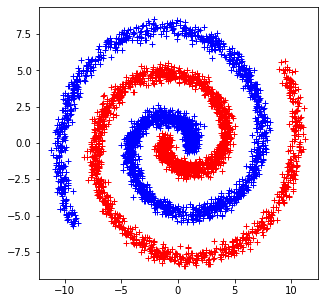

In [6]:
vis_data(X_train, y_train) # visualize training set

We use the `TensorDataset` wrapper from pytorch, so that the framework can easily understand our tensors as a proper dataset.

In [7]:
from torch.utils.data import TensorDataset, DataLoader
training_set = TensorDataset(X_train, y_train)

###  Training the model with a neural network

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll work on to improve it during this exercise.

Look at the code and run it to see the structure, then follow the questions below to iteratively improve the model.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

At the first step, we define a neural network with just one layer. A useful tutorial for constructing model can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [49]:
# Basic network structure with a single layer

def linear_block(in_features, out_features, activation, *args, **kwargs):
    block = nn.Sequential(nn.Linear(in_features, out_features), activation)
    return block

class Model(nn.Module):

    def __init__(self, activation:str, n_neurons:list, in_dim=2, out_dim=1, logits=False):
        super(Model, self).__init__()

        activations = nn.ModuleDict([["relu", nn.ReLU()], ["lrelu", nn.LeakyReLU()], ["sigmoid", nn.Sigmoid()], ["tanh", nn.Tanh()]])
        
        self.logits = logits
        self.neurons = n_neurons   
        if self.neurons: 
            in_neurons, out_neurons = [in_dim] + self.neurons, self.neurons + [out_dim]
            self.linear_blocks = [linear_block(in_f, out_f, activations[activation]) for in_f, out_f in list(zip(in_neurons, out_neurons))[:-1]]
            self.encoder = nn.Sequential(*self.linear_blocks, nn.Linear(self.neurons[-1], out_dim))
        else:
            self.encoder = nn.Linear(in_dim, out_dim)
        
    def forward(self, inputs, logits=True):
        # We want the model to predict 0 for one class and 1 for the other class
        # A Sigmoid activation function seems appropriate
        
        outputs = self.encoder(inputs)
        if not self.logits: outputs = torch.sigmoid(outputs)
        return outputs

In [19]:
# Create the model: 
model = Model(activation="tanh", n_neurons=[10, 10, 10, 10, 10])

# Choose the hyperparameters for training: 
num_epochs = 1000
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

#### Training the defined model
More information can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [20]:
class EarlyStopping:

    
    def __init__(self, patience=7, eps=5e-4):

        self.patience = patience
        self.eps = eps
        self.counter = 0
        self.past_loss = np.inf

    def __call__(self, curr_loss):
        if np.abs(curr_loss - self.past_loss) < self.eps:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.counter = 0
            self.past_loss = curr_loss
            return False

In [21]:
# define a function for training
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    ES = EarlyStopping()
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (X_batch, y_real) in train_loader:
            y_pre = model(X_batch).view(-1)
            loss = criterion(y_pre, y_real.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, epoch_average_loss))
        
        if ES(epoch_average_loss):
            print(f"No improvement for {ES.patience} epochs, stopping")
            break
    return train_error, epoch+1

#### Evaluate the model on the validation set

In [22]:
# Generate 1000 validation data:
X_val, y_val = generate_data(1000)

In [23]:
# predict labels for validation set
model.eval() # set the model to test mode
with torch.no_grad():
    y_pre = model(X_val).view(-1)

In [24]:
# Calculate the accuracy on validation set to evaluate the model by the function accuracy
def accuracy(y_real, y_pre):
    y_pre[y_pre<0.5] = 0
    y_pre[y_pre>=0.5] = 1

    acc = 1 - torch.sum(torch.abs(y_pre - y_real))/len(y_pre)
    print('Accuracy of the network on the 1000 validation data: {:.2f} %'.format(acc.item()*100))
    return acc.item()

In [26]:
# Compare the prediction with real labels

def compare_pred(X, y_real, y_pre):
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.plot(X[y_real==1, 0], X[y_real==1, 1], 'r+') #Examples are represented as a red plusses for label 1
    plt.plot(X[y_real==0, 0], X[y_real==0, 1], 'b+') #Examples are represented as a blue plusses for label 0
    plt.title("real data")

    plt.subplot(122)
    plt.plot(X[y_pre==1, 0], X[y_pre==1, 1], 'r+')
    plt.plot(X[y_pre==0, 0], X[y_pre==0, 1], 'b+')
    plt.title("prediciton results")

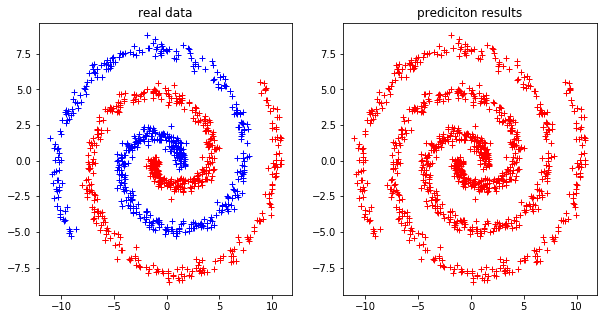

In [27]:
compare_pred(X_val, y_val, y_pre)

### Exercice 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try to different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons for each layer (5, 10, 20, more ?)

## Parameters

In [28]:
activations = ["relu", "lrelu", "sigmoid", "tanh"]
depth_interval = [1, 5]
neurons_numbers = [5, 10, 20]

## Grid evaluation

In [37]:
results = {"depth": [], "activation":[], "neurons":[], "acc":[], "num_epochs":[]}
start_time = time.time()
for depth in range(depth_interval[0], depth_interval[1]+1):
    for activation in activations:
        for neurons in neurons_numbers:
            print(f"------- Training model with depth : {depth}, activation : {activation}, and neurons: {neurons}")
            # Init model 
            model = Model(activation=activation, n_neurons=[neurons]*depth)
            criterion = nn.MSELoss()
            optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
            train_error, _num_epochs = train(num_epochs, batch_size, criterion, optimizer, model, training_set)
            
            # predict labels for validation set
            model.eval() # set the model to test mode
            with torch.no_grad():
                y_pre = model(X_val).view(-1)
                
            acc = accuracy(y_val, y_pre)
            
            curr_res = {"depth": depth, "activation":activation, "neurons":neurons, "acc":acc, "num_epochs":_num_epochs}
            [results[key].append(val) for key, val in curr_res.items()]
            
print(f"Grid evaluation took {time.time()-start_time} sec")         

------- Training model with depth : 1, activation : relu, and neurons: 5
Epoch [1/1000], Loss: 0.2444
Epoch [2/1000], Loss: 0.2420
Epoch [3/1000], Loss: 0.2415
Epoch [4/1000], Loss: 0.2411
Epoch [5/1000], Loss: 0.2409
Epoch [6/1000], Loss: 0.2407
Epoch [7/1000], Loss: 0.2404
Epoch [8/1000], Loss: 0.2400
Epoch [9/1000], Loss: 0.2397
Epoch [10/1000], Loss: 0.2393
Epoch [11/1000], Loss: 0.2388
Epoch [12/1000], Loss: 0.2384
Epoch [13/1000], Loss: 0.2380
Epoch [14/1000], Loss: 0.2377
Epoch [15/1000], Loss: 0.2373
Epoch [16/1000], Loss: 0.2369
Epoch [17/1000], Loss: 0.2366
Epoch [18/1000], Loss: 0.2363
Epoch [19/1000], Loss: 0.2361
Epoch [20/1000], Loss: 0.2359
Epoch [21/1000], Loss: 0.2356
Epoch [22/1000], Loss: 0.2354
Epoch [23/1000], Loss: 0.2352
Epoch [24/1000], Loss: 0.2351
Epoch [25/1000], Loss: 0.2349
Epoch [26/1000], Loss: 0.2348
Epoch [27/1000], Loss: 0.2347
Epoch [28/1000], Loss: 0.2345
Epoch [29/1000], Loss: 0.2346
Epoch [30/1000], Loss: 0.2345
Epoch [31/1000], Loss: 0.2343
Epoch 

Epoch [268/1000], Loss: 0.1908
Epoch [269/1000], Loss: 0.1908
Epoch [270/1000], Loss: 0.1906
Epoch [271/1000], Loss: 0.1900
Epoch [272/1000], Loss: 0.1910
Epoch [273/1000], Loss: 0.1903
Epoch [274/1000], Loss: 0.1901
Epoch [275/1000], Loss: 0.1896
Epoch [276/1000], Loss: 0.1898
Epoch [277/1000], Loss: 0.1902
Epoch [278/1000], Loss: 0.1900
Epoch [279/1000], Loss: 0.1891
Epoch [280/1000], Loss: 0.1896
Epoch [281/1000], Loss: 0.1894
Epoch [282/1000], Loss: 0.1892
Epoch [283/1000], Loss: 0.1888
Epoch [284/1000], Loss: 0.1890
Epoch [285/1000], Loss: 0.1882
Epoch [286/1000], Loss: 0.1887
Epoch [287/1000], Loss: 0.1879
Epoch [288/1000], Loss: 0.1889
Epoch [289/1000], Loss: 0.1881
Epoch [290/1000], Loss: 0.1879
Epoch [291/1000], Loss: 0.1874
Epoch [292/1000], Loss: 0.1882
Epoch [293/1000], Loss: 0.1876
Epoch [294/1000], Loss: 0.1877
Epoch [295/1000], Loss: 0.1877
Epoch [296/1000], Loss: 0.1879
Epoch [297/1000], Loss: 0.1874
Epoch [298/1000], Loss: 0.1870
Epoch [299/1000], Loss: 0.1868
Epoch [3

Epoch [3/1000], Loss: 0.2376
Epoch [4/1000], Loss: 0.2371
Epoch [5/1000], Loss: 0.2367
Epoch [6/1000], Loss: 0.2361
Epoch [7/1000], Loss: 0.2357
Epoch [8/1000], Loss: 0.2355
Epoch [9/1000], Loss: 0.2352
Epoch [10/1000], Loss: 0.2345
Epoch [11/1000], Loss: 0.2346
Epoch [12/1000], Loss: 0.2343
Epoch [13/1000], Loss: 0.2342
Epoch [14/1000], Loss: 0.2340
Epoch [15/1000], Loss: 0.2337
Epoch [16/1000], Loss: 0.2336
Epoch [17/1000], Loss: 0.2333
Epoch [18/1000], Loss: 0.2334
Epoch [19/1000], Loss: 0.2331
Epoch [20/1000], Loss: 0.2330
Epoch [21/1000], Loss: 0.2329
Epoch [22/1000], Loss: 0.2324
Epoch [23/1000], Loss: 0.2326
Epoch [24/1000], Loss: 0.2324
Epoch [25/1000], Loss: 0.2322
Epoch [26/1000], Loss: 0.2318
Epoch [27/1000], Loss: 0.2318
Epoch [28/1000], Loss: 0.2315
Epoch [29/1000], Loss: 0.2314
Epoch [30/1000], Loss: 0.2310
Epoch [31/1000], Loss: 0.2310
Epoch [32/1000], Loss: 0.2309
Epoch [33/1000], Loss: 0.2309
Epoch [34/1000], Loss: 0.2309
Epoch [35/1000], Loss: 0.2306
Epoch [36/1000], 

Epoch [65/1000], Loss: 0.2192
Epoch [66/1000], Loss: 0.2187
Epoch [67/1000], Loss: 0.2183
Epoch [68/1000], Loss: 0.2174
Epoch [69/1000], Loss: 0.2172
Epoch [70/1000], Loss: 0.2166
Epoch [71/1000], Loss: 0.2159
Epoch [72/1000], Loss: 0.2150
Epoch [73/1000], Loss: 0.2148
Epoch [74/1000], Loss: 0.2143
Epoch [75/1000], Loss: 0.2132
Epoch [76/1000], Loss: 0.2129
Epoch [77/1000], Loss: 0.2124
Epoch [78/1000], Loss: 0.2117
Epoch [79/1000], Loss: 0.2109
Epoch [80/1000], Loss: 0.2101
Epoch [81/1000], Loss: 0.2096
Epoch [82/1000], Loss: 0.2085
Epoch [83/1000], Loss: 0.2078
Epoch [84/1000], Loss: 0.2075
Epoch [85/1000], Loss: 0.2064
Epoch [86/1000], Loss: 0.2058
Epoch [87/1000], Loss: 0.2047
Epoch [88/1000], Loss: 0.2041
Epoch [89/1000], Loss: 0.2032
Epoch [90/1000], Loss: 0.2028
Epoch [91/1000], Loss: 0.2017
Epoch [92/1000], Loss: 0.2009
Epoch [93/1000], Loss: 0.1996
Epoch [94/1000], Loss: 0.1992
Epoch [95/1000], Loss: 0.1983
Epoch [96/1000], Loss: 0.1964
Epoch [97/1000], Loss: 0.1968
Epoch [98/

Epoch [331/1000], Loss: 0.0681
Epoch [332/1000], Loss: 0.0682
Epoch [333/1000], Loss: 0.0680
Epoch [334/1000], Loss: 0.0672
Epoch [335/1000], Loss: 0.0670
Epoch [336/1000], Loss: 0.0665
Epoch [337/1000], Loss: 0.0662
Epoch [338/1000], Loss: 0.0661
Epoch [339/1000], Loss: 0.0650
Epoch [340/1000], Loss: 0.0655
Epoch [341/1000], Loss: 0.0649
Epoch [342/1000], Loss: 0.0649
Epoch [343/1000], Loss: 0.0646
Epoch [344/1000], Loss: 0.0639
Epoch [345/1000], Loss: 0.0639
Epoch [346/1000], Loss: 0.0641
Epoch [347/1000], Loss: 0.0633
Epoch [348/1000], Loss: 0.0632
Epoch [349/1000], Loss: 0.0629
Epoch [350/1000], Loss: 0.0622
Epoch [351/1000], Loss: 0.0623
Epoch [352/1000], Loss: 0.0620
Epoch [353/1000], Loss: 0.0619
Epoch [354/1000], Loss: 0.0618
Epoch [355/1000], Loss: 0.0617
Epoch [356/1000], Loss: 0.0613
Epoch [357/1000], Loss: 0.0605
Epoch [358/1000], Loss: 0.0608
Epoch [359/1000], Loss: 0.0607
Epoch [360/1000], Loss: 0.0601
Epoch [361/1000], Loss: 0.0603
Epoch [362/1000], Loss: 0.0597
Epoch [3

Epoch [47/1000], Loss: 0.2301
Epoch [48/1000], Loss: 0.2299
Epoch [49/1000], Loss: 0.2297
Epoch [50/1000], Loss: 0.2296
Epoch [51/1000], Loss: 0.2294
Epoch [52/1000], Loss: 0.2292
Epoch [53/1000], Loss: 0.2291
Epoch [54/1000], Loss: 0.2289
Epoch [55/1000], Loss: 0.2288
Epoch [56/1000], Loss: 0.2286
Epoch [57/1000], Loss: 0.2285
Epoch [58/1000], Loss: 0.2283
Epoch [59/1000], Loss: 0.2282
Epoch [60/1000], Loss: 0.2280
Epoch [61/1000], Loss: 0.2278
Epoch [62/1000], Loss: 0.2277
Epoch [63/1000], Loss: 0.2275
Epoch [64/1000], Loss: 0.2273
Epoch [65/1000], Loss: 0.2272
Epoch [66/1000], Loss: 0.2271
Epoch [67/1000], Loss: 0.2269
Epoch [68/1000], Loss: 0.2267
Epoch [69/1000], Loss: 0.2266
Epoch [70/1000], Loss: 0.2264
Epoch [71/1000], Loss: 0.2262
Epoch [72/1000], Loss: 0.2261
Epoch [73/1000], Loss: 0.2258
Epoch [74/1000], Loss: 0.2258
Epoch [75/1000], Loss: 0.2256
Epoch [76/1000], Loss: 0.2253
Epoch [77/1000], Loss: 0.2252
Epoch [78/1000], Loss: 0.2251
Epoch [79/1000], Loss: 0.2249
Epoch [80/

Epoch [184/1000], Loss: 0.1983
Epoch [185/1000], Loss: 0.1983
Epoch [186/1000], Loss: 0.1978
Epoch [187/1000], Loss: 0.1979
Epoch [188/1000], Loss: 0.1979
Epoch [189/1000], Loss: 0.1976
Epoch [190/1000], Loss: 0.1973
Epoch [191/1000], Loss: 0.1977
Epoch [192/1000], Loss: 0.1969
Epoch [193/1000], Loss: 0.1971
Epoch [194/1000], Loss: 0.1971
Epoch [195/1000], Loss: 0.1967
Epoch [196/1000], Loss: 0.1968
Epoch [197/1000], Loss: 0.1960
Epoch [198/1000], Loss: 0.1963
Epoch [199/1000], Loss: 0.1960
Epoch [200/1000], Loss: 0.1963
Epoch [201/1000], Loss: 0.1962
Epoch [202/1000], Loss: 0.1960
Epoch [203/1000], Loss: 0.1959
Epoch [204/1000], Loss: 0.1956
No improvement for 7 epochs, stopping
------- Training model with depth : 1, activation : tanh, and neurons: 20
Epoch [1/1000], Loss: 0.2511
Epoch [2/1000], Loss: 0.2401
Epoch [3/1000], Loss: 0.2389
Epoch [4/1000], Loss: 0.2380
Epoch [5/1000], Loss: 0.2377
Epoch [6/1000], Loss: 0.2372
Epoch [7/1000], Loss: 0.2367
Epoch [8/1000], Loss: 0.2363
Epoch

Epoch [246/1000], Loss: 0.1102
Epoch [247/1000], Loss: 0.1093
Epoch [248/1000], Loss: 0.1092
Epoch [249/1000], Loss: 0.1082
Epoch [250/1000], Loss: 0.1076
Epoch [251/1000], Loss: 0.1074
Epoch [252/1000], Loss: 0.1064
Epoch [253/1000], Loss: 0.1063
Epoch [254/1000], Loss: 0.1056
Epoch [255/1000], Loss: 0.1048
Epoch [256/1000], Loss: 0.1043
Epoch [257/1000], Loss: 0.1038
Epoch [258/1000], Loss: 0.1034
Epoch [259/1000], Loss: 0.1032
Epoch [260/1000], Loss: 0.1029
Epoch [261/1000], Loss: 0.1024
Epoch [262/1000], Loss: 0.1017
Epoch [263/1000], Loss: 0.1012
Epoch [264/1000], Loss: 0.1010
Epoch [265/1000], Loss: 0.1008
Epoch [266/1000], Loss: 0.1002
Epoch [267/1000], Loss: 0.0998
Epoch [268/1000], Loss: 0.0992
Epoch [269/1000], Loss: 0.0985
Epoch [270/1000], Loss: 0.0975
Epoch [271/1000], Loss: 0.0969
Epoch [272/1000], Loss: 0.0960
Epoch [273/1000], Loss: 0.0952
Epoch [274/1000], Loss: 0.0945
Epoch [275/1000], Loss: 0.0934
Epoch [276/1000], Loss: 0.0918
Epoch [277/1000], Loss: 0.0894
Epoch [2

Epoch [16/1000], Loss: 0.2342
Epoch [17/1000], Loss: 0.2339
Epoch [18/1000], Loss: 0.2336
Epoch [19/1000], Loss: 0.2333
Epoch [20/1000], Loss: 0.2330
Epoch [21/1000], Loss: 0.2327
Epoch [22/1000], Loss: 0.2324
Epoch [23/1000], Loss: 0.2321
Epoch [24/1000], Loss: 0.2317
Epoch [25/1000], Loss: 0.2314
Epoch [26/1000], Loss: 0.2311
Epoch [27/1000], Loss: 0.2307
Epoch [28/1000], Loss: 0.2304
Epoch [29/1000], Loss: 0.2300
Epoch [30/1000], Loss: 0.2296
Epoch [31/1000], Loss: 0.2293
Epoch [32/1000], Loss: 0.2289
Epoch [33/1000], Loss: 0.2284
Epoch [34/1000], Loss: 0.2280
Epoch [35/1000], Loss: 0.2275
Epoch [36/1000], Loss: 0.2271
Epoch [37/1000], Loss: 0.2265
Epoch [38/1000], Loss: 0.2260
Epoch [39/1000], Loss: 0.2255
Epoch [40/1000], Loss: 0.2249
Epoch [41/1000], Loss: 0.2243
Epoch [42/1000], Loss: 0.2237
Epoch [43/1000], Loss: 0.2230
Epoch [44/1000], Loss: 0.2223
Epoch [45/1000], Loss: 0.2216
Epoch [46/1000], Loss: 0.2209
Epoch [47/1000], Loss: 0.2201
Epoch [48/1000], Loss: 0.2193
Epoch [49/

Epoch [22/1000], Loss: 0.2300
Epoch [23/1000], Loss: 0.2296
Epoch [24/1000], Loss: 0.2291
Epoch [25/1000], Loss: 0.2287
Epoch [26/1000], Loss: 0.2283
Epoch [27/1000], Loss: 0.2278
Epoch [28/1000], Loss: 0.2271
Epoch [29/1000], Loss: 0.2270
Epoch [30/1000], Loss: 0.2264
Epoch [31/1000], Loss: 0.2258
Epoch [32/1000], Loss: 0.2252
Epoch [33/1000], Loss: 0.2245
Epoch [34/1000], Loss: 0.2238
Epoch [35/1000], Loss: 0.2232
Epoch [36/1000], Loss: 0.2221
Epoch [37/1000], Loss: 0.2216
Epoch [38/1000], Loss: 0.2206
Epoch [39/1000], Loss: 0.2197
Epoch [40/1000], Loss: 0.2187
Epoch [41/1000], Loss: 0.2177
Epoch [42/1000], Loss: 0.2167
Epoch [43/1000], Loss: 0.2152
Epoch [44/1000], Loss: 0.2140
Epoch [45/1000], Loss: 0.2124
Epoch [46/1000], Loss: 0.2110
Epoch [47/1000], Loss: 0.2092
Epoch [48/1000], Loss: 0.2066
Epoch [49/1000], Loss: 0.2045
Epoch [50/1000], Loss: 0.2027
Epoch [51/1000], Loss: 0.2005
Epoch [52/1000], Loss: 0.1981
Epoch [53/1000], Loss: 0.1957
Epoch [54/1000], Loss: 0.1926
Epoch [55/

Epoch [69/1000], Loss: 0.0402
Epoch [70/1000], Loss: 0.0361
Epoch [71/1000], Loss: 0.0327
Epoch [72/1000], Loss: 0.0297
Epoch [73/1000], Loss: 0.0274
Epoch [74/1000], Loss: 0.0251
Epoch [75/1000], Loss: 0.0232
Epoch [76/1000], Loss: 0.0213
Epoch [77/1000], Loss: 0.0197
Epoch [78/1000], Loss: 0.0183
Epoch [79/1000], Loss: 0.0170
Epoch [80/1000], Loss: 0.0158
Epoch [81/1000], Loss: 0.0149
Epoch [82/1000], Loss: 0.0140
Epoch [83/1000], Loss: 0.0130
Epoch [84/1000], Loss: 0.0123
Epoch [85/1000], Loss: 0.0117
Epoch [86/1000], Loss: 0.0110
Epoch [87/1000], Loss: 0.0104
Epoch [88/1000], Loss: 0.0099
Epoch [89/1000], Loss: 0.0095
Epoch [90/1000], Loss: 0.0090
Epoch [91/1000], Loss: 0.0086
Epoch [92/1000], Loss: 0.0082
Epoch [93/1000], Loss: 0.0080
Epoch [94/1000], Loss: 0.0076
Epoch [95/1000], Loss: 0.0073
Epoch [96/1000], Loss: 0.0070
Epoch [97/1000], Loss: 0.0067
Epoch [98/1000], Loss: 0.0064
Epoch [99/1000], Loss: 0.0062
Epoch [100/1000], Loss: 0.0060
Epoch [101/1000], Loss: 0.0058
Epoch [1

Epoch [25/1000], Loss: 0.2357
Epoch [26/1000], Loss: 0.2356
Epoch [27/1000], Loss: 0.2354
Epoch [28/1000], Loss: 0.2352
Epoch [29/1000], Loss: 0.2352
Epoch [30/1000], Loss: 0.2350
Epoch [31/1000], Loss: 0.2349
Epoch [32/1000], Loss: 0.2348
Epoch [33/1000], Loss: 0.2346
Epoch [34/1000], Loss: 0.2345
Epoch [35/1000], Loss: 0.2344
Epoch [36/1000], Loss: 0.2342
Epoch [37/1000], Loss: 0.2341
Epoch [38/1000], Loss: 0.2340
Epoch [39/1000], Loss: 0.2339
Epoch [40/1000], Loss: 0.2337
Epoch [41/1000], Loss: 0.2335
Epoch [42/1000], Loss: 0.2334
Epoch [43/1000], Loss: 0.2333
Epoch [44/1000], Loss: 0.2331
Epoch [45/1000], Loss: 0.2330
Epoch [46/1000], Loss: 0.2328
Epoch [47/1000], Loss: 0.2327
Epoch [48/1000], Loss: 0.2326
Epoch [49/1000], Loss: 0.2324
Epoch [50/1000], Loss: 0.2322
Epoch [51/1000], Loss: 0.2320
Epoch [52/1000], Loss: 0.2318
Epoch [53/1000], Loss: 0.2316
Epoch [54/1000], Loss: 0.2314
Epoch [55/1000], Loss: 0.2311
Epoch [56/1000], Loss: 0.2307
Epoch [57/1000], Loss: 0.2304
Epoch [58/

Epoch [100/1000], Loss: 0.0077
Epoch [101/1000], Loss: 0.0076
Epoch [102/1000], Loss: 0.0073
Epoch [103/1000], Loss: 0.0071
Epoch [104/1000], Loss: 0.0068
Epoch [105/1000], Loss: 0.0067
Epoch [106/1000], Loss: 0.0065
Epoch [107/1000], Loss: 0.0064
Epoch [108/1000], Loss: 0.0061
Epoch [109/1000], Loss: 0.0060
Epoch [110/1000], Loss: 0.0061
Epoch [111/1000], Loss: 0.0056
Epoch [112/1000], Loss: 0.0055
Epoch [113/1000], Loss: 0.0053
Epoch [114/1000], Loss: 0.0052
Epoch [115/1000], Loss: 0.0051
Epoch [116/1000], Loss: 0.0049
Epoch [117/1000], Loss: 0.0049
Epoch [118/1000], Loss: 0.0047
Epoch [119/1000], Loss: 0.0046
Epoch [120/1000], Loss: 0.0045
Epoch [121/1000], Loss: 0.0044
Epoch [122/1000], Loss: 0.0044
Epoch [123/1000], Loss: 0.0043
Epoch [124/1000], Loss: 0.0041
Epoch [125/1000], Loss: 0.0041
Epoch [126/1000], Loss: 0.0040
Epoch [127/1000], Loss: 0.0039
Epoch [128/1000], Loss: 0.0039
Epoch [129/1000], Loss: 0.0037
Epoch [130/1000], Loss: 0.0037
Epoch [131/1000], Loss: 0.0037
Epoch [1

Epoch [23/1000], Loss: 0.2361
Epoch [24/1000], Loss: 0.2360
Epoch [25/1000], Loss: 0.2359
Epoch [26/1000], Loss: 0.2358
Epoch [27/1000], Loss: 0.2357
Epoch [28/1000], Loss: 0.2355
Epoch [29/1000], Loss: 0.2355
Epoch [30/1000], Loss: 0.2353
Epoch [31/1000], Loss: 0.2352
Epoch [32/1000], Loss: 0.2351
Epoch [33/1000], Loss: 0.2350
Epoch [34/1000], Loss: 0.2349
Epoch [35/1000], Loss: 0.2347
Epoch [36/1000], Loss: 0.2346
Epoch [37/1000], Loss: 0.2344
Epoch [38/1000], Loss: 0.2343
Epoch [39/1000], Loss: 0.2341
Epoch [40/1000], Loss: 0.2340
Epoch [41/1000], Loss: 0.2338
Epoch [42/1000], Loss: 0.2337
Epoch [43/1000], Loss: 0.2335
Epoch [44/1000], Loss: 0.2333
Epoch [45/1000], Loss: 0.2331
Epoch [46/1000], Loss: 0.2329
Epoch [47/1000], Loss: 0.2328
Epoch [48/1000], Loss: 0.2326
Epoch [49/1000], Loss: 0.2323
Epoch [50/1000], Loss: 0.2321
Epoch [51/1000], Loss: 0.2319
Epoch [52/1000], Loss: 0.2316
Epoch [53/1000], Loss: 0.2312
Epoch [54/1000], Loss: 0.2308
Epoch [55/1000], Loss: 0.2303
Epoch [56/

Epoch [291/1000], Loss: 0.1786
Epoch [292/1000], Loss: 0.1784
Epoch [293/1000], Loss: 0.1782
Epoch [294/1000], Loss: 0.1779
Epoch [295/1000], Loss: 0.1778
Epoch [296/1000], Loss: 0.1777
Epoch [297/1000], Loss: 0.1775
Epoch [298/1000], Loss: 0.1773
Epoch [299/1000], Loss: 0.1772
Epoch [300/1000], Loss: 0.1770
Epoch [301/1000], Loss: 0.1769
Epoch [302/1000], Loss: 0.1766
Epoch [303/1000], Loss: 0.1764
Epoch [304/1000], Loss: 0.1764
Epoch [305/1000], Loss: 0.1761
Epoch [306/1000], Loss: 0.1759
Epoch [307/1000], Loss: 0.1757
Epoch [308/1000], Loss: 0.1757
Epoch [309/1000], Loss: 0.1755
Epoch [310/1000], Loss: 0.1754
Epoch [311/1000], Loss: 0.1751
Epoch [312/1000], Loss: 0.1750
Epoch [313/1000], Loss: 0.1749
Epoch [314/1000], Loss: 0.1746
Epoch [315/1000], Loss: 0.1746
Epoch [316/1000], Loss: 0.1745
Epoch [317/1000], Loss: 0.1742
Epoch [318/1000], Loss: 0.1741
Epoch [319/1000], Loss: 0.1740
Epoch [320/1000], Loss: 0.1737
Epoch [321/1000], Loss: 0.1736
Epoch [322/1000], Loss: 0.1736
Epoch [3

Epoch [1/1000], Loss: 0.2577
Epoch [2/1000], Loss: 0.2444
Epoch [3/1000], Loss: 0.2408
Epoch [4/1000], Loss: 0.2395
Epoch [5/1000], Loss: 0.2390
Epoch [6/1000], Loss: 0.2386
Epoch [7/1000], Loss: 0.2382
Epoch [8/1000], Loss: 0.2379
Epoch [9/1000], Loss: 0.2376
Epoch [10/1000], Loss: 0.2372
Epoch [11/1000], Loss: 0.2369
Epoch [12/1000], Loss: 0.2366
Epoch [13/1000], Loss: 0.2362
Epoch [14/1000], Loss: 0.2359
Epoch [15/1000], Loss: 0.2355
Epoch [16/1000], Loss: 0.2352
Epoch [17/1000], Loss: 0.2348
Epoch [18/1000], Loss: 0.2344
Epoch [19/1000], Loss: 0.2340
Epoch [20/1000], Loss: 0.2336
Epoch [21/1000], Loss: 0.2332
Epoch [22/1000], Loss: 0.2327
Epoch [23/1000], Loss: 0.2323
Epoch [24/1000], Loss: 0.2319
Epoch [25/1000], Loss: 0.2314
Epoch [26/1000], Loss: 0.2309
Epoch [27/1000], Loss: 0.2304
Epoch [28/1000], Loss: 0.2299
Epoch [29/1000], Loss: 0.2294
Epoch [30/1000], Loss: 0.2289
Epoch [31/1000], Loss: 0.2283
Epoch [32/1000], Loss: 0.2278
Epoch [33/1000], Loss: 0.2272
Epoch [34/1000], Lo

Epoch [269/1000], Loss: 0.0392
Epoch [270/1000], Loss: 0.0394
Epoch [271/1000], Loss: 0.0382
Epoch [272/1000], Loss: 0.0389
Epoch [273/1000], Loss: 0.0378
Epoch [274/1000], Loss: 0.0376
Epoch [275/1000], Loss: 0.0374
Epoch [276/1000], Loss: 0.0383
Epoch [277/1000], Loss: 0.0354
Epoch [278/1000], Loss: 0.0364
Epoch [279/1000], Loss: 0.0342
Epoch [280/1000], Loss: 0.0337
Epoch [281/1000], Loss: 0.0324
Epoch [282/1000], Loss: 0.0295
Epoch [283/1000], Loss: 0.0291
Epoch [284/1000], Loss: 0.0281
Epoch [285/1000], Loss: 0.0254
Epoch [286/1000], Loss: 0.0256
Epoch [287/1000], Loss: 0.0237
Epoch [288/1000], Loss: 0.0226
Epoch [289/1000], Loss: 0.0223
Epoch [290/1000], Loss: 0.0209
Epoch [291/1000], Loss: 0.0197
Epoch [292/1000], Loss: 0.0196
Epoch [293/1000], Loss: 0.0184
Epoch [294/1000], Loss: 0.0187
Epoch [295/1000], Loss: 0.0175
Epoch [296/1000], Loss: 0.0173
Epoch [297/1000], Loss: 0.0163
Epoch [298/1000], Loss: 0.0164
Epoch [299/1000], Loss: 0.0158
Epoch [300/1000], Loss: 0.0151
Epoch [3

Epoch [175/1000], Loss: 0.0231
Epoch [176/1000], Loss: 0.0222
Epoch [177/1000], Loss: 0.0216
Epoch [178/1000], Loss: 0.0209
Epoch [179/1000], Loss: 0.0201
Epoch [180/1000], Loss: 0.0200
Epoch [181/1000], Loss: 0.0189
Epoch [182/1000], Loss: 0.0184
Epoch [183/1000], Loss: 0.0179
Epoch [184/1000], Loss: 0.0175
Epoch [185/1000], Loss: 0.0168
Epoch [186/1000], Loss: 0.0165
Epoch [187/1000], Loss: 0.0158
Epoch [188/1000], Loss: 0.0154
Epoch [189/1000], Loss: 0.0150
Epoch [190/1000], Loss: 0.0146
Epoch [191/1000], Loss: 0.0140
Epoch [192/1000], Loss: 0.0139
Epoch [193/1000], Loss: 0.0135
Epoch [194/1000], Loss: 0.0127
Epoch [195/1000], Loss: 0.0125
Epoch [196/1000], Loss: 0.0122
Epoch [197/1000], Loss: 0.0119
Epoch [198/1000], Loss: 0.0115
Epoch [199/1000], Loss: 0.0114
Epoch [200/1000], Loss: 0.0110
Epoch [201/1000], Loss: 0.0107
Epoch [202/1000], Loss: 0.0105
Epoch [203/1000], Loss: 0.0102
Epoch [204/1000], Loss: 0.0100
Epoch [205/1000], Loss: 0.0096
Epoch [206/1000], Loss: 0.0095
Epoch [2

Epoch [35/1000], Loss: 0.2272
Epoch [36/1000], Loss: 0.2263
Epoch [37/1000], Loss: 0.2253
Epoch [38/1000], Loss: 0.2242
Epoch [39/1000], Loss: 0.2230
Epoch [40/1000], Loss: 0.2216
Epoch [41/1000], Loss: 0.2202
Epoch [42/1000], Loss: 0.2188
Epoch [43/1000], Loss: 0.2169
Epoch [44/1000], Loss: 0.2147
Epoch [45/1000], Loss: 0.2123
Epoch [46/1000], Loss: 0.2093
Epoch [47/1000], Loss: 0.2062
Epoch [48/1000], Loss: 0.2028
Epoch [49/1000], Loss: 0.1986
Epoch [50/1000], Loss: 0.1931
Epoch [51/1000], Loss: 0.1863
Epoch [52/1000], Loss: 0.1787
Epoch [53/1000], Loss: 0.1711
Epoch [54/1000], Loss: 0.1622
Epoch [55/1000], Loss: 0.1532
Epoch [56/1000], Loss: 0.1432
Epoch [57/1000], Loss: 0.1322
Epoch [58/1000], Loss: 0.1219
Epoch [59/1000], Loss: 0.1127
Epoch [60/1000], Loss: 0.1048
Epoch [61/1000], Loss: 0.0968
Epoch [62/1000], Loss: 0.0887
Epoch [63/1000], Loss: 0.0817
Epoch [64/1000], Loss: 0.0742
Epoch [65/1000], Loss: 0.0677
Epoch [66/1000], Loss: 0.0606
Epoch [67/1000], Loss: 0.0548
Epoch [68/

Epoch [92/1000], Loss: 0.0631
Epoch [93/1000], Loss: 0.0619
Epoch [94/1000], Loss: 0.0607
Epoch [95/1000], Loss: 0.0591
Epoch [96/1000], Loss: 0.0582
Epoch [97/1000], Loss: 0.0566
Epoch [98/1000], Loss: 0.0558
Epoch [99/1000], Loss: 0.0550
Epoch [100/1000], Loss: 0.0534
Epoch [101/1000], Loss: 0.0536
Epoch [102/1000], Loss: 0.0523
Epoch [103/1000], Loss: 0.0515
Epoch [104/1000], Loss: 0.0504
Epoch [105/1000], Loss: 0.0490
Epoch [106/1000], Loss: 0.0482
Epoch [107/1000], Loss: 0.0477
Epoch [108/1000], Loss: 0.0464
Epoch [109/1000], Loss: 0.0458
Epoch [110/1000], Loss: 0.0453
Epoch [111/1000], Loss: 0.0448
Epoch [112/1000], Loss: 0.0439
Epoch [113/1000], Loss: 0.0434
Epoch [114/1000], Loss: 0.0433
Epoch [115/1000], Loss: 0.0426
Epoch [116/1000], Loss: 0.0415
Epoch [117/1000], Loss: 0.0410
Epoch [118/1000], Loss: 0.0418
Epoch [119/1000], Loss: 0.0408
Epoch [120/1000], Loss: 0.0403
Epoch [121/1000], Loss: 0.0395
Epoch [122/1000], Loss: 0.0393
Epoch [123/1000], Loss: 0.0381
Epoch [124/1000]

Epoch [83/1000], Loss: 0.0362
Epoch [84/1000], Loss: 0.0338
Epoch [85/1000], Loss: 0.0331
Epoch [86/1000], Loss: 0.0277
Epoch [87/1000], Loss: 0.0226
Epoch [88/1000], Loss: 0.0213
Epoch [89/1000], Loss: 0.0188
Epoch [90/1000], Loss: 0.0174
Epoch [91/1000], Loss: 0.0154
Epoch [92/1000], Loss: 0.0145
Epoch [93/1000], Loss: 0.0133
Epoch [94/1000], Loss: 0.0125
Epoch [95/1000], Loss: 0.0110
Epoch [96/1000], Loss: 0.0104
Epoch [97/1000], Loss: 0.0100
Epoch [98/1000], Loss: 0.0089
Epoch [99/1000], Loss: 0.0090
Epoch [100/1000], Loss: 0.0083
Epoch [101/1000], Loss: 0.0076
Epoch [102/1000], Loss: 0.0076
Epoch [103/1000], Loss: 0.0070
Epoch [104/1000], Loss: 0.0068
Epoch [105/1000], Loss: 0.0061
Epoch [106/1000], Loss: 0.0060
Epoch [107/1000], Loss: 0.0058
Epoch [108/1000], Loss: 0.0057
Epoch [109/1000], Loss: 0.0053
Epoch [110/1000], Loss: 0.0050
Epoch [111/1000], Loss: 0.0045
Epoch [112/1000], Loss: 0.0044
Epoch [113/1000], Loss: 0.0045
Epoch [114/1000], Loss: 0.0042
Epoch [115/1000], Loss: 0

Epoch [79/1000], Loss: 0.1822
Epoch [80/1000], Loss: 0.1816
Epoch [81/1000], Loss: 0.1805
Epoch [82/1000], Loss: 0.1784
Epoch [83/1000], Loss: 0.1779
Epoch [84/1000], Loss: 0.1769
Epoch [85/1000], Loss: 0.1758
Epoch [86/1000], Loss: 0.1752
Epoch [87/1000], Loss: 0.1746
Epoch [88/1000], Loss: 0.1737
Epoch [89/1000], Loss: 0.1730
Epoch [90/1000], Loss: 0.1720
Epoch [91/1000], Loss: 0.1710
Epoch [92/1000], Loss: 0.1710
Epoch [93/1000], Loss: 0.1699
Epoch [94/1000], Loss: 0.1692
Epoch [95/1000], Loss: 0.1691
Epoch [96/1000], Loss: 0.1684
Epoch [97/1000], Loss: 0.1673
Epoch [98/1000], Loss: 0.1672
Epoch [99/1000], Loss: 0.1670
Epoch [100/1000], Loss: 0.1663
Epoch [101/1000], Loss: 0.1657
Epoch [102/1000], Loss: 0.1656
Epoch [103/1000], Loss: 0.1648
Epoch [104/1000], Loss: 0.1640
Epoch [105/1000], Loss: 0.1640
Epoch [106/1000], Loss: 0.1639
Epoch [107/1000], Loss: 0.1637
Epoch [108/1000], Loss: 0.1631
Epoch [109/1000], Loss: 0.1631
Epoch [110/1000], Loss: 0.1627
Epoch [111/1000], Loss: 0.162

Epoch [344/1000], Loss: 0.0780
Epoch [345/1000], Loss: 0.0771
Epoch [346/1000], Loss: 0.0758
Epoch [347/1000], Loss: 0.0749
Epoch [348/1000], Loss: 0.0739
Epoch [349/1000], Loss: 0.0730
Epoch [350/1000], Loss: 0.0718
Epoch [351/1000], Loss: 0.0707
Epoch [352/1000], Loss: 0.0701
Epoch [353/1000], Loss: 0.0695
Epoch [354/1000], Loss: 0.0686
Epoch [355/1000], Loss: 0.0679
Epoch [356/1000], Loss: 0.0674
Epoch [357/1000], Loss: 0.0672
Epoch [358/1000], Loss: 0.0666
Epoch [359/1000], Loss: 0.0666
Epoch [360/1000], Loss: 0.0654
Epoch [361/1000], Loss: 0.0653
Epoch [362/1000], Loss: 0.0645
Epoch [363/1000], Loss: 0.0646
Epoch [364/1000], Loss: 0.0642
Epoch [365/1000], Loss: 0.0639
Epoch [366/1000], Loss: 0.0635
Epoch [367/1000], Loss: 0.0633
Epoch [368/1000], Loss: 0.0625
Epoch [369/1000], Loss: 0.0624
Epoch [370/1000], Loss: 0.0620
Epoch [371/1000], Loss: 0.0617
Epoch [372/1000], Loss: 0.0613
Epoch [373/1000], Loss: 0.0606
Epoch [374/1000], Loss: 0.0613
Epoch [375/1000], Loss: 0.0610
Epoch [3

Epoch [610/1000], Loss: 0.0039
Epoch [611/1000], Loss: 0.0030
Epoch [612/1000], Loss: 0.0027
Epoch [613/1000], Loss: 0.0041
Epoch [614/1000], Loss: 0.0051
Epoch [615/1000], Loss: 0.0028
Epoch [616/1000], Loss: 0.0075
Epoch [617/1000], Loss: 0.0034
Epoch [618/1000], Loss: 0.0027
Epoch [619/1000], Loss: 0.0027
Epoch [620/1000], Loss: 0.0029
Epoch [621/1000], Loss: 0.0030
Epoch [622/1000], Loss: 0.0041
Epoch [623/1000], Loss: 0.0045
Epoch [624/1000], Loss: 0.0025
Epoch [625/1000], Loss: 0.0028
Epoch [626/1000], Loss: 0.0042
Epoch [627/1000], Loss: 0.0028
Epoch [628/1000], Loss: 0.0028
Epoch [629/1000], Loss: 0.0029
Epoch [630/1000], Loss: 0.0046
Epoch [631/1000], Loss: 0.0060
Epoch [632/1000], Loss: 0.0025
Epoch [633/1000], Loss: 0.0024
Epoch [634/1000], Loss: 0.0033
Epoch [635/1000], Loss: 0.0031
Epoch [636/1000], Loss: 0.0024
Epoch [637/1000], Loss: 0.0026
Epoch [638/1000], Loss: 0.0052
Epoch [639/1000], Loss: 0.0025
Epoch [640/1000], Loss: 0.0035
Epoch [641/1000], Loss: 0.0026
Epoch [6

Epoch [27/1000], Loss: 0.2306
Epoch [28/1000], Loss: 0.2300
Epoch [29/1000], Loss: 0.2292
Epoch [30/1000], Loss: 0.2285
Epoch [31/1000], Loss: 0.2277
Epoch [32/1000], Loss: 0.2269
Epoch [33/1000], Loss: 0.2260
Epoch [34/1000], Loss: 0.2251
Epoch [35/1000], Loss: 0.2241
Epoch [36/1000], Loss: 0.2233
Epoch [37/1000], Loss: 0.2223
Epoch [38/1000], Loss: 0.2211
Epoch [39/1000], Loss: 0.2202
Epoch [40/1000], Loss: 0.2189
Epoch [41/1000], Loss: 0.2180
Epoch [42/1000], Loss: 0.2167
Epoch [43/1000], Loss: 0.2153
Epoch [44/1000], Loss: 0.2142
Epoch [45/1000], Loss: 0.2129
Epoch [46/1000], Loss: 0.2118
Epoch [47/1000], Loss: 0.2102
Epoch [48/1000], Loss: 0.2092
Epoch [49/1000], Loss: 0.2077
Epoch [50/1000], Loss: 0.2063
Epoch [51/1000], Loss: 0.2045
Epoch [52/1000], Loss: 0.2029
Epoch [53/1000], Loss: 0.2020
Epoch [54/1000], Loss: 0.1997
Epoch [55/1000], Loss: 0.1987
Epoch [56/1000], Loss: 0.1968
Epoch [57/1000], Loss: 0.1950
Epoch [58/1000], Loss: 0.1934
Epoch [59/1000], Loss: 0.1911
Epoch [60/

Epoch [67/1000], Loss: 0.1174
Epoch [68/1000], Loss: 0.1162
Epoch [69/1000], Loss: 0.1139
Epoch [70/1000], Loss: 0.1124
Epoch [71/1000], Loss: 0.1103
Epoch [72/1000], Loss: 0.1078
Epoch [73/1000], Loss: 0.1052
Epoch [74/1000], Loss: 0.1040
Epoch [75/1000], Loss: 0.1010
Epoch [76/1000], Loss: 0.0985
Epoch [77/1000], Loss: 0.0962
Epoch [78/1000], Loss: 0.0932
Epoch [79/1000], Loss: 0.0892
Epoch [80/1000], Loss: 0.0881
Epoch [81/1000], Loss: 0.0839
Epoch [82/1000], Loss: 0.0807
Epoch [83/1000], Loss: 0.0774
Epoch [84/1000], Loss: 0.0737
Epoch [85/1000], Loss: 0.0714
Epoch [86/1000], Loss: 0.0673
Epoch [87/1000], Loss: 0.0632
Epoch [88/1000], Loss: 0.0585
Epoch [89/1000], Loss: 0.0529
Epoch [90/1000], Loss: 0.0542
Epoch [91/1000], Loss: 0.0463
Epoch [92/1000], Loss: 0.0452
Epoch [93/1000], Loss: 0.0408
Epoch [94/1000], Loss: 0.0380
Epoch [95/1000], Loss: 0.0339
Epoch [96/1000], Loss: 0.0294
Epoch [97/1000], Loss: 0.0289
Epoch [98/1000], Loss: 0.0239
Epoch [99/1000], Loss: 0.0211
Epoch [100

Epoch [19/1000], Loss: 0.2317
Epoch [20/1000], Loss: 0.2312
Epoch [21/1000], Loss: 0.2307
Epoch [22/1000], Loss: 0.2299
Epoch [23/1000], Loss: 0.2292
Epoch [24/1000], Loss: 0.2286
Epoch [25/1000], Loss: 0.2278
Epoch [26/1000], Loss: 0.2270
Epoch [27/1000], Loss: 0.2259
Epoch [28/1000], Loss: 0.2248
Epoch [29/1000], Loss: 0.2233
Epoch [30/1000], Loss: 0.2217
Epoch [31/1000], Loss: 0.2198
Epoch [32/1000], Loss: 0.2174
Epoch [33/1000], Loss: 0.2151
Epoch [34/1000], Loss: 0.2127
Epoch [35/1000], Loss: 0.2100
Epoch [36/1000], Loss: 0.2072
Epoch [37/1000], Loss: 0.2044
Epoch [38/1000], Loss: 0.2013
Epoch [39/1000], Loss: 0.1981
Epoch [40/1000], Loss: 0.1948
Epoch [41/1000], Loss: 0.1914
Epoch [42/1000], Loss: 0.1876
Epoch [43/1000], Loss: 0.1840
Epoch [44/1000], Loss: 0.1806
Epoch [45/1000], Loss: 0.1761
Epoch [46/1000], Loss: 0.1723
Epoch [47/1000], Loss: 0.1676
Epoch [48/1000], Loss: 0.1623
Epoch [49/1000], Loss: 0.1582
Epoch [50/1000], Loss: 0.1538
Epoch [51/1000], Loss: 0.1492
Epoch [52/

Epoch [80/1000], Loss: 0.2208
Epoch [81/1000], Loss: 0.2199
Epoch [82/1000], Loss: 0.2189
Epoch [83/1000], Loss: 0.2178
Epoch [84/1000], Loss: 0.2167
Epoch [85/1000], Loss: 0.2157
Epoch [86/1000], Loss: 0.2145
Epoch [87/1000], Loss: 0.2133
Epoch [88/1000], Loss: 0.2121
Epoch [89/1000], Loss: 0.2107
Epoch [90/1000], Loss: 0.2094
Epoch [91/1000], Loss: 0.2079
Epoch [92/1000], Loss: 0.2067
Epoch [93/1000], Loss: 0.2058
Epoch [94/1000], Loss: 0.2047
Epoch [95/1000], Loss: 0.2035
Epoch [96/1000], Loss: 0.2020
Epoch [97/1000], Loss: 0.2008
Epoch [98/1000], Loss: 0.1998
Epoch [99/1000], Loss: 0.1986
Epoch [100/1000], Loss: 0.1976
Epoch [101/1000], Loss: 0.1963
Epoch [102/1000], Loss: 0.1946
Epoch [103/1000], Loss: 0.1928
Epoch [104/1000], Loss: 0.1909
Epoch [105/1000], Loss: 0.1894
Epoch [106/1000], Loss: 0.1881
Epoch [107/1000], Loss: 0.1865
Epoch [108/1000], Loss: 0.1861
Epoch [109/1000], Loss: 0.1852
Epoch [110/1000], Loss: 0.1844
Epoch [111/1000], Loss: 0.1838
Epoch [112/1000], Loss: 0.18

Epoch [345/1000], Loss: 0.0166
Epoch [346/1000], Loss: 0.0144
Epoch [347/1000], Loss: 0.0152
Epoch [348/1000], Loss: 0.0175
Epoch [349/1000], Loss: 0.0183
Epoch [350/1000], Loss: 0.0169
Epoch [351/1000], Loss: 0.0159
Epoch [352/1000], Loss: 0.0155
Epoch [353/1000], Loss: 0.0167
Epoch [354/1000], Loss: 0.0141
Epoch [355/1000], Loss: 0.0138
Epoch [356/1000], Loss: 0.0137
Epoch [357/1000], Loss: 0.0167
Epoch [358/1000], Loss: 0.0121
Epoch [359/1000], Loss: 0.0164
Epoch [360/1000], Loss: 0.0148
Epoch [361/1000], Loss: 0.0145
Epoch [362/1000], Loss: 0.0153
Epoch [363/1000], Loss: 0.0119
Epoch [364/1000], Loss: 0.0127
Epoch [365/1000], Loss: 0.0162
Epoch [366/1000], Loss: 0.0136
Epoch [367/1000], Loss: 0.0113
Epoch [368/1000], Loss: 0.0180
Epoch [369/1000], Loss: 0.0170
Epoch [370/1000], Loss: 0.0119
Epoch [371/1000], Loss: 0.0124
Epoch [372/1000], Loss: 0.0096
Epoch [373/1000], Loss: 0.0094
Epoch [374/1000], Loss: 0.0119
Epoch [375/1000], Loss: 0.0106
Epoch [376/1000], Loss: 0.0175
Epoch [3

Epoch [610/1000], Loss: 0.0061
Epoch [611/1000], Loss: 0.0080
Epoch [612/1000], Loss: 0.0112
Epoch [613/1000], Loss: 0.0112
Epoch [614/1000], Loss: 0.0089
Epoch [615/1000], Loss: 0.0120
Epoch [616/1000], Loss: 0.0111
Epoch [617/1000], Loss: 0.0096
Epoch [618/1000], Loss: 0.0091
Epoch [619/1000], Loss: 0.0193
Epoch [620/1000], Loss: 0.0075
Epoch [621/1000], Loss: 0.0108
Epoch [622/1000], Loss: 0.0087
Epoch [623/1000], Loss: 0.0094
Epoch [624/1000], Loss: 0.0061
Epoch [625/1000], Loss: 0.0079
Epoch [626/1000], Loss: 0.0082
Epoch [627/1000], Loss: 0.0057
Epoch [628/1000], Loss: 0.0088
Epoch [629/1000], Loss: 0.0104
Epoch [630/1000], Loss: 0.0067
Epoch [631/1000], Loss: 0.0087
Epoch [632/1000], Loss: 0.0076
Epoch [633/1000], Loss: 0.0083
Epoch [634/1000], Loss: 0.0079
Epoch [635/1000], Loss: 0.0071
Epoch [636/1000], Loss: 0.0087
Epoch [637/1000], Loss: 0.0101
Epoch [638/1000], Loss: 0.0068
Epoch [639/1000], Loss: 0.0161
Epoch [640/1000], Loss: 0.0070
Epoch [641/1000], Loss: 0.0074
Epoch [6

Epoch [875/1000], Loss: 0.0054
Epoch [876/1000], Loss: 0.0032
Epoch [877/1000], Loss: 0.0055
Epoch [878/1000], Loss: 0.0068
Epoch [879/1000], Loss: 0.0069
Epoch [880/1000], Loss: 0.0070
Epoch [881/1000], Loss: 0.0048
Epoch [882/1000], Loss: 0.0117
Epoch [883/1000], Loss: 0.0057
Epoch [884/1000], Loss: 0.0072
Epoch [885/1000], Loss: 0.0046
Epoch [886/1000], Loss: 0.0064
Epoch [887/1000], Loss: 0.0055
Epoch [888/1000], Loss: 0.0045
Epoch [889/1000], Loss: 0.0049
Epoch [890/1000], Loss: 0.0041
Epoch [891/1000], Loss: 0.0042
Epoch [892/1000], Loss: 0.0042
Epoch [893/1000], Loss: 0.0078
Epoch [894/1000], Loss: 0.0078
Epoch [895/1000], Loss: 0.0039
Epoch [896/1000], Loss: 0.0040
Epoch [897/1000], Loss: 0.0041
Epoch [898/1000], Loss: 0.0080
Epoch [899/1000], Loss: 0.0062
Epoch [900/1000], Loss: 0.0052
Epoch [901/1000], Loss: 0.0200
Epoch [902/1000], Loss: 0.0062
Epoch [903/1000], Loss: 0.0072
Epoch [904/1000], Loss: 0.0049
Epoch [905/1000], Loss: 0.0046
Epoch [906/1000], Loss: 0.0067
Epoch [9

Epoch [1/1000], Loss: 0.2501
Epoch [2/1000], Loss: 0.2476
Epoch [3/1000], Loss: 0.2454
Epoch [4/1000], Loss: 0.2428
Epoch [5/1000], Loss: 0.2398
Epoch [6/1000], Loss: 0.2371
Epoch [7/1000], Loss: 0.2355
Epoch [8/1000], Loss: 0.2348
Epoch [9/1000], Loss: 0.2343
Epoch [10/1000], Loss: 0.2339
Epoch [11/1000], Loss: 0.2333
Epoch [12/1000], Loss: 0.2332
Epoch [13/1000], Loss: 0.2328
Epoch [14/1000], Loss: 0.2324
Epoch [15/1000], Loss: 0.2320
Epoch [16/1000], Loss: 0.2317
Epoch [17/1000], Loss: 0.2312
Epoch [18/1000], Loss: 0.2307
Epoch [19/1000], Loss: 0.2303
Epoch [20/1000], Loss: 0.2298
Epoch [21/1000], Loss: 0.2292
Epoch [22/1000], Loss: 0.2286
Epoch [23/1000], Loss: 0.2279
Epoch [24/1000], Loss: 0.2269
Epoch [25/1000], Loss: 0.2260
Epoch [26/1000], Loss: 0.2248
Epoch [27/1000], Loss: 0.2237
Epoch [28/1000], Loss: 0.2224
Epoch [29/1000], Loss: 0.2207
Epoch [30/1000], Loss: 0.2192
Epoch [31/1000], Loss: 0.2172
Epoch [32/1000], Loss: 0.2150
Epoch [33/1000], Loss: 0.2124
Epoch [34/1000], Lo

Epoch [145/1000], Loss: 0.1571
Epoch [146/1000], Loss: 0.1589
Epoch [147/1000], Loss: 0.1577
Epoch [148/1000], Loss: 0.1602
Epoch [149/1000], Loss: 0.1561
Epoch [150/1000], Loss: 0.1625
Epoch [151/1000], Loss: 0.1579
Epoch [152/1000], Loss: 0.1569
Epoch [153/1000], Loss: 0.1596
Epoch [154/1000], Loss: 0.1603
Epoch [155/1000], Loss: 0.1571
Epoch [156/1000], Loss: 0.1586
Epoch [157/1000], Loss: 0.1596
Epoch [158/1000], Loss: 0.1573
Epoch [159/1000], Loss: 0.1594
Epoch [160/1000], Loss: 0.1567
Epoch [161/1000], Loss: 0.1541
Epoch [162/1000], Loss: 0.1596
Epoch [163/1000], Loss: 0.1543
Epoch [164/1000], Loss: 0.1553
Epoch [165/1000], Loss: 0.1560
Epoch [166/1000], Loss: 0.1534
Epoch [167/1000], Loss: 0.1603
Epoch [168/1000], Loss: 0.1550
Epoch [169/1000], Loss: 0.1541
Epoch [170/1000], Loss: 0.1512
Epoch [171/1000], Loss: 0.1551
Epoch [172/1000], Loss: 0.1547
Epoch [173/1000], Loss: 0.1532
Epoch [174/1000], Loss: 0.1506
Epoch [175/1000], Loss: 0.1545
Epoch [176/1000], Loss: 0.1536
Epoch [1

Epoch [410/1000], Loss: 0.1123
Epoch [411/1000], Loss: 0.1130
Epoch [412/1000], Loss: 0.1121
Epoch [413/1000], Loss: 0.1118
Epoch [414/1000], Loss: 0.1159
Epoch [415/1000], Loss: 0.1153
Epoch [416/1000], Loss: 0.1102
Epoch [417/1000], Loss: 0.1119
Epoch [418/1000], Loss: 0.1131
Epoch [419/1000], Loss: 0.1139
Epoch [420/1000], Loss: 0.1108
Epoch [421/1000], Loss: 0.1094
Epoch [422/1000], Loss: 0.1105
Epoch [423/1000], Loss: 0.1100
Epoch [424/1000], Loss: 0.1108
Epoch [425/1000], Loss: 0.1091
Epoch [426/1000], Loss: 0.1090
Epoch [427/1000], Loss: 0.1073
Epoch [428/1000], Loss: 0.1113
Epoch [429/1000], Loss: 0.1088
Epoch [430/1000], Loss: 0.1076
Epoch [431/1000], Loss: 0.1099
Epoch [432/1000], Loss: 0.1061
Epoch [433/1000], Loss: 0.1085
Epoch [434/1000], Loss: 0.1064
Epoch [435/1000], Loss: 0.1074
Epoch [436/1000], Loss: 0.1073
Epoch [437/1000], Loss: 0.1055
Epoch [438/1000], Loss: 0.1035
Epoch [439/1000], Loss: 0.1058
Epoch [440/1000], Loss: 0.1036
Epoch [441/1000], Loss: 0.1070
Epoch [4

Epoch [675/1000], Loss: 0.0129
Epoch [676/1000], Loss: 0.0031
Epoch [677/1000], Loss: 0.0016
Epoch [678/1000], Loss: 0.0016
Epoch [679/1000], Loss: 0.0069
Epoch [680/1000], Loss: 0.0023
Epoch [681/1000], Loss: 0.0014
Epoch [682/1000], Loss: 0.0022
Epoch [683/1000], Loss: 0.0028
Epoch [684/1000], Loss: 0.0080
Epoch [685/1000], Loss: 0.0019
Epoch [686/1000], Loss: 0.0015
Epoch [687/1000], Loss: 0.0062
Epoch [688/1000], Loss: 0.0018
Epoch [689/1000], Loss: 0.0014
Epoch [690/1000], Loss: 0.0025
Epoch [691/1000], Loss: 0.0013
Epoch [692/1000], Loss: 0.0031
Epoch [693/1000], Loss: 0.0014
Epoch [694/1000], Loss: 0.0040
Epoch [695/1000], Loss: 0.0013
Epoch [696/1000], Loss: 0.0052
Epoch [697/1000], Loss: 0.0022
Epoch [698/1000], Loss: 0.0014
Epoch [699/1000], Loss: 0.0014
Epoch [700/1000], Loss: 0.0011
Epoch [701/1000], Loss: 0.0024
Epoch [702/1000], Loss: 0.0019
Epoch [703/1000], Loss: 0.0012
Epoch [704/1000], Loss: 0.0011
Epoch [705/1000], Loss: 0.0014
Epoch [706/1000], Loss: 0.0010
Epoch [7

Epoch [34/1000], Loss: 0.2236
Epoch [35/1000], Loss: 0.2224
Epoch [36/1000], Loss: 0.2209
Epoch [37/1000], Loss: 0.2193
Epoch [38/1000], Loss: 0.2175
Epoch [39/1000], Loss: 0.2153
Epoch [40/1000], Loss: 0.2128
Epoch [41/1000], Loss: 0.2106
Epoch [42/1000], Loss: 0.2073
Epoch [43/1000], Loss: 0.2036
Epoch [44/1000], Loss: 0.2000
Epoch [45/1000], Loss: 0.1954
Epoch [46/1000], Loss: 0.1903
Epoch [47/1000], Loss: 0.1844
Epoch [48/1000], Loss: 0.1810
Epoch [49/1000], Loss: 0.1759
Epoch [50/1000], Loss: 0.1711
Epoch [51/1000], Loss: 0.1659
Epoch [52/1000], Loss: 0.1613
Epoch [53/1000], Loss: 0.1561
Epoch [54/1000], Loss: 0.1537
Epoch [55/1000], Loss: 0.1486
Epoch [56/1000], Loss: 0.1459
Epoch [57/1000], Loss: 0.1432
Epoch [58/1000], Loss: 0.1400
Epoch [59/1000], Loss: 0.1374
Epoch [60/1000], Loss: 0.1338
Epoch [61/1000], Loss: 0.1314
Epoch [62/1000], Loss: 0.1293
Epoch [63/1000], Loss: 0.1242
Epoch [64/1000], Loss: 0.1236
Epoch [65/1000], Loss: 0.1242
Epoch [66/1000], Loss: 0.1204
Epoch [67/

Epoch [94/1000], Loss: 0.0804
Epoch [95/1000], Loss: 0.0720
Epoch [96/1000], Loss: 0.0657
Epoch [97/1000], Loss: 0.0603
Epoch [98/1000], Loss: 0.0554
Epoch [99/1000], Loss: 0.0502
Epoch [100/1000], Loss: 0.0452
Epoch [101/1000], Loss: 0.0418
Epoch [102/1000], Loss: 0.0390
Epoch [103/1000], Loss: 0.0361
Epoch [104/1000], Loss: 0.0332
Epoch [105/1000], Loss: 0.0304
Epoch [106/1000], Loss: 0.0278
Epoch [107/1000], Loss: 0.0254
Epoch [108/1000], Loss: 0.0228
Epoch [109/1000], Loss: 0.0201
Epoch [110/1000], Loss: 0.0168
Epoch [111/1000], Loss: 0.0130
Epoch [112/1000], Loss: 0.0106
Epoch [113/1000], Loss: 0.0089
Epoch [114/1000], Loss: 0.0077
Epoch [115/1000], Loss: 0.0067
Epoch [116/1000], Loss: 0.0060
Epoch [117/1000], Loss: 0.0055
Epoch [118/1000], Loss: 0.0048
Epoch [119/1000], Loss: 0.0044
Epoch [120/1000], Loss: 0.0039
Epoch [121/1000], Loss: 0.0038
Epoch [122/1000], Loss: 0.0033
Epoch [123/1000], Loss: 0.0031
Epoch [124/1000], Loss: 0.0030
Epoch [125/1000], Loss: 0.0027
Epoch [126/100

Epoch [152/1000], Loss: 0.0296
Epoch [153/1000], Loss: 0.0250
Epoch [154/1000], Loss: 0.0226
Epoch [155/1000], Loss: 0.0231
Epoch [156/1000], Loss: 0.0216
Epoch [157/1000], Loss: 0.0201
Epoch [158/1000], Loss: 0.0182
Epoch [159/1000], Loss: 0.0191
Epoch [160/1000], Loss: 0.0179
Epoch [161/1000], Loss: 0.0171
Epoch [162/1000], Loss: 0.0185
Epoch [163/1000], Loss: 0.0138
Epoch [164/1000], Loss: 0.0157
Epoch [165/1000], Loss: 0.0157
Epoch [166/1000], Loss: 0.0145
Epoch [167/1000], Loss: 0.0146
Epoch [168/1000], Loss: 0.0134
Epoch [169/1000], Loss: 0.0154
Epoch [170/1000], Loss: 0.0141
Epoch [171/1000], Loss: 0.0125
Epoch [172/1000], Loss: 0.0133
Epoch [173/1000], Loss: 0.0115
Epoch [174/1000], Loss: 0.0129
Epoch [175/1000], Loss: 0.0106
Epoch [176/1000], Loss: 0.0111
Epoch [177/1000], Loss: 0.0098
Epoch [178/1000], Loss: 0.0093
Epoch [179/1000], Loss: 0.0091
Epoch [180/1000], Loss: 0.0095
Epoch [181/1000], Loss: 0.0090
Epoch [182/1000], Loss: 0.0095
Epoch [183/1000], Loss: 0.0082
Epoch [1

Epoch [417/1000], Loss: 0.0014
Epoch [418/1000], Loss: 0.0025
Epoch [419/1000], Loss: 0.0012
Epoch [420/1000], Loss: 0.0018
Epoch [421/1000], Loss: 0.0009
Epoch [422/1000], Loss: 0.0028
Epoch [423/1000], Loss: 0.0013
Epoch [424/1000], Loss: 0.0028
Epoch [425/1000], Loss: 0.0031
Epoch [426/1000], Loss: 0.0023
Epoch [427/1000], Loss: 0.0019
Epoch [428/1000], Loss: 0.0019
Epoch [429/1000], Loss: 0.0023
Epoch [430/1000], Loss: 0.0026
Epoch [431/1000], Loss: 0.0025
Epoch [432/1000], Loss: 0.0017
Epoch [433/1000], Loss: 0.0024
Epoch [434/1000], Loss: 0.0020
Epoch [435/1000], Loss: 0.0017
Epoch [436/1000], Loss: 0.0013
Epoch [437/1000], Loss: 0.0028
Epoch [438/1000], Loss: 0.0023
Epoch [439/1000], Loss: 0.0013
Epoch [440/1000], Loss: 0.0016
Epoch [441/1000], Loss: 0.0051
Epoch [442/1000], Loss: 0.0019
Epoch [443/1000], Loss: 0.0013
Epoch [444/1000], Loss: 0.0036
Epoch [445/1000], Loss: 0.0020
Epoch [446/1000], Loss: 0.0016
Epoch [447/1000], Loss: 0.0035
Epoch [448/1000], Loss: 0.0021
Epoch [4

Epoch [57/1000], Loss: 0.0151
Epoch [58/1000], Loss: 0.0118
Epoch [59/1000], Loss: 0.0090
Epoch [60/1000], Loss: 0.0110
Epoch [61/1000], Loss: 0.0061
Epoch [62/1000], Loss: 0.0054
Epoch [63/1000], Loss: 0.0047
Epoch [64/1000], Loss: 0.0123
Epoch [65/1000], Loss: 0.0035
Epoch [66/1000], Loss: 0.0030
Epoch [67/1000], Loss: 0.0025
Epoch [68/1000], Loss: 0.0023
Epoch [69/1000], Loss: 0.0021
Epoch [70/1000], Loss: 0.0037
Epoch [71/1000], Loss: 0.0022
Epoch [72/1000], Loss: 0.0017
Epoch [73/1000], Loss: 0.0016
Epoch [74/1000], Loss: 0.0016
Epoch [75/1000], Loss: 0.0013
Epoch [76/1000], Loss: 0.0013
Epoch [77/1000], Loss: 0.0012
Epoch [78/1000], Loss: 0.0091
Epoch [79/1000], Loss: 0.0014
Epoch [80/1000], Loss: 0.0010
Epoch [81/1000], Loss: 0.0010
Epoch [82/1000], Loss: 0.0010
Epoch [83/1000], Loss: 0.0009
Epoch [84/1000], Loss: 0.0008
Epoch [85/1000], Loss: 0.0008
Epoch [86/1000], Loss: 0.0008
Epoch [87/1000], Loss: 0.0007
Epoch [88/1000], Loss: 0.0007
Epoch [89/1000], Loss: 0.0007
Epoch [90/

Epoch [184/1000], Loss: 0.1414
Epoch [185/1000], Loss: 0.1394
Epoch [186/1000], Loss: 0.1378
Epoch [187/1000], Loss: 0.1381
Epoch [188/1000], Loss: 0.1349
Epoch [189/1000], Loss: 0.1379
Epoch [190/1000], Loss: 0.1348
Epoch [191/1000], Loss: 0.1357
Epoch [192/1000], Loss: 0.1340
Epoch [193/1000], Loss: 0.1355
Epoch [194/1000], Loss: 0.1316
Epoch [195/1000], Loss: 0.1331
Epoch [196/1000], Loss: 0.1338
Epoch [197/1000], Loss: 0.1329
Epoch [198/1000], Loss: 0.1309
Epoch [199/1000], Loss: 0.1326
Epoch [200/1000], Loss: 0.1351
Epoch [201/1000], Loss: 0.1335
Epoch [202/1000], Loss: 0.1329
Epoch [203/1000], Loss: 0.1309
Epoch [204/1000], Loss: 0.1324
Epoch [205/1000], Loss: 0.1311
Epoch [206/1000], Loss: 0.1324
Epoch [207/1000], Loss: 0.1304
Epoch [208/1000], Loss: 0.1352
Epoch [209/1000], Loss: 0.1301
Epoch [210/1000], Loss: 0.1341
Epoch [211/1000], Loss: 0.1286
Epoch [212/1000], Loss: 0.1296
Epoch [213/1000], Loss: 0.1318
Epoch [214/1000], Loss: 0.1284
Epoch [215/1000], Loss: 0.1290
Epoch [2

Epoch [449/1000], Loss: 0.0395
Epoch [450/1000], Loss: 0.0566
Epoch [451/1000], Loss: 0.0452
Epoch [452/1000], Loss: 0.0510
Epoch [453/1000], Loss: 0.0481
Epoch [454/1000], Loss: 0.0452
Epoch [455/1000], Loss: 0.0614
Epoch [456/1000], Loss: 0.0467
Epoch [457/1000], Loss: 0.0449
Epoch [458/1000], Loss: 0.0404
Epoch [459/1000], Loss: 0.0388
Epoch [460/1000], Loss: 0.0467
Epoch [461/1000], Loss: 0.0357
Epoch [462/1000], Loss: 0.1494
Epoch [463/1000], Loss: 0.1471
Epoch [464/1000], Loss: 0.1387
Epoch [465/1000], Loss: 0.1267
Epoch [466/1000], Loss: 0.1142
Epoch [467/1000], Loss: 0.1597
Epoch [468/1000], Loss: 0.1131
Epoch [469/1000], Loss: 0.1128
Epoch [470/1000], Loss: 0.1186
Epoch [471/1000], Loss: 0.1746
Epoch [472/1000], Loss: 0.1539
Epoch [473/1000], Loss: 0.1130
Epoch [474/1000], Loss: 0.0980
Epoch [475/1000], Loss: 0.1045
Epoch [476/1000], Loss: 0.1224
Epoch [477/1000], Loss: 0.1136
Epoch [478/1000], Loss: 0.1228
Epoch [479/1000], Loss: 0.1001
Epoch [480/1000], Loss: 0.1233
Epoch [4

Epoch [714/1000], Loss: 0.0873
Epoch [715/1000], Loss: 0.0847
Epoch [716/1000], Loss: 0.0887
Epoch [717/1000], Loss: 0.0901
Epoch [718/1000], Loss: 0.0849
Epoch [719/1000], Loss: 0.0833
Epoch [720/1000], Loss: 0.0899
Epoch [721/1000], Loss: 0.0871
Epoch [722/1000], Loss: 0.0866
Epoch [723/1000], Loss: 0.0878
Epoch [724/1000], Loss: 0.0826
Epoch [725/1000], Loss: 0.0809
Epoch [726/1000], Loss: 0.0805
Epoch [727/1000], Loss: 0.0821
Epoch [728/1000], Loss: 0.0827
Epoch [729/1000], Loss: 0.0867
Epoch [730/1000], Loss: 0.0821
Epoch [731/1000], Loss: 0.0873
Epoch [732/1000], Loss: 0.0842
Epoch [733/1000], Loss: 0.0806
Epoch [734/1000], Loss: 0.0816
Epoch [735/1000], Loss: 0.0825
Epoch [736/1000], Loss: 0.0807
Epoch [737/1000], Loss: 0.0823
Epoch [738/1000], Loss: 0.0840
Epoch [739/1000], Loss: 0.0822
Epoch [740/1000], Loss: 0.0777
Epoch [741/1000], Loss: 0.0993
Epoch [742/1000], Loss: 0.0785
Epoch [743/1000], Loss: 0.0798
Epoch [744/1000], Loss: 0.0787
Epoch [745/1000], Loss: 0.0793
Epoch [7

Epoch [979/1000], Loss: 0.0468
Epoch [980/1000], Loss: 0.0495
Epoch [981/1000], Loss: 0.0507
Epoch [982/1000], Loss: 0.0508
Epoch [983/1000], Loss: 0.0425
Epoch [984/1000], Loss: 0.0514
Epoch [985/1000], Loss: 0.0451
Epoch [986/1000], Loss: 0.0440
Epoch [987/1000], Loss: 0.0371
Epoch [988/1000], Loss: 0.0763
Epoch [989/1000], Loss: 0.0392
Epoch [990/1000], Loss: 0.0518
Epoch [991/1000], Loss: 0.0501
Epoch [992/1000], Loss: 0.0514
Epoch [993/1000], Loss: 0.0471
Epoch [994/1000], Loss: 0.2388
Epoch [995/1000], Loss: 0.2080
Epoch [996/1000], Loss: 0.1496
Epoch [997/1000], Loss: 0.1179
Epoch [998/1000], Loss: 0.1074
Epoch [999/1000], Loss: 0.1009
Epoch [1000/1000], Loss: 0.1019
------- Training model with depth : 5, activation : tanh, and neurons: 10
Epoch [1/1000], Loss: 0.2523
Epoch [2/1000], Loss: 0.2501
Epoch [3/1000], Loss: 0.2494
Epoch [4/1000], Loss: 0.2491
Epoch [5/1000], Loss: 0.2487
Epoch [6/1000], Loss: 0.2483
Epoch [7/1000], Loss: 0.2478
Epoch [8/1000], Loss: 0.2471
Epoch [9/10

Epoch [9/1000], Loss: 0.2400
Epoch [10/1000], Loss: 0.2396
Epoch [11/1000], Loss: 0.2392
Epoch [12/1000], Loss: 0.2389
Epoch [13/1000], Loss: 0.2387
Epoch [14/1000], Loss: 0.2385
Epoch [15/1000], Loss: 0.2384
Epoch [16/1000], Loss: 0.2382
Epoch [17/1000], Loss: 0.2380
Epoch [18/1000], Loss: 0.2378
Epoch [19/1000], Loss: 0.2377
Epoch [20/1000], Loss: 0.2375
Epoch [21/1000], Loss: 0.2373
Epoch [22/1000], Loss: 0.2371
Epoch [23/1000], Loss: 0.2370
Epoch [24/1000], Loss: 0.2368
Epoch [25/1000], Loss: 0.2366
Epoch [26/1000], Loss: 0.2364
Epoch [27/1000], Loss: 0.2362
Epoch [28/1000], Loss: 0.2361
Epoch [29/1000], Loss: 0.2358
Epoch [30/1000], Loss: 0.2356
Epoch [31/1000], Loss: 0.2354
Epoch [32/1000], Loss: 0.2352
Epoch [33/1000], Loss: 0.2350
Epoch [34/1000], Loss: 0.2348
Epoch [35/1000], Loss: 0.2345
Epoch [36/1000], Loss: 0.2343
Epoch [37/1000], Loss: 0.2340
Epoch [38/1000], Loss: 0.2338
Epoch [39/1000], Loss: 0.2335
Epoch [40/1000], Loss: 0.2332
Epoch [41/1000], Loss: 0.2329
Epoch [42/1

In [38]:
df_results = pd.DataFrame.from_dict(results)
df_results.to_csv("ex1_grid_search.csv")

### Exercice 2: Impact of the optimizer

Retrain the model by using different parameters of the optimizer, you can change its parameter in the cell initializing it, after the definition of your model.

* Use different batch size from 10 to 400
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the trainig process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

In [58]:
activation, depth, neurons  = "relu", 2, 20 

In [59]:
batch_size_list = [int(x) for x in np.linspace(10, 400, 5)]
lr_list = np.logspace(-3, 1, 5)
optimizer_dict = {"Adagrad": torch.optim.Adagrad, "Adam": torch.optim.Adam, "RMSprop": torch.optim.RMSprop, "SGD": torch.optim.SGD}

In [60]:
results = {"batch_size": [], "lr":[], "optimizer":[], "acc":[], "num_epochs":[]}
start_time = time.time()
for batch_size in batch_size_list:
    for lr in lr_list: 
        for optim_name, optimizer in optimizer_dict.items():     
            print(f"Training model with batch_size: {batch_size}, lr : {lr}, optimizer : {optim_name}")
            model = Model(activation=activation, n_neurons=[neurons]*depth)
            criterion = nn.MSELoss()
            optimizer = optimizer(model.parameters(), lr=lr)
            train_error, _num_epochs = train(num_epochs, batch_size, criterion, optimizer, model, training_set)
            
            # predict labels for validation set
            model.eval() # set the model to test mode
            with torch.no_grad():
                y_pre = model(X_val).view(-1)
                
            acc = accuracy(y_val, y_pre)
            
            curr_res = {"batch_size": batch_size, "lr":lr, "optimizer":optim_name, "acc":acc, "num_epochs":_num_epochs}
            [results[key].append(val) for key, val in curr_res.items()]
            
print(f"Grid evaluation took {time.time()-start_time} sec")         

Training model with batch_size: 10, lr : 0.001, optimizer : Adagrad
Epoch [1/1000], Loss: 0.2424
Epoch [2/1000], Loss: 0.2389
Epoch [3/1000], Loss: 0.2379
Epoch [4/1000], Loss: 0.2373
Epoch [5/1000], Loss: 0.2369
Epoch [6/1000], Loss: 0.2367
Epoch [7/1000], Loss: 0.2365
Epoch [8/1000], Loss: 0.2363
Epoch [9/1000], Loss: 0.2362
Epoch [10/1000], Loss: 0.2360
Epoch [11/1000], Loss: 0.2359
Epoch [12/1000], Loss: 0.2358
Epoch [13/1000], Loss: 0.2357
Epoch [14/1000], Loss: 0.2357
Epoch [15/1000], Loss: 0.2356
Epoch [16/1000], Loss: 0.2355
Epoch [17/1000], Loss: 0.2355
Epoch [18/1000], Loss: 0.2354
Epoch [19/1000], Loss: 0.2353
Epoch [20/1000], Loss: 0.2353
Epoch [21/1000], Loss: 0.2352
Epoch [22/1000], Loss: 0.2352
No improvement for 7 epochs, stopping
Accuracy of the network on the 1000 validation data: 62.00 %
Training model with batch_size: 10, lr : 0.001, optimizer : Adam
Epoch [1/1000], Loss: 0.2377
Epoch [2/1000], Loss: 0.2316
Epoch [3/1000], Loss: 0.2273
Epoch [4/1000], Loss: 0.2209
E

Epoch [110/1000], Loss: 0.0151
Epoch [111/1000], Loss: 0.0149
Epoch [112/1000], Loss: 0.0146
Epoch [113/1000], Loss: 0.0144
Epoch [114/1000], Loss: 0.0141
Epoch [115/1000], Loss: 0.0139
Epoch [116/1000], Loss: 0.0136
Epoch [117/1000], Loss: 0.0134
Epoch [118/1000], Loss: 0.0132
Epoch [119/1000], Loss: 0.0130
Epoch [120/1000], Loss: 0.0128
Epoch [121/1000], Loss: 0.0126
Epoch [122/1000], Loss: 0.0124
Epoch [123/1000], Loss: 0.0122
Epoch [124/1000], Loss: 0.0120
Epoch [125/1000], Loss: 0.0119
Epoch [126/1000], Loss: 0.0117
Epoch [127/1000], Loss: 0.0115
Epoch [128/1000], Loss: 0.0114
Epoch [129/1000], Loss: 0.0112
Epoch [130/1000], Loss: 0.0111
Epoch [131/1000], Loss: 0.0109
Epoch [132/1000], Loss: 0.0108
Epoch [133/1000], Loss: 0.0106
Epoch [134/1000], Loss: 0.0105
Epoch [135/1000], Loss: 0.0104
Epoch [136/1000], Loss: 0.0103
Epoch [137/1000], Loss: 0.0101
Epoch [138/1000], Loss: 0.0100
Epoch [139/1000], Loss: 0.0099
Epoch [140/1000], Loss: 0.0098
Epoch [141/1000], Loss: 0.0097
Epoch [1

Epoch [167/1000], Loss: 0.0030
Epoch [168/1000], Loss: 0.0007
Epoch [169/1000], Loss: 0.0035
Epoch [170/1000], Loss: 0.0038
Epoch [171/1000], Loss: 0.0043
Epoch [172/1000], Loss: 0.0006
Epoch [173/1000], Loss: 0.0002
Epoch [174/1000], Loss: 0.0000
Epoch [175/1000], Loss: 0.0049
Epoch [176/1000], Loss: 0.0044
Epoch [177/1000], Loss: 0.0037
Epoch [178/1000], Loss: 0.0003
Epoch [179/1000], Loss: 0.0000
Epoch [180/1000], Loss: 0.0000
Epoch [181/1000], Loss: 0.0011
Epoch [182/1000], Loss: 0.0075
Epoch [183/1000], Loss: 0.0002
Epoch [184/1000], Loss: 0.0000
Epoch [185/1000], Loss: 0.0012
Epoch [186/1000], Loss: 0.0007
Epoch [187/1000], Loss: 0.0138
Epoch [188/1000], Loss: 0.0026
Epoch [189/1000], Loss: 0.0006
Epoch [190/1000], Loss: 0.0000
Epoch [191/1000], Loss: 0.0000
Epoch [192/1000], Loss: 0.0000
Epoch [193/1000], Loss: 0.0059
Epoch [194/1000], Loss: 0.0015
Epoch [195/1000], Loss: 0.0015
Epoch [196/1000], Loss: 0.0019
Epoch [197/1000], Loss: 0.0008
Epoch [198/1000], Loss: 0.0062
Epoch [1

Epoch [112/1000], Loss: 0.0309
Epoch [113/1000], Loss: 0.0299
Epoch [114/1000], Loss: 0.0295
Epoch [115/1000], Loss: 0.0278
Epoch [116/1000], Loss: 0.0271
Epoch [117/1000], Loss: 0.0255
Epoch [118/1000], Loss: 0.0250
Epoch [119/1000], Loss: 0.0237
Epoch [120/1000], Loss: 0.0232
Epoch [121/1000], Loss: 0.0219
Epoch [122/1000], Loss: 0.0212
Epoch [123/1000], Loss: 0.0202
Epoch [124/1000], Loss: 0.0195
Epoch [125/1000], Loss: 0.0191
Epoch [126/1000], Loss: 0.0180
Epoch [127/1000], Loss: 0.0178
Epoch [128/1000], Loss: 0.0173
Epoch [129/1000], Loss: 0.0159
Epoch [130/1000], Loss: 0.0155
Epoch [131/1000], Loss: 0.0150
Epoch [132/1000], Loss: 0.0144
Epoch [133/1000], Loss: 0.0136
Epoch [134/1000], Loss: 0.0130
Epoch [135/1000], Loss: 0.0125
Epoch [136/1000], Loss: 0.0122
Epoch [137/1000], Loss: 0.0114
Epoch [138/1000], Loss: 0.0108
Epoch [139/1000], Loss: 0.0107
Epoch [140/1000], Loss: 0.0102
Epoch [141/1000], Loss: 0.0097
Epoch [142/1000], Loss: 0.0092
Epoch [143/1000], Loss: 0.0088
Epoch [1

Epoch [159/1000], Loss: 0.2528
Epoch [160/1000], Loss: 0.2522
Epoch [161/1000], Loss: 0.2516
Epoch [162/1000], Loss: 0.2525
Epoch [163/1000], Loss: 0.2520
Epoch [164/1000], Loss: 0.2518
Epoch [165/1000], Loss: 0.2520
Epoch [166/1000], Loss: 0.2518
Epoch [167/1000], Loss: 0.2518
Epoch [168/1000], Loss: 0.2520
Epoch [169/1000], Loss: 0.2525
Epoch [170/1000], Loss: 0.2518
Epoch [171/1000], Loss: 0.2523
Epoch [172/1000], Loss: 0.2519
Epoch [173/1000], Loss: 0.2529
Epoch [174/1000], Loss: 0.2521
Epoch [175/1000], Loss: 0.2520
Epoch [176/1000], Loss: 0.2524
Epoch [177/1000], Loss: 0.2524
Epoch [178/1000], Loss: 0.2523
Epoch [179/1000], Loss: 0.2514
Epoch [180/1000], Loss: 0.2515
Epoch [181/1000], Loss: 0.2524
Epoch [182/1000], Loss: 0.2526
Epoch [183/1000], Loss: 0.2522
Epoch [184/1000], Loss: 0.2525
Epoch [185/1000], Loss: 0.2524
Epoch [186/1000], Loss: 0.2515
Epoch [187/1000], Loss: 0.2525
Epoch [188/1000], Loss: 0.2515
Epoch [189/1000], Loss: 0.2519
Epoch [190/1000], Loss: 0.2516
Epoch [1

Epoch [32/1000], Loss: 0.1383
Epoch [33/1000], Loss: 0.2250
Epoch [34/1000], Loss: 0.2217
Epoch [35/1000], Loss: 0.1915
Epoch [36/1000], Loss: 0.1809
Epoch [37/1000], Loss: 0.1530
Epoch [38/1000], Loss: 0.1474
Epoch [39/1000], Loss: 0.1476
Epoch [40/1000], Loss: 0.1429
Epoch [41/1000], Loss: 0.1468
Epoch [42/1000], Loss: 0.1498
Epoch [43/1000], Loss: 0.1357
Epoch [44/1000], Loss: 0.1333
Epoch [45/1000], Loss: 0.1371
Epoch [46/1000], Loss: 0.1386
Epoch [47/1000], Loss: 0.1426
Epoch [48/1000], Loss: 0.1907
Epoch [49/1000], Loss: 0.2100
Epoch [50/1000], Loss: 0.2077
Epoch [51/1000], Loss: 0.2062
Epoch [52/1000], Loss: 0.2058
Epoch [53/1000], Loss: 0.2120
Epoch [54/1000], Loss: 0.2088
Epoch [55/1000], Loss: 0.2138
Epoch [56/1000], Loss: 0.2070
Epoch [57/1000], Loss: 0.2088
Epoch [58/1000], Loss: 0.2125
Epoch [59/1000], Loss: 0.2058
Epoch [60/1000], Loss: 0.2078
Epoch [61/1000], Loss: 0.2068
Epoch [62/1000], Loss: 0.2098
Epoch [63/1000], Loss: 0.2071
Epoch [64/1000], Loss: 0.2079
Epoch [65/

Epoch [67/1000], Loss: 0.0061
Epoch [68/1000], Loss: 0.0060
Epoch [69/1000], Loss: 0.0057
Epoch [70/1000], Loss: 0.0053
Epoch [71/1000], Loss: 0.0051
Epoch [72/1000], Loss: 0.0048
Epoch [73/1000], Loss: 0.0045
Epoch [74/1000], Loss: 0.0044
Epoch [75/1000], Loss: 0.0042
Epoch [76/1000], Loss: 0.0040
Epoch [77/1000], Loss: 0.0039
Epoch [78/1000], Loss: 0.0037
Epoch [79/1000], Loss: 0.0035
Epoch [80/1000], Loss: 0.0034
Epoch [81/1000], Loss: 0.0032
Epoch [82/1000], Loss: 0.0031
Epoch [83/1000], Loss: 0.0030
Epoch [84/1000], Loss: 0.0029
Epoch [85/1000], Loss: 0.0028
Epoch [86/1000], Loss: 0.0027
Epoch [87/1000], Loss: 0.0026
Epoch [88/1000], Loss: 0.0025
Epoch [89/1000], Loss: 0.0024
Epoch [90/1000], Loss: 0.0023
Epoch [91/1000], Loss: 0.0022
Epoch [92/1000], Loss: 0.0021
Epoch [93/1000], Loss: 0.0020
Epoch [94/1000], Loss: 0.0020
Epoch [95/1000], Loss: 0.0019
Epoch [96/1000], Loss: 0.0019
Epoch [97/1000], Loss: 0.0018
Epoch [98/1000], Loss: 0.0018
Epoch [99/1000], Loss: 0.0017
Epoch [100

Epoch [91/1000], Loss: 0.0797
Epoch [92/1000], Loss: 0.0779
Epoch [93/1000], Loss: 0.0772
Epoch [94/1000], Loss: 0.0758
Epoch [95/1000], Loss: 0.0753
Epoch [96/1000], Loss: 0.0738
Epoch [97/1000], Loss: 0.0735
Epoch [98/1000], Loss: 0.0719
Epoch [99/1000], Loss: 0.0713
Epoch [100/1000], Loss: 0.0703
Epoch [101/1000], Loss: 0.0690
Epoch [102/1000], Loss: 0.0677
Epoch [103/1000], Loss: 0.0665
Epoch [104/1000], Loss: 0.0659
Epoch [105/1000], Loss: 0.0653
Epoch [106/1000], Loss: 0.0641
Epoch [107/1000], Loss: 0.0633
Epoch [108/1000], Loss: 0.0624
Epoch [109/1000], Loss: 0.0620
Epoch [110/1000], Loss: 0.0612
Epoch [111/1000], Loss: 0.0603
Epoch [112/1000], Loss: 0.0595
Epoch [113/1000], Loss: 0.0594
Epoch [114/1000], Loss: 0.0584
Epoch [115/1000], Loss: 0.0573
Epoch [116/1000], Loss: 0.0568
Epoch [117/1000], Loss: 0.0558
Epoch [118/1000], Loss: 0.0558
Epoch [119/1000], Loss: 0.0545
Epoch [120/1000], Loss: 0.0540
Epoch [121/1000], Loss: 0.0533
Epoch [122/1000], Loss: 0.0529
Epoch [123/1000],

Epoch [26/1000], Loss: 0.0004
Epoch [27/1000], Loss: 0.0003
Epoch [28/1000], Loss: 0.0002
Epoch [29/1000], Loss: 0.0002
Epoch [30/1000], Loss: 0.0002
Epoch [31/1000], Loss: 0.0197
Epoch [32/1000], Loss: 0.0004
Epoch [33/1000], Loss: 0.0003
Epoch [34/1000], Loss: 0.0004
Epoch [35/1000], Loss: 0.0002
Epoch [36/1000], Loss: 0.0001
Epoch [37/1000], Loss: 0.0001
Epoch [38/1000], Loss: 0.0001
Epoch [39/1000], Loss: 0.0003
No improvement for 7 epochs, stopping
Accuracy of the network on the 1000 validation data: 100.00 %
Training model with batch_size: 107, lr : 0.01, optimizer : SGD
Epoch [1/1000], Loss: 0.2506
Epoch [2/1000], Loss: 0.2491
Epoch [3/1000], Loss: 0.2473
Epoch [4/1000], Loss: 0.2461
Epoch [5/1000], Loss: 0.2452
Epoch [6/1000], Loss: 0.2444
Epoch [7/1000], Loss: 0.2436
Epoch [8/1000], Loss: 0.2430
Epoch [9/1000], Loss: 0.2424
Epoch [10/1000], Loss: 0.2422
Epoch [11/1000], Loss: 0.2419
Epoch [12/1000], Loss: 0.2417
Epoch [13/1000], Loss: 0.2414
Epoch [14/1000], Loss: 0.2413
Epoch

Epoch [191/1000], Loss: 0.1527
Epoch [192/1000], Loss: 0.1552
Epoch [193/1000], Loss: 0.1443
Epoch [194/1000], Loss: 0.1473
Epoch [195/1000], Loss: 0.1470
Epoch [196/1000], Loss: 0.1910
Epoch [197/1000], Loss: 0.2587
Epoch [198/1000], Loss: 0.2592
Epoch [199/1000], Loss: 0.2281
Epoch [200/1000], Loss: 0.1734
Epoch [201/1000], Loss: 0.1347
Epoch [202/1000], Loss: 0.1468
Epoch [203/1000], Loss: 0.1583
Epoch [204/1000], Loss: 0.1288
Epoch [205/1000], Loss: 0.1652
Epoch [206/1000], Loss: 0.1262
Epoch [207/1000], Loss: 0.1726
Epoch [208/1000], Loss: 0.1865
Epoch [209/1000], Loss: 0.1572
Epoch [210/1000], Loss: 0.1475
Epoch [211/1000], Loss: 0.1384
Epoch [212/1000], Loss: 0.1305
Epoch [213/1000], Loss: 0.1582
Epoch [214/1000], Loss: 0.2291
Epoch [215/1000], Loss: 0.1637
Epoch [216/1000], Loss: 0.1571
Epoch [217/1000], Loss: 0.1827
Epoch [218/1000], Loss: 0.1975
Epoch [219/1000], Loss: 0.1428
Epoch [220/1000], Loss: 0.1258
Epoch [221/1000], Loss: 0.1402
Epoch [222/1000], Loss: 0.1370
Epoch [2

Epoch [457/1000], Loss: 0.1124
Epoch [458/1000], Loss: 0.1122
Epoch [459/1000], Loss: 0.1121
Epoch [460/1000], Loss: 0.1138
Epoch [461/1000], Loss: 0.1146
Epoch [462/1000], Loss: 0.1127
Epoch [463/1000], Loss: 0.1126
Epoch [464/1000], Loss: 0.1139
Epoch [465/1000], Loss: 0.1130
Epoch [466/1000], Loss: 0.1125
Epoch [467/1000], Loss: 0.1131
Epoch [468/1000], Loss: 0.1125
Epoch [469/1000], Loss: 0.1126
Epoch [470/1000], Loss: 0.1126
Epoch [471/1000], Loss: 0.1120
Epoch [472/1000], Loss: 0.1135
Epoch [473/1000], Loss: 0.1131
Epoch [474/1000], Loss: 0.1128
Epoch [475/1000], Loss: 0.1120
Epoch [476/1000], Loss: 0.1124
Epoch [477/1000], Loss: 0.1140
Epoch [478/1000], Loss: 0.1136
Epoch [479/1000], Loss: 0.1133
Epoch [480/1000], Loss: 0.1120
Epoch [481/1000], Loss: 0.1137
Epoch [482/1000], Loss: 0.1130
Epoch [483/1000], Loss: 0.1132
Epoch [484/1000], Loss: 0.1120
Epoch [485/1000], Loss: 0.1122
Epoch [486/1000], Loss: 0.1124
Epoch [487/1000], Loss: 0.1120
Epoch [488/1000], Loss: 0.1131
Epoch [4

Epoch [726/1000], Loss: 0.3273
Epoch [727/1000], Loss: 0.3246
Epoch [728/1000], Loss: 0.3235
Epoch [729/1000], Loss: 0.3228
Epoch [730/1000], Loss: 0.3261
Epoch [731/1000], Loss: 0.3256
Epoch [732/1000], Loss: 0.3255
Epoch [733/1000], Loss: 0.3259
Epoch [734/1000], Loss: 0.3252
Epoch [735/1000], Loss: 0.3230
Epoch [736/1000], Loss: 0.3216
Epoch [737/1000], Loss: 0.3260
Epoch [738/1000], Loss: 0.3243
Epoch [739/1000], Loss: 0.3253
Epoch [740/1000], Loss: 0.3258
Epoch [741/1000], Loss: 0.3244
Epoch [742/1000], Loss: 0.3251
Epoch [743/1000], Loss: 0.3232
Epoch [744/1000], Loss: 0.3238
Epoch [745/1000], Loss: 0.3227
Epoch [746/1000], Loss: 0.3238
Epoch [747/1000], Loss: 0.3246
Epoch [748/1000], Loss: 0.3239
Epoch [749/1000], Loss: 0.3243
Epoch [750/1000], Loss: 0.3258
Epoch [751/1000], Loss: 0.3241
Epoch [752/1000], Loss: 0.3248
Epoch [753/1000], Loss: 0.3240
Epoch [754/1000], Loss: 0.3245
Epoch [755/1000], Loss: 0.3235
Epoch [756/1000], Loss: 0.3253
Epoch [757/1000], Loss: 0.3244
Epoch [7

Epoch [991/1000], Loss: 0.3269
Epoch [992/1000], Loss: 0.3262
Epoch [993/1000], Loss: 0.3246
Epoch [994/1000], Loss: 0.3230
Epoch [995/1000], Loss: 0.3250
Epoch [996/1000], Loss: 0.3247
Epoch [997/1000], Loss: 0.3244
Epoch [998/1000], Loss: 0.3254
Epoch [999/1000], Loss: 0.3226
Epoch [1000/1000], Loss: 0.3230
Accuracy of the network on the 1000 validation data: 65.70 %
Training model with batch_size: 107, lr : 0.1, optimizer : RMSprop
Epoch [1/1000], Loss: 0.4314
Epoch [2/1000], Loss: 0.4091
Epoch [3/1000], Loss: 0.4913
Epoch [4/1000], Loss: 0.5072
Epoch [5/1000], Loss: 0.5101
Epoch [6/1000], Loss: 0.5093
Epoch [7/1000], Loss: 0.5080
Epoch [8/1000], Loss: 0.5105
Epoch [9/1000], Loss: 0.5093
Epoch [10/1000], Loss: 0.5105
Epoch [11/1000], Loss: 0.5089
Epoch [12/1000], Loss: 0.5064
Epoch [13/1000], Loss: 0.5076
Epoch [14/1000], Loss: 0.5093
Epoch [15/1000], Loss: 0.5056
Epoch [16/1000], Loss: 0.5080
Epoch [17/1000], Loss: 0.5076
Epoch [18/1000], Loss: 0.5085
Epoch [19/1000], Loss: 0.5097


Epoch [256/1000], Loss: 0.5093
Epoch [257/1000], Loss: 0.5076
Epoch [258/1000], Loss: 0.5052
Epoch [259/1000], Loss: 0.5072
Epoch [260/1000], Loss: 0.5080
Epoch [261/1000], Loss: 0.5097
Epoch [262/1000], Loss: 0.5085
Epoch [263/1000], Loss: 0.5056
Epoch [264/1000], Loss: 0.5076
Epoch [265/1000], Loss: 0.5093
Epoch [266/1000], Loss: 0.5093
Epoch [267/1000], Loss: 0.5068
Epoch [268/1000], Loss: 0.5064
Epoch [269/1000], Loss: 0.5076
Epoch [270/1000], Loss: 0.5085
Epoch [271/1000], Loss: 0.5064
Epoch [272/1000], Loss: 0.5113
Epoch [273/1000], Loss: 0.5080
Epoch [274/1000], Loss: 0.5101
Epoch [275/1000], Loss: 0.5101
Epoch [276/1000], Loss: 0.5085
Epoch [277/1000], Loss: 0.5064
Epoch [278/1000], Loss: 0.5105
Epoch [279/1000], Loss: 0.5085
Epoch [280/1000], Loss: 0.5052
Epoch [281/1000], Loss: 0.5117
Epoch [282/1000], Loss: 0.5105
Epoch [283/1000], Loss: 0.5076
Epoch [284/1000], Loss: 0.5093
Epoch [285/1000], Loss: 0.5085
Epoch [286/1000], Loss: 0.5080
Epoch [287/1000], Loss: 0.5076
Epoch [2

Epoch [524/1000], Loss: 0.5093
Epoch [525/1000], Loss: 0.5085
Epoch [526/1000], Loss: 0.5064
Epoch [527/1000], Loss: 0.5085
Epoch [528/1000], Loss: 0.5072
Epoch [529/1000], Loss: 0.5068
Epoch [530/1000], Loss: 0.5089
Epoch [531/1000], Loss: 0.5093
Epoch [532/1000], Loss: 0.5080
Epoch [533/1000], Loss: 0.5085
Epoch [534/1000], Loss: 0.5085
Epoch [535/1000], Loss: 0.5044
Epoch [536/1000], Loss: 0.5085
Epoch [537/1000], Loss: 0.5068
Epoch [538/1000], Loss: 0.5072
Epoch [539/1000], Loss: 0.5080
Epoch [540/1000], Loss: 0.5068
Epoch [541/1000], Loss: 0.5060
Epoch [542/1000], Loss: 0.5093
Epoch [543/1000], Loss: 0.5068
Epoch [544/1000], Loss: 0.5048
Epoch [545/1000], Loss: 0.5089
Epoch [546/1000], Loss: 0.5101
Epoch [547/1000], Loss: 0.5064
Epoch [548/1000], Loss: 0.5089
Epoch [549/1000], Loss: 0.5093
Epoch [550/1000], Loss: 0.5068
Epoch [551/1000], Loss: 0.5093
Epoch [552/1000], Loss: 0.5093
Epoch [553/1000], Loss: 0.5113
Epoch [554/1000], Loss: 0.5089
Epoch [555/1000], Loss: 0.5072
Epoch [5

Epoch [789/1000], Loss: 0.5097
Epoch [790/1000], Loss: 0.5089
Epoch [791/1000], Loss: 0.5076
Epoch [792/1000], Loss: 0.5109
Epoch [793/1000], Loss: 0.5089
Epoch [794/1000], Loss: 0.5101
Epoch [795/1000], Loss: 0.5072
Epoch [796/1000], Loss: 0.5097
Epoch [797/1000], Loss: 0.5097
Epoch [798/1000], Loss: 0.5076
Epoch [799/1000], Loss: 0.5089
Epoch [800/1000], Loss: 0.5080
Epoch [801/1000], Loss: 0.5080
Epoch [802/1000], Loss: 0.5068
Epoch [803/1000], Loss: 0.5076
Epoch [804/1000], Loss: 0.5097
Epoch [805/1000], Loss: 0.5076
Epoch [806/1000], Loss: 0.5085
Epoch [807/1000], Loss: 0.5085
Epoch [808/1000], Loss: 0.5056
Epoch [809/1000], Loss: 0.5097
Epoch [810/1000], Loss: 0.5085
Epoch [811/1000], Loss: 0.5068
Epoch [812/1000], Loss: 0.5080
Epoch [813/1000], Loss: 0.5080
Epoch [814/1000], Loss: 0.5085
Epoch [815/1000], Loss: 0.5105
Epoch [816/1000], Loss: 0.5089
Epoch [817/1000], Loss: 0.5101
Epoch [818/1000], Loss: 0.5064
Epoch [819/1000], Loss: 0.5080
Epoch [820/1000], Loss: 0.5085
Epoch [8

Epoch [52/1000], Loss: 0.1801
Epoch [53/1000], Loss: 0.1768
Epoch [54/1000], Loss: 0.1750
Epoch [55/1000], Loss: 0.1712
Epoch [56/1000], Loss: 0.1692
Epoch [57/1000], Loss: 0.1656
Epoch [58/1000], Loss: 0.1633
Epoch [59/1000], Loss: 0.1590
Epoch [60/1000], Loss: 0.1568
Epoch [61/1000], Loss: 0.1541
Epoch [62/1000], Loss: 0.1510
Epoch [63/1000], Loss: 0.1482
Epoch [64/1000], Loss: 0.1447
Epoch [65/1000], Loss: 0.1423
Epoch [66/1000], Loss: 0.1397
Epoch [67/1000], Loss: 0.1369
Epoch [68/1000], Loss: 0.1334
Epoch [69/1000], Loss: 0.1300
Epoch [70/1000], Loss: 0.1274
Epoch [71/1000], Loss: 0.1239
Epoch [72/1000], Loss: 0.1220
Epoch [73/1000], Loss: 0.1192
Epoch [74/1000], Loss: 0.1155
Epoch [75/1000], Loss: 0.1133
Epoch [76/1000], Loss: 0.1090
Epoch [77/1000], Loss: 0.1055
Epoch [78/1000], Loss: 0.1026
Epoch [79/1000], Loss: 0.1004
Epoch [80/1000], Loss: 0.0953
Epoch [81/1000], Loss: 0.0923
Epoch [82/1000], Loss: 0.0890
Epoch [83/1000], Loss: 0.0857
Epoch [84/1000], Loss: 0.0812
Epoch [85/

Epoch [159/1000], Loss: 0.5064
Epoch [160/1000], Loss: 0.5101
Epoch [161/1000], Loss: 0.5076
Epoch [162/1000], Loss: 0.5093
Epoch [163/1000], Loss: 0.5085
Epoch [164/1000], Loss: 0.5101
Epoch [165/1000], Loss: 0.5085
Epoch [166/1000], Loss: 0.5076
Epoch [167/1000], Loss: 0.5072
Epoch [168/1000], Loss: 0.5060
Epoch [169/1000], Loss: 0.5076
Epoch [170/1000], Loss: 0.5076
Epoch [171/1000], Loss: 0.5101
Epoch [172/1000], Loss: 0.5076
Epoch [173/1000], Loss: 0.5093
Epoch [174/1000], Loss: 0.5085
Epoch [175/1000], Loss: 0.5093
Epoch [176/1000], Loss: 0.5072
Epoch [177/1000], Loss: 0.5089
Epoch [178/1000], Loss: 0.5080
Epoch [179/1000], Loss: 0.5080
Epoch [180/1000], Loss: 0.5080
Epoch [181/1000], Loss: 0.5085
Epoch [182/1000], Loss: 0.5101
Epoch [183/1000], Loss: 0.5068
Epoch [184/1000], Loss: 0.5068
Epoch [185/1000], Loss: 0.5093
Epoch [186/1000], Loss: 0.5080
Epoch [187/1000], Loss: 0.5068
Epoch [188/1000], Loss: 0.5085
Epoch [189/1000], Loss: 0.5080
Epoch [190/1000], Loss: 0.5076
Epoch [1

Epoch [424/1000], Loss: 0.5068
Epoch [425/1000], Loss: 0.5089
Epoch [426/1000], Loss: 0.5076
Epoch [427/1000], Loss: 0.5093
Epoch [428/1000], Loss: 0.5076
Epoch [429/1000], Loss: 0.5089
Epoch [430/1000], Loss: 0.5072
Epoch [431/1000], Loss: 0.5109
Epoch [432/1000], Loss: 0.5093
Epoch [433/1000], Loss: 0.5085
Epoch [434/1000], Loss: 0.5064
Epoch [435/1000], Loss: 0.5068
Epoch [436/1000], Loss: 0.5101
Epoch [437/1000], Loss: 0.5076
Epoch [438/1000], Loss: 0.5072
Epoch [439/1000], Loss: 0.5093
Epoch [440/1000], Loss: 0.5085
Epoch [441/1000], Loss: 0.5089
Epoch [442/1000], Loss: 0.5080
Epoch [443/1000], Loss: 0.5101
Epoch [444/1000], Loss: 0.5085
Epoch [445/1000], Loss: 0.5080
Epoch [446/1000], Loss: 0.5089
Epoch [447/1000], Loss: 0.5093
Epoch [448/1000], Loss: 0.5064
Epoch [449/1000], Loss: 0.5089
Epoch [450/1000], Loss: 0.5076
Epoch [451/1000], Loss: 0.5064
Epoch [452/1000], Loss: 0.5076
Epoch [453/1000], Loss: 0.5068
Epoch [454/1000], Loss: 0.5089
Epoch [455/1000], Loss: 0.5089
Epoch [4

Epoch [693/1000], Loss: 0.5064
Epoch [694/1000], Loss: 0.5105
Epoch [695/1000], Loss: 0.5076
Epoch [696/1000], Loss: 0.5076
Epoch [697/1000], Loss: 0.5085
Epoch [698/1000], Loss: 0.5076
Epoch [699/1000], Loss: 0.5068
Epoch [700/1000], Loss: 0.5085
Epoch [701/1000], Loss: 0.5101
Epoch [702/1000], Loss: 0.5068
Epoch [703/1000], Loss: 0.5064
Epoch [704/1000], Loss: 0.5068
Epoch [705/1000], Loss: 0.5089
Epoch [706/1000], Loss: 0.5076
Epoch [707/1000], Loss: 0.5076
Epoch [708/1000], Loss: 0.5052
Epoch [709/1000], Loss: 0.5052
Epoch [710/1000], Loss: 0.5068
Epoch [711/1000], Loss: 0.5089
Epoch [712/1000], Loss: 0.5068
Epoch [713/1000], Loss: 0.5068
Epoch [714/1000], Loss: 0.5076
Epoch [715/1000], Loss: 0.5093
Epoch [716/1000], Loss: 0.5072
Epoch [717/1000], Loss: 0.5093
Epoch [718/1000], Loss: 0.5064
Epoch [719/1000], Loss: 0.5101
Epoch [720/1000], Loss: 0.5076
Epoch [721/1000], Loss: 0.5085
Epoch [722/1000], Loss: 0.5072
Epoch [723/1000], Loss: 0.5093
Epoch [724/1000], Loss: 0.5101
Epoch [7

Epoch [958/1000], Loss: 0.5089
Epoch [959/1000], Loss: 0.5080
Epoch [960/1000], Loss: 0.5080
Epoch [961/1000], Loss: 0.5085
Epoch [962/1000], Loss: 0.5076
Epoch [963/1000], Loss: 0.5101
Epoch [964/1000], Loss: 0.5080
Epoch [965/1000], Loss: 0.5072
Epoch [966/1000], Loss: 0.5080
Epoch [967/1000], Loss: 0.5093
Epoch [968/1000], Loss: 0.5064
Epoch [969/1000], Loss: 0.5085
Epoch [970/1000], Loss: 0.5080
Epoch [971/1000], Loss: 0.5080
Epoch [972/1000], Loss: 0.5056
Epoch [973/1000], Loss: 0.5093
Epoch [974/1000], Loss: 0.5076
Epoch [975/1000], Loss: 0.5097
Epoch [976/1000], Loss: 0.5085
Epoch [977/1000], Loss: 0.5072
Epoch [978/1000], Loss: 0.5093
Epoch [979/1000], Loss: 0.5080
Epoch [980/1000], Loss: 0.5097
Epoch [981/1000], Loss: 0.5089
Epoch [982/1000], Loss: 0.5101
Epoch [983/1000], Loss: 0.5085
Epoch [984/1000], Loss: 0.5109
Epoch [985/1000], Loss: 0.5068
Epoch [986/1000], Loss: 0.5093
Epoch [987/1000], Loss: 0.5109
Epoch [988/1000], Loss: 0.5080
Epoch [989/1000], Loss: 0.5085
Epoch [9

Epoch [223/1000], Loss: 0.5085
Epoch [224/1000], Loss: 0.5085
Epoch [225/1000], Loss: 0.5101
Epoch [226/1000], Loss: 0.5072
Epoch [227/1000], Loss: 0.5072
Epoch [228/1000], Loss: 0.5097
Epoch [229/1000], Loss: 0.5101
Epoch [230/1000], Loss: 0.5085
Epoch [231/1000], Loss: 0.5076
Epoch [232/1000], Loss: 0.5101
Epoch [233/1000], Loss: 0.5089
Epoch [234/1000], Loss: 0.5093
Epoch [235/1000], Loss: 0.5072
Epoch [236/1000], Loss: 0.5072
Epoch [237/1000], Loss: 0.5101
Epoch [238/1000], Loss: 0.5076
Epoch [239/1000], Loss: 0.5089
Epoch [240/1000], Loss: 0.5080
Epoch [241/1000], Loss: 0.5089
Epoch [242/1000], Loss: 0.5064
Epoch [243/1000], Loss: 0.5072
Epoch [244/1000], Loss: 0.5089
Epoch [245/1000], Loss: 0.5048
Epoch [246/1000], Loss: 0.5093
Epoch [247/1000], Loss: 0.5080
Epoch [248/1000], Loss: 0.5097
Epoch [249/1000], Loss: 0.5105
Epoch [250/1000], Loss: 0.5080
Epoch [251/1000], Loss: 0.5072
Epoch [252/1000], Loss: 0.5089
Epoch [253/1000], Loss: 0.5080
Epoch [254/1000], Loss: 0.5060
Epoch [2

Epoch [489/1000], Loss: 0.5113
Epoch [490/1000], Loss: 0.5060
Epoch [491/1000], Loss: 0.5080
Epoch [492/1000], Loss: 0.5072
Epoch [493/1000], Loss: 0.5101
Epoch [494/1000], Loss: 0.5093
Epoch [495/1000], Loss: 0.5085
Epoch [496/1000], Loss: 0.5089
Epoch [497/1000], Loss: 0.5076
Epoch [498/1000], Loss: 0.5068
Epoch [499/1000], Loss: 0.5064
Epoch [500/1000], Loss: 0.5093
Epoch [501/1000], Loss: 0.5093
Epoch [502/1000], Loss: 0.5064
Epoch [503/1000], Loss: 0.5097
Epoch [504/1000], Loss: 0.5089
Epoch [505/1000], Loss: 0.5093
Epoch [506/1000], Loss: 0.5093
Epoch [507/1000], Loss: 0.5068
Epoch [508/1000], Loss: 0.5072
Epoch [509/1000], Loss: 0.5125
Epoch [510/1000], Loss: 0.5089
Epoch [511/1000], Loss: 0.5093
Epoch [512/1000], Loss: 0.5105
Epoch [513/1000], Loss: 0.5105
Epoch [514/1000], Loss: 0.5093
Epoch [515/1000], Loss: 0.5080
Epoch [516/1000], Loss: 0.5085
Epoch [517/1000], Loss: 0.5085
Epoch [518/1000], Loss: 0.5072
Epoch [519/1000], Loss: 0.5109
Epoch [520/1000], Loss: 0.5076
Epoch [5

Epoch [754/1000], Loss: 0.5052
Epoch [755/1000], Loss: 0.5080
Epoch [756/1000], Loss: 0.5097
Epoch [757/1000], Loss: 0.5064
Epoch [758/1000], Loss: 0.5080
Epoch [759/1000], Loss: 0.5068
Epoch [760/1000], Loss: 0.5085
Epoch [761/1000], Loss: 0.5072
Epoch [762/1000], Loss: 0.5072
Epoch [763/1000], Loss: 0.5076
Epoch [764/1000], Loss: 0.5076
Epoch [765/1000], Loss: 0.5080
Epoch [766/1000], Loss: 0.5076
Epoch [767/1000], Loss: 0.5080
Epoch [768/1000], Loss: 0.5085
Epoch [769/1000], Loss: 0.5076
Epoch [770/1000], Loss: 0.5097
Epoch [771/1000], Loss: 0.5101
Epoch [772/1000], Loss: 0.5101
Epoch [773/1000], Loss: 0.5089
Epoch [774/1000], Loss: 0.5093
Epoch [775/1000], Loss: 0.5085
Epoch [776/1000], Loss: 0.5064
Epoch [777/1000], Loss: 0.5085
Epoch [778/1000], Loss: 0.5068
Epoch [779/1000], Loss: 0.5072
Epoch [780/1000], Loss: 0.5109
Epoch [781/1000], Loss: 0.5093
Epoch [782/1000], Loss: 0.5105
Epoch [783/1000], Loss: 0.5060
Epoch [784/1000], Loss: 0.5080
Epoch [785/1000], Loss: 0.5097
Epoch [7

Epoch [17/1000], Loss: 0.5180
Epoch [18/1000], Loss: 0.5180
Epoch [19/1000], Loss: 0.5175
Epoch [20/1000], Loss: 0.5155
Epoch [21/1000], Loss: 0.5192
Epoch [22/1000], Loss: 0.5175
Epoch [23/1000], Loss: 0.5163
Epoch [24/1000], Loss: 0.5192
Epoch [25/1000], Loss: 0.5163
Epoch [26/1000], Loss: 0.5175
Epoch [27/1000], Loss: 0.5224
Epoch [28/1000], Loss: 0.5175
Epoch [29/1000], Loss: 0.5163
Epoch [30/1000], Loss: 0.5171
Epoch [31/1000], Loss: 0.5159
Epoch [32/1000], Loss: 0.5175
Epoch [33/1000], Loss: 0.5196
Epoch [34/1000], Loss: 0.5147
Epoch [35/1000], Loss: 0.5167
Epoch [36/1000], Loss: 0.5188
Epoch [37/1000], Loss: 0.5159
Epoch [38/1000], Loss: 0.5184
Epoch [39/1000], Loss: 0.5192
Epoch [40/1000], Loss: 0.5175
Epoch [41/1000], Loss: 0.5184
Epoch [42/1000], Loss: 0.5175
Epoch [43/1000], Loss: 0.5175
Epoch [44/1000], Loss: 0.5175
Epoch [45/1000], Loss: 0.5171
Epoch [46/1000], Loss: 0.5192
Epoch [47/1000], Loss: 0.5155
Epoch [48/1000], Loss: 0.5175
Epoch [49/1000], Loss: 0.5167
Epoch [50/

Epoch [284/1000], Loss: 0.5188
Epoch [285/1000], Loss: 0.5159
Epoch [286/1000], Loss: 0.5192
Epoch [287/1000], Loss: 0.5220
Epoch [288/1000], Loss: 0.5175
Epoch [289/1000], Loss: 0.5159
Epoch [290/1000], Loss: 0.5163
Epoch [291/1000], Loss: 0.5155
Epoch [292/1000], Loss: 0.5184
Epoch [293/1000], Loss: 0.5196
Epoch [294/1000], Loss: 0.5175
Epoch [295/1000], Loss: 0.5188
Epoch [296/1000], Loss: 0.5192
Epoch [297/1000], Loss: 0.5188
Epoch [298/1000], Loss: 0.5175
Epoch [299/1000], Loss: 0.5180
Epoch [300/1000], Loss: 0.5163
Epoch [301/1000], Loss: 0.5167
Epoch [302/1000], Loss: 0.5171
Epoch [303/1000], Loss: 0.5192
Epoch [304/1000], Loss: 0.5192
Epoch [305/1000], Loss: 0.5167
Epoch [306/1000], Loss: 0.5159
Epoch [307/1000], Loss: 0.5184
Epoch [308/1000], Loss: 0.5171
Epoch [309/1000], Loss: 0.5175
Epoch [310/1000], Loss: 0.5184
Epoch [311/1000], Loss: 0.5171
Epoch [312/1000], Loss: 0.5196
Epoch [313/1000], Loss: 0.5188
Epoch [314/1000], Loss: 0.5171
Epoch [315/1000], Loss: 0.5180
Epoch [3

Epoch [552/1000], Loss: 0.5171
Epoch [553/1000], Loss: 0.5175
Epoch [554/1000], Loss: 0.5188
Epoch [555/1000], Loss: 0.5196
Epoch [556/1000], Loss: 0.5184
Epoch [557/1000], Loss: 0.5159
Epoch [558/1000], Loss: 0.5167
Epoch [559/1000], Loss: 0.5167
Epoch [560/1000], Loss: 0.5184
Epoch [561/1000], Loss: 0.5175
Epoch [562/1000], Loss: 0.5167
Epoch [563/1000], Loss: 0.5184
Epoch [564/1000], Loss: 0.5200
Epoch [565/1000], Loss: 0.5180
Epoch [566/1000], Loss: 0.5163
Epoch [567/1000], Loss: 0.5180
Epoch [568/1000], Loss: 0.5175
Epoch [569/1000], Loss: 0.5184
Epoch [570/1000], Loss: 0.5184
Epoch [571/1000], Loss: 0.5180
Epoch [572/1000], Loss: 0.5192
Epoch [573/1000], Loss: 0.5167
Epoch [574/1000], Loss: 0.5188
Epoch [575/1000], Loss: 0.5171
Epoch [576/1000], Loss: 0.5184
Epoch [577/1000], Loss: 0.5188
Epoch [578/1000], Loss: 0.5163
Epoch [579/1000], Loss: 0.5180
Epoch [580/1000], Loss: 0.5175
Epoch [581/1000], Loss: 0.5188
Epoch [582/1000], Loss: 0.5180
Epoch [583/1000], Loss: 0.5212
Epoch [5

Epoch [60/1000], Loss: 0.5068
Epoch [61/1000], Loss: 0.5064
Epoch [62/1000], Loss: 0.5056
Epoch [63/1000], Loss: 0.5056
Epoch [64/1000], Loss: 0.5064
Epoch [65/1000], Loss: 0.5076
Epoch [66/1000], Loss: 0.5064
Epoch [67/1000], Loss: 0.5060
Epoch [68/1000], Loss: 0.5072
Epoch [69/1000], Loss: 0.5060
Epoch [70/1000], Loss: 0.5080
Epoch [71/1000], Loss: 0.5092
Epoch [72/1000], Loss: 0.5076
Epoch [73/1000], Loss: 0.5060
Epoch [74/1000], Loss: 0.5076
Epoch [75/1000], Loss: 0.5048
Epoch [76/1000], Loss: 0.5084
Epoch [77/1000], Loss: 0.5056
Epoch [78/1000], Loss: 0.5092
Epoch [79/1000], Loss: 0.5060
Epoch [80/1000], Loss: 0.5068
Epoch [81/1000], Loss: 0.5052
Epoch [82/1000], Loss: 0.5064
Epoch [83/1000], Loss: 0.5052
Epoch [84/1000], Loss: 0.5076
Epoch [85/1000], Loss: 0.5088
Epoch [86/1000], Loss: 0.5060
Epoch [87/1000], Loss: 0.5068
Epoch [88/1000], Loss: 0.5080
Epoch [89/1000], Loss: 0.5076
Epoch [90/1000], Loss: 0.5044
Epoch [91/1000], Loss: 0.5072
Epoch [92/1000], Loss: 0.5064
Epoch [93/

Epoch [328/1000], Loss: 0.5072
Epoch [329/1000], Loss: 0.5052
Epoch [330/1000], Loss: 0.5056
Epoch [331/1000], Loss: 0.5048
Epoch [332/1000], Loss: 0.5088
Epoch [333/1000], Loss: 0.5076
Epoch [334/1000], Loss: 0.5064
Epoch [335/1000], Loss: 0.5060
Epoch [336/1000], Loss: 0.5096
Epoch [337/1000], Loss: 0.5068
Epoch [338/1000], Loss: 0.5072
Epoch [339/1000], Loss: 0.5068
Epoch [340/1000], Loss: 0.5084
Epoch [341/1000], Loss: 0.5056
Epoch [342/1000], Loss: 0.5060
Epoch [343/1000], Loss: 0.5072
Epoch [344/1000], Loss: 0.5076
Epoch [345/1000], Loss: 0.5052
Epoch [346/1000], Loss: 0.5072
Epoch [347/1000], Loss: 0.5048
Epoch [348/1000], Loss: 0.5036
Epoch [349/1000], Loss: 0.5064
Epoch [350/1000], Loss: 0.5100
Epoch [351/1000], Loss: 0.5076
Epoch [352/1000], Loss: 0.5072
Epoch [353/1000], Loss: 0.5056
Epoch [354/1000], Loss: 0.5076
Epoch [355/1000], Loss: 0.5052
Epoch [356/1000], Loss: 0.5068
Epoch [357/1000], Loss: 0.5064
Epoch [358/1000], Loss: 0.5056
Epoch [359/1000], Loss: 0.5064
Epoch [3

Epoch [593/1000], Loss: 0.5052
Epoch [594/1000], Loss: 0.5088
Epoch [595/1000], Loss: 0.5072
Epoch [596/1000], Loss: 0.5084
Epoch [597/1000], Loss: 0.5088
Epoch [598/1000], Loss: 0.5064
Epoch [599/1000], Loss: 0.5072
Epoch [600/1000], Loss: 0.5064
Epoch [601/1000], Loss: 0.5072
Epoch [602/1000], Loss: 0.5068
Epoch [603/1000], Loss: 0.5048
Epoch [604/1000], Loss: 0.5064
Epoch [605/1000], Loss: 0.5068
Epoch [606/1000], Loss: 0.5084
Epoch [607/1000], Loss: 0.5068
Epoch [608/1000], Loss: 0.5072
Epoch [609/1000], Loss: 0.5068
Epoch [610/1000], Loss: 0.5080
Epoch [611/1000], Loss: 0.5056
Epoch [612/1000], Loss: 0.5032
Epoch [613/1000], Loss: 0.5084
Epoch [614/1000], Loss: 0.5072
Epoch [615/1000], Loss: 0.5068
Epoch [616/1000], Loss: 0.5084
Epoch [617/1000], Loss: 0.5048
Epoch [618/1000], Loss: 0.5056
Epoch [619/1000], Loss: 0.5076
Epoch [620/1000], Loss: 0.5068
Epoch [621/1000], Loss: 0.5052
Epoch [622/1000], Loss: 0.5060
Epoch [623/1000], Loss: 0.5064
Epoch [624/1000], Loss: 0.5080
Epoch [6

Epoch [859/1000], Loss: 0.5076
Epoch [860/1000], Loss: 0.5076
Epoch [861/1000], Loss: 0.5088
Epoch [862/1000], Loss: 0.5080
Epoch [863/1000], Loss: 0.5072
Epoch [864/1000], Loss: 0.5076
Epoch [865/1000], Loss: 0.5060
Epoch [866/1000], Loss: 0.5072
Epoch [867/1000], Loss: 0.5048
Epoch [868/1000], Loss: 0.5068
Epoch [869/1000], Loss: 0.5084
Epoch [870/1000], Loss: 0.5060
Epoch [871/1000], Loss: 0.5044
Epoch [872/1000], Loss: 0.5072
Epoch [873/1000], Loss: 0.5076
Epoch [874/1000], Loss: 0.5076
Epoch [875/1000], Loss: 0.5056
Epoch [876/1000], Loss: 0.5064
Epoch [877/1000], Loss: 0.5076
Epoch [878/1000], Loss: 0.5076
Epoch [879/1000], Loss: 0.5072
Epoch [880/1000], Loss: 0.5072
Epoch [881/1000], Loss: 0.5088
Epoch [882/1000], Loss: 0.5064
Epoch [883/1000], Loss: 0.5072
Epoch [884/1000], Loss: 0.5068
Epoch [885/1000], Loss: 0.5072
Epoch [886/1000], Loss: 0.5080
Epoch [887/1000], Loss: 0.5084
Epoch [888/1000], Loss: 0.5084
Epoch [889/1000], Loss: 0.5076
Epoch [890/1000], Loss: 0.5060
Epoch [8

Epoch [123/1000], Loss: 0.5080
Epoch [124/1000], Loss: 0.5101
Epoch [125/1000], Loss: 0.5085
Epoch [126/1000], Loss: 0.5064
Epoch [127/1000], Loss: 0.5068
Epoch [128/1000], Loss: 0.5076
Epoch [129/1000], Loss: 0.5085
Epoch [130/1000], Loss: 0.5072
Epoch [131/1000], Loss: 0.5085
Epoch [132/1000], Loss: 0.5068
Epoch [133/1000], Loss: 0.5076
Epoch [134/1000], Loss: 0.5105
Epoch [135/1000], Loss: 0.5097
Epoch [136/1000], Loss: 0.5101
Epoch [137/1000], Loss: 0.5076
Epoch [138/1000], Loss: 0.5048
Epoch [139/1000], Loss: 0.5085
Epoch [140/1000], Loss: 0.5105
Epoch [141/1000], Loss: 0.5089
Epoch [142/1000], Loss: 0.5080
Epoch [143/1000], Loss: 0.5076
Epoch [144/1000], Loss: 0.5097
Epoch [145/1000], Loss: 0.5080
Epoch [146/1000], Loss: 0.5080
Epoch [147/1000], Loss: 0.5085
Epoch [148/1000], Loss: 0.5072
Epoch [149/1000], Loss: 0.5097
Epoch [150/1000], Loss: 0.5089
Epoch [151/1000], Loss: 0.5068
Epoch [152/1000], Loss: 0.5093
Epoch [153/1000], Loss: 0.5085
Epoch [154/1000], Loss: 0.5085
Epoch [1

Epoch [391/1000], Loss: 0.5085
Epoch [392/1000], Loss: 0.5085
Epoch [393/1000], Loss: 0.5085
Epoch [394/1000], Loss: 0.5080
Epoch [395/1000], Loss: 0.5097
Epoch [396/1000], Loss: 0.5076
Epoch [397/1000], Loss: 0.5076
Epoch [398/1000], Loss: 0.5076
Epoch [399/1000], Loss: 0.5076
Epoch [400/1000], Loss: 0.5085
Epoch [401/1000], Loss: 0.5056
Epoch [402/1000], Loss: 0.5117
Epoch [403/1000], Loss: 0.5072
Epoch [404/1000], Loss: 0.5097
Epoch [405/1000], Loss: 0.5101
Epoch [406/1000], Loss: 0.5080
Epoch [407/1000], Loss: 0.5076
Epoch [408/1000], Loss: 0.5080
Epoch [409/1000], Loss: 0.5076
Epoch [410/1000], Loss: 0.5068
Epoch [411/1000], Loss: 0.5080
Epoch [412/1000], Loss: 0.5089
Epoch [413/1000], Loss: 0.5080
Epoch [414/1000], Loss: 0.5052
Epoch [415/1000], Loss: 0.5060
Epoch [416/1000], Loss: 0.5068
Epoch [417/1000], Loss: 0.5113
Epoch [418/1000], Loss: 0.5076
Epoch [419/1000], Loss: 0.5072
Epoch [420/1000], Loss: 0.5085
Epoch [421/1000], Loss: 0.5105
Epoch [422/1000], Loss: 0.5101
Epoch [4

Epoch [658/1000], Loss: 0.5072
Epoch [659/1000], Loss: 0.5093
Epoch [660/1000], Loss: 0.5093
Epoch [661/1000], Loss: 0.5068
Epoch [662/1000], Loss: 0.5085
Epoch [663/1000], Loss: 0.5068
Epoch [664/1000], Loss: 0.5089
Epoch [665/1000], Loss: 0.5080
Epoch [666/1000], Loss: 0.5097
Epoch [667/1000], Loss: 0.5064
Epoch [668/1000], Loss: 0.5072
Epoch [669/1000], Loss: 0.5089
Epoch [670/1000], Loss: 0.5089
Epoch [671/1000], Loss: 0.5105
Epoch [672/1000], Loss: 0.5068
Epoch [673/1000], Loss: 0.5080
Epoch [674/1000], Loss: 0.5076
Epoch [675/1000], Loss: 0.5093
Epoch [676/1000], Loss: 0.5089
Epoch [677/1000], Loss: 0.5056
Epoch [678/1000], Loss: 0.5085
Epoch [679/1000], Loss: 0.5076
Epoch [680/1000], Loss: 0.5064
Epoch [681/1000], Loss: 0.5101
Epoch [682/1000], Loss: 0.5085
Epoch [683/1000], Loss: 0.5109
Epoch [684/1000], Loss: 0.5097
Epoch [685/1000], Loss: 0.5089
Epoch [686/1000], Loss: 0.5101
Epoch [687/1000], Loss: 0.5089
Epoch [688/1000], Loss: 0.5089
Epoch [689/1000], Loss: 0.5080
Epoch [6

Epoch [927/1000], Loss: 0.5089
Epoch [928/1000], Loss: 0.5068
Epoch [929/1000], Loss: 0.5072
Epoch [930/1000], Loss: 0.5080
Epoch [931/1000], Loss: 0.5076
Epoch [932/1000], Loss: 0.5101
Epoch [933/1000], Loss: 0.5097
Epoch [934/1000], Loss: 0.5068
Epoch [935/1000], Loss: 0.5093
Epoch [936/1000], Loss: 0.5093
Epoch [937/1000], Loss: 0.5089
Epoch [938/1000], Loss: 0.5089
Epoch [939/1000], Loss: 0.5072
Epoch [940/1000], Loss: 0.5072
Epoch [941/1000], Loss: 0.5085
Epoch [942/1000], Loss: 0.5076
Epoch [943/1000], Loss: 0.5097
Epoch [944/1000], Loss: 0.5080
Epoch [945/1000], Loss: 0.5072
Epoch [946/1000], Loss: 0.5085
Epoch [947/1000], Loss: 0.5097
Epoch [948/1000], Loss: 0.5085
Epoch [949/1000], Loss: 0.5064
Epoch [950/1000], Loss: 0.5076
Epoch [951/1000], Loss: 0.5097
Epoch [952/1000], Loss: 0.5060
Epoch [953/1000], Loss: 0.5076
Epoch [954/1000], Loss: 0.5076
Epoch [955/1000], Loss: 0.5089
Epoch [956/1000], Loss: 0.5056
Epoch [957/1000], Loss: 0.5101
Epoch [958/1000], Loss: 0.5076
Epoch [9

Epoch [192/1000], Loss: 0.5064
Epoch [193/1000], Loss: 0.5072
Epoch [194/1000], Loss: 0.5093
Epoch [195/1000], Loss: 0.5060
Epoch [196/1000], Loss: 0.5080
Epoch [197/1000], Loss: 0.5080
Epoch [198/1000], Loss: 0.5080
Epoch [199/1000], Loss: 0.5085
Epoch [200/1000], Loss: 0.5085
Epoch [201/1000], Loss: 0.5064
Epoch [202/1000], Loss: 0.5052
Epoch [203/1000], Loss: 0.5048
Epoch [204/1000], Loss: 0.5089
Epoch [205/1000], Loss: 0.5072
Epoch [206/1000], Loss: 0.5089
Epoch [207/1000], Loss: 0.5064
Epoch [208/1000], Loss: 0.5085
Epoch [209/1000], Loss: 0.5093
Epoch [210/1000], Loss: 0.5097
Epoch [211/1000], Loss: 0.5072
Epoch [212/1000], Loss: 0.5105
Epoch [213/1000], Loss: 0.5080
Epoch [214/1000], Loss: 0.5044
Epoch [215/1000], Loss: 0.5085
Epoch [216/1000], Loss: 0.5080
Epoch [217/1000], Loss: 0.5097
Epoch [218/1000], Loss: 0.5089
Epoch [219/1000], Loss: 0.5093
Epoch [220/1000], Loss: 0.5089
Epoch [221/1000], Loss: 0.5072
Epoch [222/1000], Loss: 0.5076
Epoch [223/1000], Loss: 0.5101
Epoch [2

Epoch [457/1000], Loss: 0.5072
Epoch [458/1000], Loss: 0.5085
Epoch [459/1000], Loss: 0.5089
Epoch [460/1000], Loss: 0.5085
Epoch [461/1000], Loss: 0.5093
Epoch [462/1000], Loss: 0.5093
Epoch [463/1000], Loss: 0.5068
Epoch [464/1000], Loss: 0.5093
Epoch [465/1000], Loss: 0.5080
Epoch [466/1000], Loss: 0.5080
Epoch [467/1000], Loss: 0.5080
Epoch [468/1000], Loss: 0.5093
Epoch [469/1000], Loss: 0.5097
Epoch [470/1000], Loss: 0.5085
Epoch [471/1000], Loss: 0.5101
Epoch [472/1000], Loss: 0.5085
Epoch [473/1000], Loss: 0.5076
Epoch [474/1000], Loss: 0.5072
Epoch [475/1000], Loss: 0.5072
Epoch [476/1000], Loss: 0.5076
Epoch [477/1000], Loss: 0.5056
Epoch [478/1000], Loss: 0.5076
Epoch [479/1000], Loss: 0.5089
Epoch [480/1000], Loss: 0.5089
Epoch [481/1000], Loss: 0.5089
Epoch [482/1000], Loss: 0.5068
Epoch [483/1000], Loss: 0.5089
Epoch [484/1000], Loss: 0.5093
Epoch [485/1000], Loss: 0.5097
Epoch [486/1000], Loss: 0.5101
Epoch [487/1000], Loss: 0.5068
Epoch [488/1000], Loss: 0.5085
Epoch [4

Epoch [722/1000], Loss: 0.5076
Epoch [723/1000], Loss: 0.5072
Epoch [724/1000], Loss: 0.5076
Epoch [725/1000], Loss: 0.5097
Epoch [726/1000], Loss: 0.5101
Epoch [727/1000], Loss: 0.5105
Epoch [728/1000], Loss: 0.5076
Epoch [729/1000], Loss: 0.5085
Epoch [730/1000], Loss: 0.5076
Epoch [731/1000], Loss: 0.5080
Epoch [732/1000], Loss: 0.5085
Epoch [733/1000], Loss: 0.5080
Epoch [734/1000], Loss: 0.5080
Epoch [735/1000], Loss: 0.5089
Epoch [736/1000], Loss: 0.5101
Epoch [737/1000], Loss: 0.5093
Epoch [738/1000], Loss: 0.5085
Epoch [739/1000], Loss: 0.5109
Epoch [740/1000], Loss: 0.5085
Epoch [741/1000], Loss: 0.5097
Epoch [742/1000], Loss: 0.5093
Epoch [743/1000], Loss: 0.5072
Epoch [744/1000], Loss: 0.5080
Epoch [745/1000], Loss: 0.5076
Epoch [746/1000], Loss: 0.5076
Epoch [747/1000], Loss: 0.5097
Epoch [748/1000], Loss: 0.5080
Epoch [749/1000], Loss: 0.5076
Epoch [750/1000], Loss: 0.5072
Epoch [751/1000], Loss: 0.5093
Epoch [752/1000], Loss: 0.5068
Epoch [753/1000], Loss: 0.5097
Epoch [7

Epoch [987/1000], Loss: 0.5076
Epoch [988/1000], Loss: 0.5068
Epoch [989/1000], Loss: 0.5093
Epoch [990/1000], Loss: 0.5097
Epoch [991/1000], Loss: 0.5101
Epoch [992/1000], Loss: 0.5080
Epoch [993/1000], Loss: 0.5076
Epoch [994/1000], Loss: 0.5093
Epoch [995/1000], Loss: 0.5064
Epoch [996/1000], Loss: 0.5089
Epoch [997/1000], Loss: 0.5093
Epoch [998/1000], Loss: 0.5101
Epoch [999/1000], Loss: 0.5068
Epoch [1000/1000], Loss: 0.5085
Accuracy of the network on the 1000 validation data: 50.00 %
Training model with batch_size: 107, lr : 10.0, optimizer : SGD
Epoch [1/1000], Loss: 0.2656
Epoch [2/1000], Loss: 0.2543
Epoch [3/1000], Loss: 0.2531
Epoch [4/1000], Loss: 0.2468
Epoch [5/1000], Loss: 0.2475
Epoch [6/1000], Loss: 0.2431
Epoch [7/1000], Loss: 0.2235
Epoch [8/1000], Loss: 0.2268
Epoch [9/1000], Loss: 0.2234
Epoch [10/1000], Loss: 0.2209
Epoch [11/1000], Loss: 0.2238
Epoch [12/1000], Loss: 0.2278
Epoch [13/1000], Loss: 0.2171
Epoch [14/1000], Loss: 0.2218
Epoch [15/1000], Loss: 0.2313

Epoch [254/1000], Loss: 0.2588
Epoch [255/1000], Loss: 0.2606
Epoch [256/1000], Loss: 0.2601
Epoch [257/1000], Loss: 0.2576
Epoch [258/1000], Loss: 0.2597
Epoch [259/1000], Loss: 0.2590
Epoch [260/1000], Loss: 0.2576
Epoch [261/1000], Loss: 0.2583
Epoch [262/1000], Loss: 0.2593
Epoch [263/1000], Loss: 0.2568
Epoch [264/1000], Loss: 0.2589
Epoch [265/1000], Loss: 0.2583
Epoch [266/1000], Loss: 0.2570
Epoch [267/1000], Loss: 0.2581
Epoch [268/1000], Loss: 0.2591
Epoch [269/1000], Loss: 0.2567
Epoch [270/1000], Loss: 0.2606
Epoch [271/1000], Loss: 0.2592
Epoch [272/1000], Loss: 0.2567
Epoch [273/1000], Loss: 0.2578
Epoch [274/1000], Loss: 0.2564
Epoch [275/1000], Loss: 0.2593
Epoch [276/1000], Loss: 0.2563
Epoch [277/1000], Loss: 0.2576
Epoch [278/1000], Loss: 0.2575
Epoch [279/1000], Loss: 0.2624
Epoch [280/1000], Loss: 0.2566
Epoch [281/1000], Loss: 0.2579
Epoch [282/1000], Loss: 0.2582
Epoch [283/1000], Loss: 0.2561
Epoch [284/1000], Loss: 0.2569
Epoch [285/1000], Loss: 0.2582
Epoch [2

Epoch [524/1000], Loss: 0.2571
Epoch [525/1000], Loss: 0.2565
Epoch [526/1000], Loss: 0.2598
Epoch [527/1000], Loss: 0.2596
Epoch [528/1000], Loss: 0.2604
Epoch [529/1000], Loss: 0.2561
Epoch [530/1000], Loss: 0.2564
Epoch [531/1000], Loss: 0.2566
Epoch [532/1000], Loss: 0.2574
Epoch [533/1000], Loss: 0.2580
Epoch [534/1000], Loss: 0.2598
Epoch [535/1000], Loss: 0.2560
Epoch [536/1000], Loss: 0.2585
Epoch [537/1000], Loss: 0.2588
Epoch [538/1000], Loss: 0.2579
Epoch [539/1000], Loss: 0.2567
Epoch [540/1000], Loss: 0.2587
Epoch [541/1000], Loss: 0.2607
Epoch [542/1000], Loss: 0.2584
Epoch [543/1000], Loss: 0.2578
Epoch [544/1000], Loss: 0.2597
Epoch [545/1000], Loss: 0.2592
Epoch [546/1000], Loss: 0.2589
Epoch [547/1000], Loss: 0.2609
Epoch [548/1000], Loss: 0.2561
Epoch [549/1000], Loss: 0.2592
Epoch [550/1000], Loss: 0.2575
Epoch [551/1000], Loss: 0.2610
Epoch [552/1000], Loss: 0.2584
Epoch [553/1000], Loss: 0.2574
Epoch [554/1000], Loss: 0.2591
Epoch [555/1000], Loss: 0.2582
Epoch [5

Epoch [794/1000], Loss: 0.2570
Epoch [795/1000], Loss: 0.2581
Epoch [796/1000], Loss: 0.2594
Epoch [797/1000], Loss: 0.2579
Epoch [798/1000], Loss: 0.2564
Epoch [799/1000], Loss: 0.2560
Epoch [800/1000], Loss: 0.2589
Epoch [801/1000], Loss: 0.2581
Epoch [802/1000], Loss: 0.2584
Epoch [803/1000], Loss: 0.2595
Epoch [804/1000], Loss: 0.2566
Epoch [805/1000], Loss: 0.2577
Epoch [806/1000], Loss: 0.2575
Epoch [807/1000], Loss: 0.2575
Epoch [808/1000], Loss: 0.2564
Epoch [809/1000], Loss: 0.2572
Epoch [810/1000], Loss: 0.2567
Epoch [811/1000], Loss: 0.2579
Epoch [812/1000], Loss: 0.2581
Epoch [813/1000], Loss: 0.2579
Epoch [814/1000], Loss: 0.2595
Epoch [815/1000], Loss: 0.2582
Epoch [816/1000], Loss: 0.2587
Epoch [817/1000], Loss: 0.2563
Epoch [818/1000], Loss: 0.2579
Epoch [819/1000], Loss: 0.2568
Epoch [820/1000], Loss: 0.2593
Epoch [821/1000], Loss: 0.2600
Epoch [822/1000], Loss: 0.2570
Epoch [823/1000], Loss: 0.2596
Epoch [824/1000], Loss: 0.2564
Epoch [825/1000], Loss: 0.2595
Epoch [8

Epoch [15/1000], Loss: 0.2332
Epoch [16/1000], Loss: 0.2319
Epoch [17/1000], Loss: 0.2309
Epoch [18/1000], Loss: 0.2294
Epoch [19/1000], Loss: 0.2280
Epoch [20/1000], Loss: 0.2257
Epoch [21/1000], Loss: 0.2237
Epoch [22/1000], Loss: 0.2221
Epoch [23/1000], Loss: 0.2195
Epoch [24/1000], Loss: 0.2169
Epoch [25/1000], Loss: 0.2146
Epoch [26/1000], Loss: 0.2105
Epoch [27/1000], Loss: 0.2065
Epoch [28/1000], Loss: 0.2031
Epoch [29/1000], Loss: 0.1994
Epoch [30/1000], Loss: 0.1945
Epoch [31/1000], Loss: 0.1907
Epoch [32/1000], Loss: 0.1852
Epoch [33/1000], Loss: 0.1812
Epoch [34/1000], Loss: 0.1750
Epoch [35/1000], Loss: 0.1698
Epoch [36/1000], Loss: 0.1643
Epoch [37/1000], Loss: 0.1598
Epoch [38/1000], Loss: 0.1538
Epoch [39/1000], Loss: 0.1491
Epoch [40/1000], Loss: 0.1437
Epoch [41/1000], Loss: 0.1393
Epoch [42/1000], Loss: 0.1361
Epoch [43/1000], Loss: 0.1312
Epoch [44/1000], Loss: 0.1264
Epoch [45/1000], Loss: 0.1226
Epoch [46/1000], Loss: 0.1197
Epoch [47/1000], Loss: 0.1160
Epoch [48/

Epoch [107/1000], Loss: 0.0026
Epoch [108/1000], Loss: 0.0024
Epoch [109/1000], Loss: 0.0022
Epoch [110/1000], Loss: 0.0021
Epoch [111/1000], Loss: 0.0021
Epoch [112/1000], Loss: 0.0020
Epoch [113/1000], Loss: 0.0019
Epoch [114/1000], Loss: 0.0017
Epoch [115/1000], Loss: 0.0017
Epoch [116/1000], Loss: 0.0016
Epoch [117/1000], Loss: 0.0016
Epoch [118/1000], Loss: 0.0014
Epoch [119/1000], Loss: 0.0014
Epoch [120/1000], Loss: 0.0013
Epoch [121/1000], Loss: 0.0012
Epoch [122/1000], Loss: 0.0012
No improvement for 7 epochs, stopping
Accuracy of the network on the 1000 validation data: 100.00 %
Training model with batch_size: 205, lr : 0.001, optimizer : SGD
Epoch [1/1000], Loss: 0.2636
Epoch [2/1000], Loss: 0.2632
Epoch [3/1000], Loss: 0.2628
Epoch [4/1000], Loss: 0.2623
Epoch [5/1000], Loss: 0.2625
Epoch [6/1000], Loss: 0.2623
Epoch [7/1000], Loss: 0.2618
Epoch [8/1000], Loss: 0.2617
Epoch [9/1000], Loss: 0.2611
Epoch [10/1000], Loss: 0.2608
Epoch [11/1000], Loss: 0.2606
Epoch [12/1000], L

Epoch [146/1000], Loss: 0.0996
Epoch [147/1000], Loss: 0.0988
Epoch [148/1000], Loss: 0.0984
Epoch [149/1000], Loss: 0.0973
Epoch [150/1000], Loss: 0.0964
Epoch [151/1000], Loss: 0.0959
Epoch [152/1000], Loss: 0.0952
Epoch [153/1000], Loss: 0.0946
Epoch [154/1000], Loss: 0.0932
Epoch [155/1000], Loss: 0.0930
Epoch [156/1000], Loss: 0.0923
Epoch [157/1000], Loss: 0.0916
Epoch [158/1000], Loss: 0.0907
Epoch [159/1000], Loss: 0.0895
Epoch [160/1000], Loss: 0.0894
Epoch [161/1000], Loss: 0.0880
Epoch [162/1000], Loss: 0.0877
Epoch [163/1000], Loss: 0.0872
Epoch [164/1000], Loss: 0.0861
Epoch [165/1000], Loss: 0.0850
Epoch [166/1000], Loss: 0.0843
Epoch [167/1000], Loss: 0.0841
Epoch [168/1000], Loss: 0.0828
Epoch [169/1000], Loss: 0.0823
Epoch [170/1000], Loss: 0.0815
Epoch [171/1000], Loss: 0.0806
Epoch [172/1000], Loss: 0.0800
Epoch [173/1000], Loss: 0.0794
Epoch [174/1000], Loss: 0.0784
Epoch [175/1000], Loss: 0.0779
Epoch [176/1000], Loss: 0.0773
Epoch [177/1000], Loss: 0.0770
Epoch [1

Epoch [14/1000], Loss: 0.0128
Epoch [15/1000], Loss: 0.0085
Epoch [16/1000], Loss: 0.0060
Epoch [17/1000], Loss: 0.0046
Epoch [18/1000], Loss: 0.0041
Epoch [19/1000], Loss: 0.0033
Epoch [20/1000], Loss: 0.0025
Epoch [21/1000], Loss: 0.0022
Epoch [22/1000], Loss: 0.0020
Epoch [23/1000], Loss: 0.0019
Epoch [24/1000], Loss: 0.0017
Epoch [25/1000], Loss: 0.0016
Epoch [26/1000], Loss: 0.0013
Epoch [27/1000], Loss: 0.0012
Epoch [28/1000], Loss: 0.0012
Epoch [29/1000], Loss: 0.0011
Epoch [30/1000], Loss: 0.0011
Epoch [31/1000], Loss: 0.0011
Epoch [32/1000], Loss: 0.0009
Epoch [33/1000], Loss: 0.0009
No improvement for 7 epochs, stopping
Accuracy of the network on the 1000 validation data: 100.00 %
Training model with batch_size: 205, lr : 0.01, optimizer : RMSprop
Epoch [1/1000], Loss: 0.2588
Epoch [2/1000], Loss: 0.2412
Epoch [3/1000], Loss: 0.2331
Epoch [4/1000], Loss: 0.2072
Epoch [5/1000], Loss: 0.1821
Epoch [6/1000], Loss: 0.1509
Epoch [7/1000], Loss: 0.1178
Epoch [8/1000], Loss: 0.0797


Epoch [47/1000], Loss: 0.5140
Epoch [48/1000], Loss: 0.5107
Epoch [49/1000], Loss: 0.5112
Epoch [50/1000], Loss: 0.5114
Epoch [51/1000], Loss: 0.5124
Epoch [52/1000], Loss: 0.5133
Epoch [53/1000], Loss: 0.5126
Epoch [54/1000], Loss: 0.5138
Epoch [55/1000], Loss: 0.5105
Epoch [56/1000], Loss: 0.5126
Epoch [57/1000], Loss: 0.5121
Epoch [58/1000], Loss: 0.5119
Epoch [59/1000], Loss: 0.5131
Epoch [60/1000], Loss: 0.5129
Epoch [61/1000], Loss: 0.5140
Epoch [62/1000], Loss: 0.5121
Epoch [63/1000], Loss: 0.5114
Epoch [64/1000], Loss: 0.5133
Epoch [65/1000], Loss: 0.5110
Epoch [66/1000], Loss: 0.5129
Epoch [67/1000], Loss: 0.5117
Epoch [68/1000], Loss: 0.5114
Epoch [69/1000], Loss: 0.5126
Epoch [70/1000], Loss: 0.5129
Epoch [71/1000], Loss: 0.5133
Epoch [72/1000], Loss: 0.5136
Epoch [73/1000], Loss: 0.5133
Epoch [74/1000], Loss: 0.5133
Epoch [75/1000], Loss: 0.5117
Epoch [76/1000], Loss: 0.5124
Epoch [77/1000], Loss: 0.5126
Epoch [78/1000], Loss: 0.5145
Epoch [79/1000], Loss: 0.5131
Epoch [80/

Epoch [315/1000], Loss: 0.5124
Epoch [316/1000], Loss: 0.5129
Epoch [317/1000], Loss: 0.5136
Epoch [318/1000], Loss: 0.5136
Epoch [319/1000], Loss: 0.5129
Epoch [320/1000], Loss: 0.5150
Epoch [321/1000], Loss: 0.5126
Epoch [322/1000], Loss: 0.5112
Epoch [323/1000], Loss: 0.5117
Epoch [324/1000], Loss: 0.5124
Epoch [325/1000], Loss: 0.5126
Epoch [326/1000], Loss: 0.5121
Epoch [327/1000], Loss: 0.5112
Epoch [328/1000], Loss: 0.5138
Epoch [329/1000], Loss: 0.5131
Epoch [330/1000], Loss: 0.5129
Epoch [331/1000], Loss: 0.5124
Epoch [332/1000], Loss: 0.5148
Epoch [333/1000], Loss: 0.5136
Epoch [334/1000], Loss: 0.5126
Epoch [335/1000], Loss: 0.5119
Epoch [336/1000], Loss: 0.5117
Epoch [337/1000], Loss: 0.5119
Epoch [338/1000], Loss: 0.5102
Epoch [339/1000], Loss: 0.5107
Epoch [340/1000], Loss: 0.5121
Epoch [341/1000], Loss: 0.5112
Epoch [342/1000], Loss: 0.5136
Epoch [343/1000], Loss: 0.5133
Epoch [344/1000], Loss: 0.5136
Epoch [345/1000], Loss: 0.5110
Epoch [346/1000], Loss: 0.5140
Epoch [3

Epoch [580/1000], Loss: 0.5138
Epoch [581/1000], Loss: 0.5121
Epoch [582/1000], Loss: 0.5114
Epoch [583/1000], Loss: 0.5112
Epoch [584/1000], Loss: 0.5112
Epoch [585/1000], Loss: 0.5148
Epoch [586/1000], Loss: 0.5145
Epoch [587/1000], Loss: 0.5143
Epoch [588/1000], Loss: 0.5136
Epoch [589/1000], Loss: 0.5100
Epoch [590/1000], Loss: 0.5119
Epoch [591/1000], Loss: 0.5129
Epoch [592/1000], Loss: 0.5124
Epoch [593/1000], Loss: 0.5126
Epoch [594/1000], Loss: 0.5117
Epoch [595/1000], Loss: 0.5129
Epoch [596/1000], Loss: 0.5112
Epoch [597/1000], Loss: 0.5121
Epoch [598/1000], Loss: 0.5143
Epoch [599/1000], Loss: 0.5133
Epoch [600/1000], Loss: 0.5121
Epoch [601/1000], Loss: 0.5121
Epoch [602/1000], Loss: 0.5107
Epoch [603/1000], Loss: 0.5133
Epoch [604/1000], Loss: 0.5114
Epoch [605/1000], Loss: 0.5126
Epoch [606/1000], Loss: 0.5131
Epoch [607/1000], Loss: 0.5140
Epoch [608/1000], Loss: 0.5131
Epoch [609/1000], Loss: 0.5136
Epoch [610/1000], Loss: 0.5126
Epoch [611/1000], Loss: 0.5133
Epoch [6

Epoch [845/1000], Loss: 0.5148
Epoch [846/1000], Loss: 0.5126
Epoch [847/1000], Loss: 0.5148
Epoch [848/1000], Loss: 0.5150
Epoch [849/1000], Loss: 0.5129
Epoch [850/1000], Loss: 0.5119
Epoch [851/1000], Loss: 0.5124
Epoch [852/1000], Loss: 0.5102
Epoch [853/1000], Loss: 0.5136
Epoch [854/1000], Loss: 0.5112
Epoch [855/1000], Loss: 0.5129
Epoch [856/1000], Loss: 0.5110
Epoch [857/1000], Loss: 0.5102
Epoch [858/1000], Loss: 0.5102
Epoch [859/1000], Loss: 0.5131
Epoch [860/1000], Loss: 0.5117
Epoch [861/1000], Loss: 0.5129
Epoch [862/1000], Loss: 0.5126
Epoch [863/1000], Loss: 0.5114
Epoch [864/1000], Loss: 0.5121
Epoch [865/1000], Loss: 0.5140
Epoch [866/1000], Loss: 0.5110
Epoch [867/1000], Loss: 0.5138
Epoch [868/1000], Loss: 0.5152
Epoch [869/1000], Loss: 0.5148
Epoch [870/1000], Loss: 0.5129
Epoch [871/1000], Loss: 0.5138
Epoch [872/1000], Loss: 0.5138
Epoch [873/1000], Loss: 0.5117
Epoch [874/1000], Loss: 0.5124
Epoch [875/1000], Loss: 0.5119
Epoch [876/1000], Loss: 0.5114
Epoch [8

Epoch [113/1000], Loss: 0.1767
Epoch [114/1000], Loss: 0.1747
Epoch [115/1000], Loss: 0.1731
Epoch [116/1000], Loss: 0.1731
Epoch [117/1000], Loss: 0.1706
Epoch [118/1000], Loss: 0.1687
Epoch [119/1000], Loss: 0.1684
Epoch [120/1000], Loss: 0.1690
Epoch [121/1000], Loss: 0.1703
Epoch [122/1000], Loss: 0.1655
Epoch [123/1000], Loss: 0.1662
Epoch [124/1000], Loss: 0.1634
Epoch [125/1000], Loss: 0.1630
Epoch [126/1000], Loss: 0.1624
Epoch [127/1000], Loss: 0.1618
Epoch [128/1000], Loss: 0.1592
Epoch [129/1000], Loss: 0.1613
Epoch [130/1000], Loss: 0.1595
Epoch [131/1000], Loss: 0.1553
Epoch [132/1000], Loss: 0.1567
Epoch [133/1000], Loss: 0.1554
Epoch [134/1000], Loss: 0.1523
Epoch [135/1000], Loss: 0.1512
Epoch [136/1000], Loss: 0.1489
Epoch [137/1000], Loss: 0.1505
Epoch [138/1000], Loss: 0.1464
Epoch [139/1000], Loss: 0.1497
Epoch [140/1000], Loss: 0.1435
Epoch [141/1000], Loss: 0.1419
Epoch [142/1000], Loss: 0.1427
Epoch [143/1000], Loss: 0.1452
Epoch [144/1000], Loss: 0.1419
Epoch [1

Epoch [127/1000], Loss: 0.5143
Epoch [128/1000], Loss: 0.5129
Epoch [129/1000], Loss: 0.5119
Epoch [130/1000], Loss: 0.5129
Epoch [131/1000], Loss: 0.5107
Epoch [132/1000], Loss: 0.5107
Epoch [133/1000], Loss: 0.5136
Epoch [134/1000], Loss: 0.5145
Epoch [135/1000], Loss: 0.5131
Epoch [136/1000], Loss: 0.5112
Epoch [137/1000], Loss: 0.5105
Epoch [138/1000], Loss: 0.5112
Epoch [139/1000], Loss: 0.5124
Epoch [140/1000], Loss: 0.5143
Epoch [141/1000], Loss: 0.5114
Epoch [142/1000], Loss: 0.5119
Epoch [143/1000], Loss: 0.5129
Epoch [144/1000], Loss: 0.5133
Epoch [145/1000], Loss: 0.5133
Epoch [146/1000], Loss: 0.5131
Epoch [147/1000], Loss: 0.5112
Epoch [148/1000], Loss: 0.5145
Epoch [149/1000], Loss: 0.5102
Epoch [150/1000], Loss: 0.5105
Epoch [151/1000], Loss: 0.5129
Epoch [152/1000], Loss: 0.5133
Epoch [153/1000], Loss: 0.5129
Epoch [154/1000], Loss: 0.5117
Epoch [155/1000], Loss: 0.5129
Epoch [156/1000], Loss: 0.5133
Epoch [157/1000], Loss: 0.5114
Epoch [158/1000], Loss: 0.5126
Epoch [1

Epoch [34/1000], Loss: 0.4644
Epoch [35/1000], Loss: 0.4649
Epoch [36/1000], Loss: 0.4644
Epoch [37/1000], Loss: 0.4651
Epoch [38/1000], Loss: 0.4644
Epoch [39/1000], Loss: 0.4668
Epoch [40/1000], Loss: 0.4663
Epoch [41/1000], Loss: 0.4649
Epoch [42/1000], Loss: 0.4644
Epoch [43/1000], Loss: 0.4651
Epoch [44/1000], Loss: 0.4623
Epoch [45/1000], Loss: 0.4628
Epoch [46/1000], Loss: 0.4635
Epoch [47/1000], Loss: 0.4632
Epoch [48/1000], Loss: 0.4654
Epoch [49/1000], Loss: 0.4628
Epoch [50/1000], Loss: 0.4640
Epoch [51/1000], Loss: 0.4635
Epoch [52/1000], Loss: 0.4644
Epoch [53/1000], Loss: 0.4654
Epoch [54/1000], Loss: 0.4642
Epoch [55/1000], Loss: 0.4651
Epoch [56/1000], Loss: 0.4637
Epoch [57/1000], Loss: 0.4623
Epoch [58/1000], Loss: 0.4637
Epoch [59/1000], Loss: 0.4644
Epoch [60/1000], Loss: 0.4637
Epoch [61/1000], Loss: 0.4647
Epoch [62/1000], Loss: 0.4649
Epoch [63/1000], Loss: 0.4635
Epoch [64/1000], Loss: 0.4640
Epoch [65/1000], Loss: 0.4637
Epoch [66/1000], Loss: 0.4635
Epoch [67/

Epoch [301/1000], Loss: 0.4630
Epoch [302/1000], Loss: 0.4642
Epoch [303/1000], Loss: 0.4651
Epoch [304/1000], Loss: 0.4623
Epoch [305/1000], Loss: 0.4661
Epoch [306/1000], Loss: 0.4647
Epoch [307/1000], Loss: 0.4651
Epoch [308/1000], Loss: 0.4632
Epoch [309/1000], Loss: 0.4632
Epoch [310/1000], Loss: 0.4630
Epoch [311/1000], Loss: 0.4647
Epoch [312/1000], Loss: 0.4642
Epoch [313/1000], Loss: 0.4647
Epoch [314/1000], Loss: 0.4642
Epoch [315/1000], Loss: 0.4640
Epoch [316/1000], Loss: 0.4635
Epoch [317/1000], Loss: 0.4642
Epoch [318/1000], Loss: 0.4656
Epoch [319/1000], Loss: 0.4623
Epoch [320/1000], Loss: 0.4637
Epoch [321/1000], Loss: 0.4654
Epoch [322/1000], Loss: 0.4668
Epoch [323/1000], Loss: 0.4649
Epoch [324/1000], Loss: 0.4647
Epoch [325/1000], Loss: 0.4637
Epoch [326/1000], Loss: 0.4663
Epoch [327/1000], Loss: 0.4637
Epoch [328/1000], Loss: 0.4640
Epoch [329/1000], Loss: 0.4637
Epoch [330/1000], Loss: 0.4642
Epoch [331/1000], Loss: 0.4651
Epoch [332/1000], Loss: 0.4644
Epoch [3

Epoch [567/1000], Loss: 0.4644
Epoch [568/1000], Loss: 0.4637
Epoch [569/1000], Loss: 0.4628
Epoch [570/1000], Loss: 0.4656
Epoch [571/1000], Loss: 0.4647
Epoch [572/1000], Loss: 0.4659
Epoch [573/1000], Loss: 0.4623
Epoch [574/1000], Loss: 0.4647
Epoch [575/1000], Loss: 0.4651
Epoch [576/1000], Loss: 0.4649
Epoch [577/1000], Loss: 0.4642
Epoch [578/1000], Loss: 0.4632
Epoch [579/1000], Loss: 0.4661
Epoch [580/1000], Loss: 0.4659
Epoch [581/1000], Loss: 0.4666
Epoch [582/1000], Loss: 0.4649
Epoch [583/1000], Loss: 0.4651
Epoch [584/1000], Loss: 0.4623
Epoch [585/1000], Loss: 0.4628
Epoch [586/1000], Loss: 0.4649
Epoch [587/1000], Loss: 0.4635
Epoch [588/1000], Loss: 0.4649
Epoch [589/1000], Loss: 0.4651
Epoch [590/1000], Loss: 0.4651
Epoch [591/1000], Loss: 0.4635
Epoch [592/1000], Loss: 0.4637
Epoch [593/1000], Loss: 0.4642
Epoch [594/1000], Loss: 0.4637
Epoch [595/1000], Loss: 0.4644
Epoch [596/1000], Loss: 0.4649
Epoch [597/1000], Loss: 0.4644
Epoch [598/1000], Loss: 0.4661
Epoch [5

Epoch [832/1000], Loss: 0.4623
Epoch [833/1000], Loss: 0.4654
Epoch [834/1000], Loss: 0.4647
Epoch [835/1000], Loss: 0.4644
Epoch [836/1000], Loss: 0.4642
Epoch [837/1000], Loss: 0.4642
Epoch [838/1000], Loss: 0.4642
Epoch [839/1000], Loss: 0.4628
Epoch [840/1000], Loss: 0.4656
Epoch [841/1000], Loss: 0.4644
Epoch [842/1000], Loss: 0.4640
Epoch [843/1000], Loss: 0.4632
Epoch [844/1000], Loss: 0.4647
Epoch [845/1000], Loss: 0.4637
Epoch [846/1000], Loss: 0.4644
Epoch [847/1000], Loss: 0.4644
Epoch [848/1000], Loss: 0.4630
Epoch [849/1000], Loss: 0.4661
Epoch [850/1000], Loss: 0.4640
Epoch [851/1000], Loss: 0.4632
Epoch [852/1000], Loss: 0.4635
Epoch [853/1000], Loss: 0.4635
Epoch [854/1000], Loss: 0.4642
Epoch [855/1000], Loss: 0.4644
Epoch [856/1000], Loss: 0.4635
Epoch [857/1000], Loss: 0.4637
Epoch [858/1000], Loss: 0.4640
Epoch [859/1000], Loss: 0.4625
Epoch [860/1000], Loss: 0.4644
Epoch [861/1000], Loss: 0.4651
Epoch [862/1000], Loss: 0.4637
Epoch [863/1000], Loss: 0.4628
Epoch [8

Epoch [96/1000], Loss: 0.4816
Epoch [97/1000], Loss: 0.4807
Epoch [98/1000], Loss: 0.4828
Epoch [99/1000], Loss: 0.4831
Epoch [100/1000], Loss: 0.4823
Epoch [101/1000], Loss: 0.4812
Epoch [102/1000], Loss: 0.4802
Epoch [103/1000], Loss: 0.4812
Epoch [104/1000], Loss: 0.4797
Epoch [105/1000], Loss: 0.4807
Epoch [106/1000], Loss: 0.4809
Epoch [107/1000], Loss: 0.4795
Epoch [108/1000], Loss: 0.4812
Epoch [109/1000], Loss: 0.4797
Epoch [110/1000], Loss: 0.4807
Epoch [111/1000], Loss: 0.4812
Epoch [112/1000], Loss: 0.4807
Epoch [113/1000], Loss: 0.4795
Epoch [114/1000], Loss: 0.4797
Epoch [115/1000], Loss: 0.4812
Epoch [116/1000], Loss: 0.4785
Epoch [117/1000], Loss: 0.4816
Epoch [118/1000], Loss: 0.4802
Epoch [119/1000], Loss: 0.4823
Epoch [120/1000], Loss: 0.4809
Epoch [121/1000], Loss: 0.4807
Epoch [122/1000], Loss: 0.4816
Epoch [123/1000], Loss: 0.4809
Epoch [124/1000], Loss: 0.4814
Epoch [125/1000], Loss: 0.4812
Epoch [126/1000], Loss: 0.4814
Epoch [127/1000], Loss: 0.4835
Epoch [128/1

Epoch [363/1000], Loss: 0.4797
Epoch [364/1000], Loss: 0.4819
Epoch [365/1000], Loss: 0.4790
Epoch [366/1000], Loss: 0.4809
Epoch [367/1000], Loss: 0.4804
Epoch [368/1000], Loss: 0.4819
Epoch [369/1000], Loss: 0.4797
Epoch [370/1000], Loss: 0.4833
Epoch [371/1000], Loss: 0.4816
Epoch [372/1000], Loss: 0.4802
Epoch [373/1000], Loss: 0.4816
Epoch [374/1000], Loss: 0.4828
Epoch [375/1000], Loss: 0.4814
Epoch [376/1000], Loss: 0.4804
Epoch [377/1000], Loss: 0.4816
Epoch [378/1000], Loss: 0.4814
Epoch [379/1000], Loss: 0.4812
Epoch [380/1000], Loss: 0.4797
Epoch [381/1000], Loss: 0.4804
Epoch [382/1000], Loss: 0.4812
Epoch [383/1000], Loss: 0.4804
Epoch [384/1000], Loss: 0.4795
Epoch [385/1000], Loss: 0.4802
Epoch [386/1000], Loss: 0.4804
Epoch [387/1000], Loss: 0.4821
Epoch [388/1000], Loss: 0.4812
Epoch [389/1000], Loss: 0.4783
Epoch [390/1000], Loss: 0.4831
Epoch [391/1000], Loss: 0.4797
Epoch [392/1000], Loss: 0.4802
Epoch [393/1000], Loss: 0.4785
Epoch [394/1000], Loss: 0.4814
Epoch [3

Epoch [631/1000], Loss: 0.4800
Epoch [632/1000], Loss: 0.4814
Epoch [633/1000], Loss: 0.4809
Epoch [634/1000], Loss: 0.4797
Epoch [635/1000], Loss: 0.4802
Epoch [636/1000], Loss: 0.4833
Epoch [637/1000], Loss: 0.4790
Epoch [638/1000], Loss: 0.4823
Epoch [639/1000], Loss: 0.4812
Epoch [640/1000], Loss: 0.4802
Epoch [641/1000], Loss: 0.4821
Epoch [642/1000], Loss: 0.4809
Epoch [643/1000], Loss: 0.4809
Epoch [644/1000], Loss: 0.4819
Epoch [645/1000], Loss: 0.4819
Epoch [646/1000], Loss: 0.4797
Epoch [647/1000], Loss: 0.4802
Epoch [648/1000], Loss: 0.4809
Epoch [649/1000], Loss: 0.4812
Epoch [650/1000], Loss: 0.4788
Epoch [651/1000], Loss: 0.4804
Epoch [652/1000], Loss: 0.4804
Epoch [653/1000], Loss: 0.4819
Epoch [654/1000], Loss: 0.4790
Epoch [655/1000], Loss: 0.4831
Epoch [656/1000], Loss: 0.4814
Epoch [657/1000], Loss: 0.4800
Epoch [658/1000], Loss: 0.4792
Epoch [659/1000], Loss: 0.4800
Epoch [660/1000], Loss: 0.4788
Epoch [661/1000], Loss: 0.4809
Epoch [662/1000], Loss: 0.4802
Epoch [6

Epoch [897/1000], Loss: 0.4814
Epoch [898/1000], Loss: 0.4828
Epoch [899/1000], Loss: 0.4781
Epoch [900/1000], Loss: 0.4814
Epoch [901/1000], Loss: 0.4819
Epoch [902/1000], Loss: 0.4802
Epoch [903/1000], Loss: 0.4833
Epoch [904/1000], Loss: 0.4804
Epoch [905/1000], Loss: 0.4831
Epoch [906/1000], Loss: 0.4788
Epoch [907/1000], Loss: 0.4812
Epoch [908/1000], Loss: 0.4828
Epoch [909/1000], Loss: 0.4835
Epoch [910/1000], Loss: 0.4821
Epoch [911/1000], Loss: 0.4807
Epoch [912/1000], Loss: 0.4781
Epoch [913/1000], Loss: 0.4800
Epoch [914/1000], Loss: 0.4802
Epoch [915/1000], Loss: 0.4800
Epoch [916/1000], Loss: 0.4800
Epoch [917/1000], Loss: 0.4804
Epoch [918/1000], Loss: 0.4804
Epoch [919/1000], Loss: 0.4797
Epoch [920/1000], Loss: 0.4812
Epoch [921/1000], Loss: 0.4826
Epoch [922/1000], Loss: 0.4809
Epoch [923/1000], Loss: 0.4802
Epoch [924/1000], Loss: 0.4807
Epoch [925/1000], Loss: 0.4828
Epoch [926/1000], Loss: 0.4783
Epoch [927/1000], Loss: 0.4800
Epoch [928/1000], Loss: 0.4812
Epoch [9

Epoch [87/1000], Loss: 0.5136
Epoch [88/1000], Loss: 0.5124
Epoch [89/1000], Loss: 0.5131
Epoch [90/1000], Loss: 0.5124
Epoch [91/1000], Loss: 0.5131
Epoch [92/1000], Loss: 0.5117
Epoch [93/1000], Loss: 0.5107
Epoch [94/1000], Loss: 0.5110
Epoch [95/1000], Loss: 0.5129
Epoch [96/1000], Loss: 0.5133
Epoch [97/1000], Loss: 0.5107
Epoch [98/1000], Loss: 0.5117
Epoch [99/1000], Loss: 0.5117
Epoch [100/1000], Loss: 0.5121
Epoch [101/1000], Loss: 0.5138
Epoch [102/1000], Loss: 0.5121
Epoch [103/1000], Loss: 0.5112
Epoch [104/1000], Loss: 0.5119
Epoch [105/1000], Loss: 0.5148
Epoch [106/1000], Loss: 0.5117
Epoch [107/1000], Loss: 0.5121
Epoch [108/1000], Loss: 0.5126
Epoch [109/1000], Loss: 0.5143
Epoch [110/1000], Loss: 0.5136
Epoch [111/1000], Loss: 0.5138
Epoch [112/1000], Loss: 0.5121
Epoch [113/1000], Loss: 0.5126
Epoch [114/1000], Loss: 0.5129
Epoch [115/1000], Loss: 0.5110
Epoch [116/1000], Loss: 0.5138
Epoch [117/1000], Loss: 0.5133
Epoch [118/1000], Loss: 0.5129
Epoch [119/1000], Los

Epoch [356/1000], Loss: 0.5126
Epoch [357/1000], Loss: 0.5119
Epoch [358/1000], Loss: 0.5112
Epoch [359/1000], Loss: 0.5117
Epoch [360/1000], Loss: 0.5126
Epoch [361/1000], Loss: 0.5121
Epoch [362/1000], Loss: 0.5131
Epoch [363/1000], Loss: 0.5129
Epoch [364/1000], Loss: 0.5117
Epoch [365/1000], Loss: 0.5114
Epoch [366/1000], Loss: 0.5102
Epoch [367/1000], Loss: 0.5112
Epoch [368/1000], Loss: 0.5114
Epoch [369/1000], Loss: 0.5129
Epoch [370/1000], Loss: 0.5102
Epoch [371/1000], Loss: 0.5117
Epoch [372/1000], Loss: 0.5124
Epoch [373/1000], Loss: 0.5126
Epoch [374/1000], Loss: 0.5136
Epoch [375/1000], Loss: 0.5114
Epoch [376/1000], Loss: 0.5107
Epoch [377/1000], Loss: 0.5126
Epoch [378/1000], Loss: 0.5126
Epoch [379/1000], Loss: 0.5131
Epoch [380/1000], Loss: 0.5129
Epoch [381/1000], Loss: 0.5121
Epoch [382/1000], Loss: 0.5117
Epoch [383/1000], Loss: 0.5098
Epoch [384/1000], Loss: 0.5140
Epoch [385/1000], Loss: 0.5114
Epoch [386/1000], Loss: 0.5117
Epoch [387/1000], Loss: 0.5145
Epoch [3

Epoch [625/1000], Loss: 0.5112
Epoch [626/1000], Loss: 0.5131
Epoch [627/1000], Loss: 0.5131
Epoch [628/1000], Loss: 0.5121
Epoch [629/1000], Loss: 0.5119
Epoch [630/1000], Loss: 0.5107
Epoch [631/1000], Loss: 0.5121
Epoch [632/1000], Loss: 0.5138
Epoch [633/1000], Loss: 0.5126
Epoch [634/1000], Loss: 0.5133
Epoch [635/1000], Loss: 0.5114
Epoch [636/1000], Loss: 0.5126
Epoch [637/1000], Loss: 0.5110
Epoch [638/1000], Loss: 0.5119
Epoch [639/1000], Loss: 0.5112
Epoch [640/1000], Loss: 0.5129
Epoch [641/1000], Loss: 0.5131
Epoch [642/1000], Loss: 0.5121
Epoch [643/1000], Loss: 0.5131
Epoch [644/1000], Loss: 0.5119
Epoch [645/1000], Loss: 0.5129
Epoch [646/1000], Loss: 0.5107
Epoch [647/1000], Loss: 0.5114
Epoch [648/1000], Loss: 0.5124
Epoch [649/1000], Loss: 0.5124
Epoch [650/1000], Loss: 0.5119
Epoch [651/1000], Loss: 0.5133
Epoch [652/1000], Loss: 0.5114
Epoch [653/1000], Loss: 0.5133
Epoch [654/1000], Loss: 0.5117
Epoch [655/1000], Loss: 0.5136
Epoch [656/1000], Loss: 0.5148
Epoch [6

Epoch [893/1000], Loss: 0.5133
Epoch [894/1000], Loss: 0.5112
Epoch [895/1000], Loss: 0.5114
Epoch [896/1000], Loss: 0.5124
Epoch [897/1000], Loss: 0.5117
Epoch [898/1000], Loss: 0.5117
Epoch [899/1000], Loss: 0.5110
Epoch [900/1000], Loss: 0.5119
Epoch [901/1000], Loss: 0.5107
Epoch [902/1000], Loss: 0.5131
Epoch [903/1000], Loss: 0.5136
Epoch [904/1000], Loss: 0.5133
Epoch [905/1000], Loss: 0.5133
Epoch [906/1000], Loss: 0.5143
Epoch [907/1000], Loss: 0.5138
Epoch [908/1000], Loss: 0.5119
Epoch [909/1000], Loss: 0.5131
Epoch [910/1000], Loss: 0.5138
Epoch [911/1000], Loss: 0.5114
Epoch [912/1000], Loss: 0.5126
Epoch [913/1000], Loss: 0.5129
Epoch [914/1000], Loss: 0.5131
Epoch [915/1000], Loss: 0.5117
Epoch [916/1000], Loss: 0.5140
Epoch [917/1000], Loss: 0.5129
Epoch [918/1000], Loss: 0.5126
Epoch [919/1000], Loss: 0.5117
Epoch [920/1000], Loss: 0.5138
Epoch [921/1000], Loss: 0.5138
Epoch [922/1000], Loss: 0.5124
Epoch [923/1000], Loss: 0.5121
Epoch [924/1000], Loss: 0.5121
Epoch [9

Epoch [157/1000], Loss: 0.5193
Epoch [158/1000], Loss: 0.5193
Epoch [159/1000], Loss: 0.5181
Epoch [160/1000], Loss: 0.5177
Epoch [161/1000], Loss: 0.5177
Epoch [162/1000], Loss: 0.5162
Epoch [163/1000], Loss: 0.5186
Epoch [164/1000], Loss: 0.5181
Epoch [165/1000], Loss: 0.5170
Epoch [166/1000], Loss: 0.5181
Epoch [167/1000], Loss: 0.5184
Epoch [168/1000], Loss: 0.5184
Epoch [169/1000], Loss: 0.5181
Epoch [170/1000], Loss: 0.5208
Epoch [171/1000], Loss: 0.5200
Epoch [172/1000], Loss: 0.5177
Epoch [173/1000], Loss: 0.5193
Epoch [174/1000], Loss: 0.5198
Epoch [175/1000], Loss: 0.5172
Epoch [176/1000], Loss: 0.5179
Epoch [177/1000], Loss: 0.5200
Epoch [178/1000], Loss: 0.5205
Epoch [179/1000], Loss: 0.5222
Epoch [180/1000], Loss: 0.5181
Epoch [181/1000], Loss: 0.5184
Epoch [182/1000], Loss: 0.5203
Epoch [183/1000], Loss: 0.5215
Epoch [184/1000], Loss: 0.5193
Epoch [185/1000], Loss: 0.5193
Epoch [186/1000], Loss: 0.5186
Epoch [187/1000], Loss: 0.5177
Epoch [188/1000], Loss: 0.5181
Epoch [1

Epoch [425/1000], Loss: 0.5177
Epoch [426/1000], Loss: 0.5191
Epoch [427/1000], Loss: 0.5203
Epoch [428/1000], Loss: 0.5205
Epoch [429/1000], Loss: 0.5196
Epoch [430/1000], Loss: 0.5193
Epoch [431/1000], Loss: 0.5210
Epoch [432/1000], Loss: 0.5196
Epoch [433/1000], Loss: 0.5181
Epoch [434/1000], Loss: 0.5177
Epoch [435/1000], Loss: 0.5189
Epoch [436/1000], Loss: 0.5186
Epoch [437/1000], Loss: 0.5191
Epoch [438/1000], Loss: 0.5186
Epoch [439/1000], Loss: 0.5177
Epoch [440/1000], Loss: 0.5184
Epoch [441/1000], Loss: 0.5191
Epoch [442/1000], Loss: 0.5172
Epoch [443/1000], Loss: 0.5177
Epoch [444/1000], Loss: 0.5172
Epoch [445/1000], Loss: 0.5203
Epoch [446/1000], Loss: 0.5162
Epoch [447/1000], Loss: 0.5170
Epoch [448/1000], Loss: 0.5172
Epoch [449/1000], Loss: 0.5186
Epoch [450/1000], Loss: 0.5193
Epoch [451/1000], Loss: 0.5177
Epoch [452/1000], Loss: 0.5162
Epoch [453/1000], Loss: 0.5191
Epoch [454/1000], Loss: 0.5189
Epoch [455/1000], Loss: 0.5179
Epoch [456/1000], Loss: 0.5205
Epoch [4

Epoch [690/1000], Loss: 0.5198
Epoch [691/1000], Loss: 0.5170
Epoch [692/1000], Loss: 0.5198
Epoch [693/1000], Loss: 0.5191
Epoch [694/1000], Loss: 0.5177
Epoch [695/1000], Loss: 0.5181
Epoch [696/1000], Loss: 0.5179
Epoch [697/1000], Loss: 0.5181
Epoch [698/1000], Loss: 0.5177
Epoch [699/1000], Loss: 0.5174
Epoch [700/1000], Loss: 0.5167
Epoch [701/1000], Loss: 0.5200
Epoch [702/1000], Loss: 0.5186
Epoch [703/1000], Loss: 0.5196
Epoch [704/1000], Loss: 0.5198
Epoch [705/1000], Loss: 0.5198
Epoch [706/1000], Loss: 0.5191
Epoch [707/1000], Loss: 0.5165
Epoch [708/1000], Loss: 0.5210
Epoch [709/1000], Loss: 0.5184
Epoch [710/1000], Loss: 0.5181
Epoch [711/1000], Loss: 0.5200
Epoch [712/1000], Loss: 0.5198
Epoch [713/1000], Loss: 0.5177
Epoch [714/1000], Loss: 0.5205
Epoch [715/1000], Loss: 0.5193
Epoch [716/1000], Loss: 0.5162
Epoch [717/1000], Loss: 0.5184
Epoch [718/1000], Loss: 0.5184
Epoch [719/1000], Loss: 0.5165
Epoch [720/1000], Loss: 0.5181
Epoch [721/1000], Loss: 0.5179
Epoch [7

Epoch [958/1000], Loss: 0.5170
Epoch [959/1000], Loss: 0.5165
Epoch [960/1000], Loss: 0.5191
Epoch [961/1000], Loss: 0.5177
Epoch [962/1000], Loss: 0.5196
Epoch [963/1000], Loss: 0.5191
Epoch [964/1000], Loss: 0.5200
Epoch [965/1000], Loss: 0.5172
Epoch [966/1000], Loss: 0.5191
Epoch [967/1000], Loss: 0.5189
Epoch [968/1000], Loss: 0.5177
Epoch [969/1000], Loss: 0.5184
Epoch [970/1000], Loss: 0.5181
Epoch [971/1000], Loss: 0.5181
Epoch [972/1000], Loss: 0.5198
Epoch [973/1000], Loss: 0.5177
Epoch [974/1000], Loss: 0.5196
Epoch [975/1000], Loss: 0.5189
Epoch [976/1000], Loss: 0.5208
Epoch [977/1000], Loss: 0.5189
Epoch [978/1000], Loss: 0.5186
Epoch [979/1000], Loss: 0.5179
Epoch [980/1000], Loss: 0.5196
Epoch [981/1000], Loss: 0.5189
Epoch [982/1000], Loss: 0.5189
Epoch [983/1000], Loss: 0.5174
Epoch [984/1000], Loss: 0.5205
Epoch [985/1000], Loss: 0.5193
Epoch [986/1000], Loss: 0.5189
Epoch [987/1000], Loss: 0.5184
Epoch [988/1000], Loss: 0.5158
Epoch [989/1000], Loss: 0.5189
Epoch [9

Epoch [223/1000], Loss: 0.4506
Epoch [224/1000], Loss: 0.4542
Epoch [225/1000], Loss: 0.4530
Epoch [226/1000], Loss: 0.4515
Epoch [227/1000], Loss: 0.4532
Epoch [228/1000], Loss: 0.4527
Epoch [229/1000], Loss: 0.4508
Epoch [230/1000], Loss: 0.4518
Epoch [231/1000], Loss: 0.4558
Epoch [232/1000], Loss: 0.4527
Epoch [233/1000], Loss: 0.4549
Epoch [234/1000], Loss: 0.4530
Epoch [235/1000], Loss: 0.4534
Epoch [236/1000], Loss: 0.4513
Epoch [237/1000], Loss: 0.4530
Epoch [238/1000], Loss: 0.4537
Epoch [239/1000], Loss: 0.4534
Epoch [240/1000], Loss: 0.4553
Epoch [241/1000], Loss: 0.4530
Epoch [242/1000], Loss: 0.4537
Epoch [243/1000], Loss: 0.4530
Epoch [244/1000], Loss: 0.4549
Epoch [245/1000], Loss: 0.4556
Epoch [246/1000], Loss: 0.4537
Epoch [247/1000], Loss: 0.4530
Epoch [248/1000], Loss: 0.4537
Epoch [249/1000], Loss: 0.4515
Epoch [250/1000], Loss: 0.4551
Epoch [251/1000], Loss: 0.4520
Epoch [252/1000], Loss: 0.4530
Epoch [253/1000], Loss: 0.4532
Epoch [254/1000], Loss: 0.4520
Epoch [2

Epoch [49/1000], Loss: 0.2379
Epoch [50/1000], Loss: 0.2288
Epoch [51/1000], Loss: 0.2224
Epoch [52/1000], Loss: 0.2294
Epoch [53/1000], Loss: 0.2177
Epoch [54/1000], Loss: 0.2146
Epoch [55/1000], Loss: 0.2065
Epoch [56/1000], Loss: 0.2063
Epoch [57/1000], Loss: 0.2114
Epoch [58/1000], Loss: 0.2061
Epoch [59/1000], Loss: 0.2015
Epoch [60/1000], Loss: 0.2122
Epoch [61/1000], Loss: 0.2165
Epoch [62/1000], Loss: 0.1982
Epoch [63/1000], Loss: 0.1919
Epoch [64/1000], Loss: 0.1824
Epoch [65/1000], Loss: 0.2092
Epoch [66/1000], Loss: 0.2398
Epoch [67/1000], Loss: 0.2295
Epoch [68/1000], Loss: 0.2347
Epoch [69/1000], Loss: 0.2156
Epoch [70/1000], Loss: 0.2150
Epoch [71/1000], Loss: 0.2128
Epoch [72/1000], Loss: 0.2205
Epoch [73/1000], Loss: 0.2116
Epoch [74/1000], Loss: 0.2181
Epoch [75/1000], Loss: 0.2106
Epoch [76/1000], Loss: 0.2111
Epoch [77/1000], Loss: 0.2153
Epoch [78/1000], Loss: 0.2179
Epoch [79/1000], Loss: 0.2115
Epoch [80/1000], Loss: 0.2138
Epoch [81/1000], Loss: 0.2127
Epoch [82/

Epoch [317/1000], Loss: 0.1543
Epoch [318/1000], Loss: 0.1551
Epoch [319/1000], Loss: 0.1571
Epoch [320/1000], Loss: 0.1522
Epoch [321/1000], Loss: 0.1500
Epoch [322/1000], Loss: 0.1542
Epoch [323/1000], Loss: 0.1622
Epoch [324/1000], Loss: 0.1567
Epoch [325/1000], Loss: 0.1620
Epoch [326/1000], Loss: 0.1556
Epoch [327/1000], Loss: 0.1533
Epoch [328/1000], Loss: 0.1552
Epoch [329/1000], Loss: 0.1527
Epoch [330/1000], Loss: 0.1543
Epoch [331/1000], Loss: 0.1572
Epoch [332/1000], Loss: 0.1518
Epoch [333/1000], Loss: 0.1614
Epoch [334/1000], Loss: 0.1649
Epoch [335/1000], Loss: 0.1613
Epoch [336/1000], Loss: 0.1510
Epoch [337/1000], Loss: 0.1604
Epoch [338/1000], Loss: 0.1624
Epoch [339/1000], Loss: 0.1557
Epoch [340/1000], Loss: 0.1539
Epoch [341/1000], Loss: 0.1557
Epoch [342/1000], Loss: 0.1522
Epoch [343/1000], Loss: 0.1545
Epoch [344/1000], Loss: 0.1491
Epoch [345/1000], Loss: 0.1577
Epoch [346/1000], Loss: 0.1477
Epoch [347/1000], Loss: 0.1582
Epoch [348/1000], Loss: 0.1563
Epoch [3

Epoch [583/1000], Loss: 0.1723
Epoch [584/1000], Loss: 0.1783
Epoch [585/1000], Loss: 0.1781
Epoch [586/1000], Loss: 0.1757
Epoch [587/1000], Loss: 0.1750
Epoch [588/1000], Loss: 0.1772
Epoch [589/1000], Loss: 0.1760
Epoch [590/1000], Loss: 0.1750
Epoch [591/1000], Loss: 0.1755
Epoch [592/1000], Loss: 0.1748
Epoch [593/1000], Loss: 0.1727
Epoch [594/1000], Loss: 0.1732
Epoch [595/1000], Loss: 0.1714
Epoch [596/1000], Loss: 0.1741
Epoch [597/1000], Loss: 0.1761
Epoch [598/1000], Loss: 0.1762
Epoch [599/1000], Loss: 0.1719
Epoch [600/1000], Loss: 0.1751
Epoch [601/1000], Loss: 0.1736
Epoch [602/1000], Loss: 0.1743
Epoch [603/1000], Loss: 0.1714
Epoch [604/1000], Loss: 0.1733
Epoch [605/1000], Loss: 0.1741
Epoch [606/1000], Loss: 0.1755
Epoch [607/1000], Loss: 0.1712
Epoch [608/1000], Loss: 0.1814
Epoch [609/1000], Loss: 0.1816
Epoch [610/1000], Loss: 0.1766
Epoch [611/1000], Loss: 0.1709
Epoch [612/1000], Loss: 0.1753
Epoch [613/1000], Loss: 0.1743
Epoch [614/1000], Loss: 0.1715
Epoch [6

Epoch [851/1000], Loss: 0.1722
Epoch [852/1000], Loss: 0.1715
Epoch [853/1000], Loss: 0.1688
Epoch [854/1000], Loss: 0.1720
Epoch [855/1000], Loss: 0.1751
Epoch [856/1000], Loss: 0.1740
Epoch [857/1000], Loss: 0.1723
Epoch [858/1000], Loss: 0.1688
Epoch [859/1000], Loss: 0.1707
Epoch [860/1000], Loss: 0.1741
Epoch [861/1000], Loss: 0.1675
Epoch [862/1000], Loss: 0.1702
Epoch [863/1000], Loss: 0.1737
Epoch [864/1000], Loss: 0.1717
Epoch [865/1000], Loss: 0.1715
Epoch [866/1000], Loss: 0.1686
Epoch [867/1000], Loss: 0.1775
Epoch [868/1000], Loss: 0.1701
Epoch [869/1000], Loss: 0.1689
Epoch [870/1000], Loss: 0.1708
Epoch [871/1000], Loss: 0.1717
Epoch [872/1000], Loss: 0.1720
Epoch [873/1000], Loss: 0.1731
Epoch [874/1000], Loss: 0.1706
Epoch [875/1000], Loss: 0.1685
Epoch [876/1000], Loss: 0.1733
Epoch [877/1000], Loss: 0.1727
Epoch [878/1000], Loss: 0.1780
Epoch [879/1000], Loss: 0.1720
Epoch [880/1000], Loss: 0.1709
Epoch [881/1000], Loss: 0.1792
Epoch [882/1000], Loss: 0.1706
Epoch [8

Epoch [57/1000], Loss: 0.0804
Epoch [58/1000], Loss: 0.0764
Epoch [59/1000], Loss: 0.0733
Epoch [60/1000], Loss: 0.0698
Epoch [61/1000], Loss: 0.0658
Epoch [62/1000], Loss: 0.0628
Epoch [63/1000], Loss: 0.0598
Epoch [64/1000], Loss: 0.0571
Epoch [65/1000], Loss: 0.0549
Epoch [66/1000], Loss: 0.0512
Epoch [67/1000], Loss: 0.0493
Epoch [68/1000], Loss: 0.0468
Epoch [69/1000], Loss: 0.0454
Epoch [70/1000], Loss: 0.0432
Epoch [71/1000], Loss: 0.0410
Epoch [72/1000], Loss: 0.0390
Epoch [73/1000], Loss: 0.0375
Epoch [74/1000], Loss: 0.0356
Epoch [75/1000], Loss: 0.0343
Epoch [76/1000], Loss: 0.0322
Epoch [77/1000], Loss: 0.0317
Epoch [78/1000], Loss: 0.0296
Epoch [79/1000], Loss: 0.0288
Epoch [80/1000], Loss: 0.0275
Epoch [81/1000], Loss: 0.0263
Epoch [82/1000], Loss: 0.0258
Epoch [83/1000], Loss: 0.0244
Epoch [84/1000], Loss: 0.0230
Epoch [85/1000], Loss: 0.0222
Epoch [86/1000], Loss: 0.0212
Epoch [87/1000], Loss: 0.0200
Epoch [88/1000], Loss: 0.0198
Epoch [89/1000], Loss: 0.0189
Epoch [90/

Epoch [171/1000], Loss: 0.0032
Epoch [172/1000], Loss: 0.0030
Epoch [173/1000], Loss: 0.0029
Epoch [174/1000], Loss: 0.0028
Epoch [175/1000], Loss: 0.0027
Epoch [176/1000], Loss: 0.0029
Epoch [177/1000], Loss: 0.0027
Epoch [178/1000], Loss: 0.0027
Epoch [179/1000], Loss: 0.0027
Epoch [180/1000], Loss: 0.0024
Epoch [181/1000], Loss: 0.0022
Epoch [182/1000], Loss: 0.0024
Epoch [183/1000], Loss: 0.0021
Epoch [184/1000], Loss: 0.0022
Epoch [185/1000], Loss: 0.0021
Epoch [186/1000], Loss: 0.0020
Epoch [187/1000], Loss: 0.0020
No improvement for 7 epochs, stopping
Accuracy of the network on the 1000 validation data: 100.00 %
Training model with batch_size: 302, lr : 0.001, optimizer : SGD
Epoch [1/1000], Loss: 0.2784
Epoch [2/1000], Loss: 0.2789
Epoch [3/1000], Loss: 0.2778
Epoch [4/1000], Loss: 0.2782
Epoch [5/1000], Loss: 0.2779
Epoch [6/1000], Loss: 0.2777
Epoch [7/1000], Loss: 0.2770
Epoch [8/1000], Loss: 0.2776
Epoch [9/1000], Loss: 0.2773
Epoch [10/1000], Loss: 0.2761
Epoch [11/1000], 

Epoch [191/1000], Loss: 0.1232
Epoch [192/1000], Loss: 0.1242
Epoch [193/1000], Loss: 0.1233
Epoch [194/1000], Loss: 0.1222
Epoch [195/1000], Loss: 0.1243
Epoch [196/1000], Loss: 0.1215
Epoch [197/1000], Loss: 0.1212
Epoch [198/1000], Loss: 0.1225
Epoch [199/1000], Loss: 0.1209
Epoch [200/1000], Loss: 0.1205
Epoch [201/1000], Loss: 0.1189
Epoch [202/1000], Loss: 0.1193
Epoch [203/1000], Loss: 0.1178
Epoch [204/1000], Loss: 0.1192
Epoch [205/1000], Loss: 0.1182
Epoch [206/1000], Loss: 0.1171
Epoch [207/1000], Loss: 0.1170
Epoch [208/1000], Loss: 0.1175
Epoch [209/1000], Loss: 0.1162
Epoch [210/1000], Loss: 0.1159
Epoch [211/1000], Loss: 0.1153
Epoch [212/1000], Loss: 0.1151
Epoch [213/1000], Loss: 0.1130
Epoch [214/1000], Loss: 0.1132
Epoch [215/1000], Loss: 0.1116
Epoch [216/1000], Loss: 0.1135
Epoch [217/1000], Loss: 0.1123
Epoch [218/1000], Loss: 0.1135
Epoch [219/1000], Loss: 0.1110
Epoch [220/1000], Loss: 0.1098
Epoch [221/1000], Loss: 0.1098
Epoch [222/1000], Loss: 0.1099
Epoch [2

Epoch [457/1000], Loss: 0.0258
Epoch [458/1000], Loss: 0.0254
Epoch [459/1000], Loss: 0.0253
No improvement for 7 epochs, stopping
Accuracy of the network on the 1000 validation data: 99.90 %
Training model with batch_size: 302, lr : 0.01, optimizer : Adam
Epoch [1/1000], Loss: 0.2575
Epoch [2/1000], Loss: 0.2472
Epoch [3/1000], Loss: 0.2459
Epoch [4/1000], Loss: 0.2415
Epoch [5/1000], Loss: 0.2363
Epoch [6/1000], Loss: 0.2284
Epoch [7/1000], Loss: 0.2200
Epoch [8/1000], Loss: 0.2093
Epoch [9/1000], Loss: 0.1969
Epoch [10/1000], Loss: 0.1690
Epoch [11/1000], Loss: 0.1267
Epoch [12/1000], Loss: 0.0827
Epoch [13/1000], Loss: 0.0543
Epoch [14/1000], Loss: 0.0402
Epoch [15/1000], Loss: 0.0305
Epoch [16/1000], Loss: 0.0247
Epoch [17/1000], Loss: 0.0180
Epoch [18/1000], Loss: 0.0144
Epoch [19/1000], Loss: 0.0107
Epoch [20/1000], Loss: 0.0083
Epoch [21/1000], Loss: 0.0068
Epoch [22/1000], Loss: 0.0045
Epoch [23/1000], Loss: 0.0034
Epoch [24/1000], Loss: 0.0030
Epoch [25/1000], Loss: 0.0027
Ep

Epoch [49/1000], Loss: 0.0031
Epoch [50/1000], Loss: 0.0037
Epoch [51/1000], Loss: 0.0024
Epoch [52/1000], Loss: 0.0009
Epoch [53/1000], Loss: 0.0003
Epoch [54/1000], Loss: 0.0002
Epoch [55/1000], Loss: 0.0002
Epoch [56/1000], Loss: 0.0003
Epoch [57/1000], Loss: 0.0001
Epoch [58/1000], Loss: 0.0001
Epoch [59/1000], Loss: 0.0001
Epoch [60/1000], Loss: 0.0001
No improvement for 7 epochs, stopping
Accuracy of the network on the 1000 validation data: 100.00 %
Training model with batch_size: 302, lr : 0.1, optimizer : RMSprop
Epoch [1/1000], Loss: 0.5156
Epoch [2/1000], Loss: 0.5370
Epoch [3/1000], Loss: 0.5285
Epoch [4/1000], Loss: 0.5270
Epoch [5/1000], Loss: 0.5377
Epoch [6/1000], Loss: 0.5246
Epoch [7/1000], Loss: 0.5293
Epoch [8/1000], Loss: 0.5270
Epoch [9/1000], Loss: 0.5262
Epoch [10/1000], Loss: 0.5393
Epoch [11/1000], Loss: 0.5308
Epoch [12/1000], Loss: 0.5300
Epoch [13/1000], Loss: 0.5246
Epoch [14/1000], Loss: 0.5308
Epoch [15/1000], Loss: 0.5254
Epoch [16/1000], Loss: 0.5324
Ep

Epoch [256/1000], Loss: 0.5277
Epoch [257/1000], Loss: 0.5300
Epoch [258/1000], Loss: 0.5231
Epoch [259/1000], Loss: 0.5324
Epoch [260/1000], Loss: 0.5331
Epoch [261/1000], Loss: 0.5246
Epoch [262/1000], Loss: 0.5285
Epoch [263/1000], Loss: 0.5300
Epoch [264/1000], Loss: 0.5270
Epoch [265/1000], Loss: 0.5316
Epoch [266/1000], Loss: 0.5231
Epoch [267/1000], Loss: 0.5277
Epoch [268/1000], Loss: 0.5354
Epoch [269/1000], Loss: 0.5270
Epoch [270/1000], Loss: 0.5285
Epoch [271/1000], Loss: 0.5308
Epoch [272/1000], Loss: 0.5300
Epoch [273/1000], Loss: 0.5293
Epoch [274/1000], Loss: 0.5270
Epoch [275/1000], Loss: 0.5362
Epoch [276/1000], Loss: 0.5262
Epoch [277/1000], Loss: 0.5277
Epoch [278/1000], Loss: 0.5239
Epoch [279/1000], Loss: 0.5293
Epoch [280/1000], Loss: 0.5300
Epoch [281/1000], Loss: 0.5262
Epoch [282/1000], Loss: 0.5231
Epoch [283/1000], Loss: 0.5300
Epoch [284/1000], Loss: 0.5254
Epoch [285/1000], Loss: 0.5285
Epoch [286/1000], Loss: 0.5308
Epoch [287/1000], Loss: 0.5293
Epoch [2

Epoch [523/1000], Loss: 0.5331
Epoch [524/1000], Loss: 0.5331
Epoch [525/1000], Loss: 0.5308
Epoch [526/1000], Loss: 0.5316
Epoch [527/1000], Loss: 0.5285
Epoch [528/1000], Loss: 0.5285
Epoch [529/1000], Loss: 0.5308
Epoch [530/1000], Loss: 0.5285
Epoch [531/1000], Loss: 0.5270
Epoch [532/1000], Loss: 0.5277
Epoch [533/1000], Loss: 0.5316
Epoch [534/1000], Loss: 0.5277
Epoch [535/1000], Loss: 0.5300
Epoch [536/1000], Loss: 0.5300
Epoch [537/1000], Loss: 0.5362
Epoch [538/1000], Loss: 0.5285
Epoch [539/1000], Loss: 0.5277
Epoch [540/1000], Loss: 0.5246
Epoch [541/1000], Loss: 0.5231
Epoch [542/1000], Loss: 0.5339
Epoch [543/1000], Loss: 0.5262
Epoch [544/1000], Loss: 0.5285
Epoch [545/1000], Loss: 0.5285
Epoch [546/1000], Loss: 0.5316
Epoch [547/1000], Loss: 0.5331
Epoch [548/1000], Loss: 0.5277
Epoch [549/1000], Loss: 0.5254
Epoch [550/1000], Loss: 0.5246
Epoch [551/1000], Loss: 0.5293
Epoch [552/1000], Loss: 0.5285
Epoch [553/1000], Loss: 0.5231
Epoch [554/1000], Loss: 0.5293
Epoch [5

Epoch [790/1000], Loss: 0.5331
Epoch [791/1000], Loss: 0.5239
Epoch [792/1000], Loss: 0.5277
Epoch [793/1000], Loss: 0.5254
Epoch [794/1000], Loss: 0.5270
Epoch [795/1000], Loss: 0.5339
Epoch [796/1000], Loss: 0.5293
Epoch [797/1000], Loss: 0.5316
Epoch [798/1000], Loss: 0.5285
Epoch [799/1000], Loss: 0.5262
Epoch [800/1000], Loss: 0.5254
Epoch [801/1000], Loss: 0.5300
Epoch [802/1000], Loss: 0.5308
Epoch [803/1000], Loss: 0.5277
Epoch [804/1000], Loss: 0.5277
Epoch [805/1000], Loss: 0.5293
Epoch [806/1000], Loss: 0.5277
Epoch [807/1000], Loss: 0.5285
Epoch [808/1000], Loss: 0.5277
Epoch [809/1000], Loss: 0.5285
Epoch [810/1000], Loss: 0.5285
Epoch [811/1000], Loss: 0.5308
Epoch [812/1000], Loss: 0.5239
Epoch [813/1000], Loss: 0.5300
Epoch [814/1000], Loss: 0.5316
Epoch [815/1000], Loss: 0.5262
Epoch [816/1000], Loss: 0.5308
Epoch [817/1000], Loss: 0.5316
Epoch [818/1000], Loss: 0.5308
Epoch [819/1000], Loss: 0.5285
Epoch [820/1000], Loss: 0.5285
Epoch [821/1000], Loss: 0.5370
Epoch [8

Epoch [54/1000], Loss: 0.2391
Epoch [55/1000], Loss: 0.2378
Epoch [56/1000], Loss: 0.2376
Epoch [57/1000], Loss: 0.2381
Epoch [58/1000], Loss: 0.2383
Epoch [59/1000], Loss: 0.2370
Epoch [60/1000], Loss: 0.2383
Epoch [61/1000], Loss: 0.2395
Epoch [62/1000], Loss: 0.2367
Epoch [63/1000], Loss: 0.2373
Epoch [64/1000], Loss: 0.2358
Epoch [65/1000], Loss: 0.2370
Epoch [66/1000], Loss: 0.2351
Epoch [67/1000], Loss: 0.2341
Epoch [68/1000], Loss: 0.2348
Epoch [69/1000], Loss: 0.2343
Epoch [70/1000], Loss: 0.2340
Epoch [71/1000], Loss: 0.2335
Epoch [72/1000], Loss: 0.2339
Epoch [73/1000], Loss: 0.2332
Epoch [74/1000], Loss: 0.2329
Epoch [75/1000], Loss: 0.2314
Epoch [76/1000], Loss: 0.2302
Epoch [77/1000], Loss: 0.2306
Epoch [78/1000], Loss: 0.2312
Epoch [79/1000], Loss: 0.2299
Epoch [80/1000], Loss: 0.2299
Epoch [81/1000], Loss: 0.2276
Epoch [82/1000], Loss: 0.2270
Epoch [83/1000], Loss: 0.2297
Epoch [84/1000], Loss: 0.2285
Epoch [85/1000], Loss: 0.2268
Epoch [86/1000], Loss: 0.2262
Epoch [87/

Epoch [320/1000], Loss: 0.0111
Epoch [321/1000], Loss: 0.0104
Epoch [322/1000], Loss: 0.0112
Epoch [323/1000], Loss: 0.0106
Epoch [324/1000], Loss: 0.0096
Epoch [325/1000], Loss: 0.0140
Epoch [326/1000], Loss: 0.0107
Epoch [327/1000], Loss: 0.0249
Epoch [328/1000], Loss: 0.0176
Epoch [329/1000], Loss: 0.0139
Epoch [330/1000], Loss: 0.0095
Epoch [331/1000], Loss: 0.0090
Epoch [332/1000], Loss: 0.0091
Epoch [333/1000], Loss: 0.0109
Epoch [334/1000], Loss: 0.0090
Epoch [335/1000], Loss: 0.0088
Epoch [336/1000], Loss: 0.0090
Epoch [337/1000], Loss: 0.0095
Epoch [338/1000], Loss: 0.0085
Epoch [339/1000], Loss: 0.0084
Epoch [340/1000], Loss: 0.0087
Epoch [341/1000], Loss: 0.0081
Epoch [342/1000], Loss: 0.0079
Epoch [343/1000], Loss: 0.0080
Epoch [344/1000], Loss: 0.0089
Epoch [345/1000], Loss: 0.0077
Epoch [346/1000], Loss: 0.0088
Epoch [347/1000], Loss: 0.0083
Epoch [348/1000], Loss: 0.0077
Epoch [349/1000], Loss: 0.0076
Epoch [350/1000], Loss: 0.0085
Epoch [351/1000], Loss: 0.0075
Epoch [3

Epoch [203/1000], Loss: 0.5285
Epoch [204/1000], Loss: 0.5285
Epoch [205/1000], Loss: 0.5262
Epoch [206/1000], Loss: 0.5293
Epoch [207/1000], Loss: 0.5270
Epoch [208/1000], Loss: 0.5308
Epoch [209/1000], Loss: 0.5246
Epoch [210/1000], Loss: 0.5277
Epoch [211/1000], Loss: 0.5300
Epoch [212/1000], Loss: 0.5254
Epoch [213/1000], Loss: 0.5254
Epoch [214/1000], Loss: 0.5231
Epoch [215/1000], Loss: 0.5316
Epoch [216/1000], Loss: 0.5262
Epoch [217/1000], Loss: 0.5216
Epoch [218/1000], Loss: 0.5354
Epoch [219/1000], Loss: 0.5246
Epoch [220/1000], Loss: 0.5270
Epoch [221/1000], Loss: 0.5285
Epoch [222/1000], Loss: 0.5308
Epoch [223/1000], Loss: 0.5316
Epoch [224/1000], Loss: 0.5246
Epoch [225/1000], Loss: 0.5208
Epoch [226/1000], Loss: 0.5300
Epoch [227/1000], Loss: 0.5300
Epoch [228/1000], Loss: 0.5239
Epoch [229/1000], Loss: 0.5277
Epoch [230/1000], Loss: 0.5308
Epoch [231/1000], Loss: 0.5277
Epoch [232/1000], Loss: 0.5316
Epoch [233/1000], Loss: 0.5231
Epoch [234/1000], Loss: 0.5370
Epoch [2

Epoch [471/1000], Loss: 0.5308
Epoch [472/1000], Loss: 0.5254
Epoch [473/1000], Loss: 0.5324
Epoch [474/1000], Loss: 0.5262
Epoch [475/1000], Loss: 0.5246
Epoch [476/1000], Loss: 0.5285
Epoch [477/1000], Loss: 0.5231
Epoch [478/1000], Loss: 0.5254
Epoch [479/1000], Loss: 0.5293
Epoch [480/1000], Loss: 0.5308
Epoch [481/1000], Loss: 0.5300
Epoch [482/1000], Loss: 0.5277
Epoch [483/1000], Loss: 0.5293
Epoch [484/1000], Loss: 0.5293
Epoch [485/1000], Loss: 0.5285
Epoch [486/1000], Loss: 0.5285
Epoch [487/1000], Loss: 0.5208
Epoch [488/1000], Loss: 0.5300
Epoch [489/1000], Loss: 0.5262
Epoch [490/1000], Loss: 0.5347
Epoch [491/1000], Loss: 0.5270
Epoch [492/1000], Loss: 0.5246
Epoch [493/1000], Loss: 0.5331
Epoch [494/1000], Loss: 0.5277
Epoch [495/1000], Loss: 0.5270
Epoch [496/1000], Loss: 0.5316
Epoch [497/1000], Loss: 0.5254
Epoch [498/1000], Loss: 0.5231
Epoch [499/1000], Loss: 0.5293
Epoch [500/1000], Loss: 0.5277
Epoch [501/1000], Loss: 0.5270
Epoch [502/1000], Loss: 0.5254
Epoch [5

Epoch [737/1000], Loss: 0.5324
Epoch [738/1000], Loss: 0.5300
Epoch [739/1000], Loss: 0.5239
Epoch [740/1000], Loss: 0.5270
Epoch [741/1000], Loss: 0.5300
Epoch [742/1000], Loss: 0.5277
Epoch [743/1000], Loss: 0.5246
Epoch [744/1000], Loss: 0.5285
Epoch [745/1000], Loss: 0.5270
Epoch [746/1000], Loss: 0.5216
Epoch [747/1000], Loss: 0.5262
Epoch [748/1000], Loss: 0.5270
Epoch [749/1000], Loss: 0.5262
Epoch [750/1000], Loss: 0.5239
Epoch [751/1000], Loss: 0.5285
Epoch [752/1000], Loss: 0.5324
Epoch [753/1000], Loss: 0.5254
Epoch [754/1000], Loss: 0.5331
Epoch [755/1000], Loss: 0.5316
Epoch [756/1000], Loss: 0.5300
Epoch [757/1000], Loss: 0.5300
Epoch [758/1000], Loss: 0.5262
Epoch [759/1000], Loss: 0.5285
Epoch [760/1000], Loss: 0.5262
Epoch [761/1000], Loss: 0.5277
Epoch [762/1000], Loss: 0.5262
Epoch [763/1000], Loss: 0.5277
Epoch [764/1000], Loss: 0.5339
Epoch [765/1000], Loss: 0.5293
Epoch [766/1000], Loss: 0.5339
Epoch [767/1000], Loss: 0.5293
Epoch [768/1000], Loss: 0.5262
Epoch [7

Epoch [4/1000], Loss: 0.5293
Epoch [5/1000], Loss: 0.5331
Epoch [6/1000], Loss: 0.5254
Epoch [7/1000], Loss: 0.5354
Epoch [8/1000], Loss: 0.5262
Epoch [9/1000], Loss: 0.5285
Epoch [10/1000], Loss: 0.5293
Epoch [11/1000], Loss: 0.5277
Epoch [12/1000], Loss: 0.5285
Epoch [13/1000], Loss: 0.5246
Epoch [14/1000], Loss: 0.5270
Epoch [15/1000], Loss: 0.5277
Epoch [16/1000], Loss: 0.5324
Epoch [17/1000], Loss: 0.5300
Epoch [18/1000], Loss: 0.5254
Epoch [19/1000], Loss: 0.5324
Epoch [20/1000], Loss: 0.5308
Epoch [21/1000], Loss: 0.5246
Epoch [22/1000], Loss: 0.5316
Epoch [23/1000], Loss: 0.5300
Epoch [24/1000], Loss: 0.5308
Epoch [25/1000], Loss: 0.5285
Epoch [26/1000], Loss: 0.5293
Epoch [27/1000], Loss: 0.5262
Epoch [28/1000], Loss: 0.5293
Epoch [29/1000], Loss: 0.5316
Epoch [30/1000], Loss: 0.5254
Epoch [31/1000], Loss: 0.5216
Epoch [32/1000], Loss: 0.5246
Epoch [33/1000], Loss: 0.5316
Epoch [34/1000], Loss: 0.5308
Epoch [35/1000], Loss: 0.5254
Epoch [36/1000], Loss: 0.5324
Epoch [37/1000],

Epoch [274/1000], Loss: 0.5308
Epoch [275/1000], Loss: 0.5331
Epoch [276/1000], Loss: 0.5339
Epoch [277/1000], Loss: 0.5246
Epoch [278/1000], Loss: 0.5347
Epoch [279/1000], Loss: 0.5285
Epoch [280/1000], Loss: 0.5277
Epoch [281/1000], Loss: 0.5223
Epoch [282/1000], Loss: 0.5254
Epoch [283/1000], Loss: 0.5262
Epoch [284/1000], Loss: 0.5316
Epoch [285/1000], Loss: 0.5300
Epoch [286/1000], Loss: 0.5308
Epoch [287/1000], Loss: 0.5300
Epoch [288/1000], Loss: 0.5324
Epoch [289/1000], Loss: 0.5331
Epoch [290/1000], Loss: 0.5239
Epoch [291/1000], Loss: 0.5324
Epoch [292/1000], Loss: 0.5293
Epoch [293/1000], Loss: 0.5285
Epoch [294/1000], Loss: 0.5316
Epoch [295/1000], Loss: 0.5223
Epoch [296/1000], Loss: 0.5277
Epoch [297/1000], Loss: 0.5300
Epoch [298/1000], Loss: 0.5339
Epoch [299/1000], Loss: 0.5239
Epoch [300/1000], Loss: 0.5300
Epoch [301/1000], Loss: 0.5324
Epoch [302/1000], Loss: 0.5239
Epoch [303/1000], Loss: 0.5200
Epoch [304/1000], Loss: 0.5277
Epoch [305/1000], Loss: 0.5285
Epoch [3

Epoch [541/1000], Loss: 0.5308
Epoch [542/1000], Loss: 0.5277
Epoch [543/1000], Loss: 0.5293
Epoch [544/1000], Loss: 0.5293
Epoch [545/1000], Loss: 0.5293
Epoch [546/1000], Loss: 0.5239
Epoch [547/1000], Loss: 0.5316
Epoch [548/1000], Loss: 0.5324
Epoch [549/1000], Loss: 0.5270
Epoch [550/1000], Loss: 0.5300
Epoch [551/1000], Loss: 0.5293
Epoch [552/1000], Loss: 0.5223
Epoch [553/1000], Loss: 0.5331
Epoch [554/1000], Loss: 0.5239
Epoch [555/1000], Loss: 0.5308
Epoch [556/1000], Loss: 0.5262
Epoch [557/1000], Loss: 0.5270
Epoch [558/1000], Loss: 0.5246
Epoch [559/1000], Loss: 0.5300
Epoch [560/1000], Loss: 0.5293
Epoch [561/1000], Loss: 0.5262
Epoch [562/1000], Loss: 0.5262
Epoch [563/1000], Loss: 0.5293
Epoch [564/1000], Loss: 0.5300
Epoch [565/1000], Loss: 0.5347
Epoch [566/1000], Loss: 0.5277
Epoch [567/1000], Loss: 0.5239
Epoch [568/1000], Loss: 0.5277
Epoch [569/1000], Loss: 0.5293
Epoch [570/1000], Loss: 0.5339
Epoch [571/1000], Loss: 0.5324
Epoch [572/1000], Loss: 0.5277
Epoch [5

Epoch [808/1000], Loss: 0.5285
Epoch [809/1000], Loss: 0.5300
Epoch [810/1000], Loss: 0.5254
Epoch [811/1000], Loss: 0.5324
Epoch [812/1000], Loss: 0.5277
Epoch [813/1000], Loss: 0.5362
Epoch [814/1000], Loss: 0.5277
Epoch [815/1000], Loss: 0.5308
Epoch [816/1000], Loss: 0.5254
Epoch [817/1000], Loss: 0.5254
Epoch [818/1000], Loss: 0.5285
Epoch [819/1000], Loss: 0.5293
Epoch [820/1000], Loss: 0.5277
Epoch [821/1000], Loss: 0.5277
Epoch [822/1000], Loss: 0.5316
Epoch [823/1000], Loss: 0.5339
Epoch [824/1000], Loss: 0.5285
Epoch [825/1000], Loss: 0.5316
Epoch [826/1000], Loss: 0.5300
Epoch [827/1000], Loss: 0.5277
Epoch [828/1000], Loss: 0.5277
Epoch [829/1000], Loss: 0.5231
Epoch [830/1000], Loss: 0.5339
Epoch [831/1000], Loss: 0.5223
Epoch [832/1000], Loss: 0.5277
Epoch [833/1000], Loss: 0.5370
Epoch [834/1000], Loss: 0.5231
Epoch [835/1000], Loss: 0.5277
Epoch [836/1000], Loss: 0.5239
Epoch [837/1000], Loss: 0.5246
Epoch [838/1000], Loss: 0.5293
Epoch [839/1000], Loss: 0.5262
Epoch [8

Epoch [75/1000], Loss: 0.5285
Epoch [76/1000], Loss: 0.5300
Epoch [77/1000], Loss: 0.5277
Epoch [78/1000], Loss: 0.5293
Epoch [79/1000], Loss: 0.5246
Epoch [80/1000], Loss: 0.5300
Epoch [81/1000], Loss: 0.5239
Epoch [82/1000], Loss: 0.5277
Epoch [83/1000], Loss: 0.5316
Epoch [84/1000], Loss: 0.5300
Epoch [85/1000], Loss: 0.5324
Epoch [86/1000], Loss: 0.5285
Epoch [87/1000], Loss: 0.5300
Epoch [88/1000], Loss: 0.5277
Epoch [89/1000], Loss: 0.5339
Epoch [90/1000], Loss: 0.5316
Epoch [91/1000], Loss: 0.5300
Epoch [92/1000], Loss: 0.5254
Epoch [93/1000], Loss: 0.5331
Epoch [94/1000], Loss: 0.5300
Epoch [95/1000], Loss: 0.5324
Epoch [96/1000], Loss: 0.5300
Epoch [97/1000], Loss: 0.5339
Epoch [98/1000], Loss: 0.5200
Epoch [99/1000], Loss: 0.5270
Epoch [100/1000], Loss: 0.5285
Epoch [101/1000], Loss: 0.5270
Epoch [102/1000], Loss: 0.5262
Epoch [103/1000], Loss: 0.5270
Epoch [104/1000], Loss: 0.5231
Epoch [105/1000], Loss: 0.5293
Epoch [106/1000], Loss: 0.5324
Epoch [107/1000], Loss: 0.5339
Ep

Epoch [342/1000], Loss: 0.5277
Epoch [343/1000], Loss: 0.5270
Epoch [344/1000], Loss: 0.5331
Epoch [345/1000], Loss: 0.5254
Epoch [346/1000], Loss: 0.5246
Epoch [347/1000], Loss: 0.5254
Epoch [348/1000], Loss: 0.5316
Epoch [349/1000], Loss: 0.5246
Epoch [350/1000], Loss: 0.5254
Epoch [351/1000], Loss: 0.5262
Epoch [352/1000], Loss: 0.5339
Epoch [353/1000], Loss: 0.5316
Epoch [354/1000], Loss: 0.5300
Epoch [355/1000], Loss: 0.5277
Epoch [356/1000], Loss: 0.5293
Epoch [357/1000], Loss: 0.5277
Epoch [358/1000], Loss: 0.5324
Epoch [359/1000], Loss: 0.5270
Epoch [360/1000], Loss: 0.5216
Epoch [361/1000], Loss: 0.5285
Epoch [362/1000], Loss: 0.5277
Epoch [363/1000], Loss: 0.5239
Epoch [364/1000], Loss: 0.5285
Epoch [365/1000], Loss: 0.5370
Epoch [366/1000], Loss: 0.5324
Epoch [367/1000], Loss: 0.5293
Epoch [368/1000], Loss: 0.5231
Epoch [369/1000], Loss: 0.5331
Epoch [370/1000], Loss: 0.5285
Epoch [371/1000], Loss: 0.5231
Epoch [372/1000], Loss: 0.5254
Epoch [373/1000], Loss: 0.5300
Epoch [3

Epoch [608/1000], Loss: 0.5300
Epoch [609/1000], Loss: 0.5370
Epoch [610/1000], Loss: 0.5293
Epoch [611/1000], Loss: 0.5270
Epoch [612/1000], Loss: 0.5270
Epoch [613/1000], Loss: 0.5277
Epoch [614/1000], Loss: 0.5254
Epoch [615/1000], Loss: 0.5277
Epoch [616/1000], Loss: 0.5370
Epoch [617/1000], Loss: 0.5270
Epoch [618/1000], Loss: 0.5223
Epoch [619/1000], Loss: 0.5270
Epoch [620/1000], Loss: 0.5293
Epoch [621/1000], Loss: 0.5316
Epoch [622/1000], Loss: 0.5316
Epoch [623/1000], Loss: 0.5331
Epoch [624/1000], Loss: 0.5339
Epoch [625/1000], Loss: 0.5262
Epoch [626/1000], Loss: 0.5254
Epoch [627/1000], Loss: 0.5262
Epoch [628/1000], Loss: 0.5231
Epoch [629/1000], Loss: 0.5223
Epoch [630/1000], Loss: 0.5239
Epoch [631/1000], Loss: 0.5262
Epoch [632/1000], Loss: 0.5262
Epoch [633/1000], Loss: 0.5285
Epoch [634/1000], Loss: 0.5347
Epoch [635/1000], Loss: 0.5239
Epoch [636/1000], Loss: 0.5239
Epoch [637/1000], Loss: 0.5324
Epoch [638/1000], Loss: 0.5262
Epoch [639/1000], Loss: 0.5308
Epoch [6

Epoch [874/1000], Loss: 0.5216
Epoch [875/1000], Loss: 0.5316
Epoch [876/1000], Loss: 0.5331
Epoch [877/1000], Loss: 0.5254
Epoch [878/1000], Loss: 0.5254
Epoch [879/1000], Loss: 0.5339
Epoch [880/1000], Loss: 0.5300
Epoch [881/1000], Loss: 0.5285
Epoch [882/1000], Loss: 0.5293
Epoch [883/1000], Loss: 0.5316
Epoch [884/1000], Loss: 0.5285
Epoch [885/1000], Loss: 0.5347
Epoch [886/1000], Loss: 0.5231
Epoch [887/1000], Loss: 0.5324
Epoch [888/1000], Loss: 0.5316
Epoch [889/1000], Loss: 0.5347
Epoch [890/1000], Loss: 0.5316
Epoch [891/1000], Loss: 0.5300
Epoch [892/1000], Loss: 0.5300
Epoch [893/1000], Loss: 0.5285
Epoch [894/1000], Loss: 0.5254
Epoch [895/1000], Loss: 0.5308
Epoch [896/1000], Loss: 0.5285
Epoch [897/1000], Loss: 0.5324
Epoch [898/1000], Loss: 0.5277
Epoch [899/1000], Loss: 0.5316
Epoch [900/1000], Loss: 0.5270
Epoch [901/1000], Loss: 0.5285
Epoch [902/1000], Loss: 0.5293
Epoch [903/1000], Loss: 0.5277
Epoch [904/1000], Loss: 0.5293
Epoch [905/1000], Loss: 0.5254
Epoch [9

Epoch [37/1000], Loss: 0.5308
Epoch [38/1000], Loss: 0.5270
Epoch [39/1000], Loss: 0.5262
Epoch [40/1000], Loss: 0.5277
Epoch [41/1000], Loss: 0.5316
Epoch [42/1000], Loss: 0.5277
Epoch [43/1000], Loss: 0.5308
Epoch [44/1000], Loss: 0.5316
Epoch [45/1000], Loss: 0.5293
Epoch [46/1000], Loss: 0.5285
Epoch [47/1000], Loss: 0.5254
Epoch [48/1000], Loss: 0.5285
Epoch [49/1000], Loss: 0.5293
Epoch [50/1000], Loss: 0.5339
Epoch [51/1000], Loss: 0.5277
Epoch [52/1000], Loss: 0.5254
Epoch [53/1000], Loss: 0.5285
Epoch [54/1000], Loss: 0.5308
Epoch [55/1000], Loss: 0.5246
Epoch [56/1000], Loss: 0.5262
Epoch [57/1000], Loss: 0.5308
Epoch [58/1000], Loss: 0.5254
Epoch [59/1000], Loss: 0.5308
Epoch [60/1000], Loss: 0.5308
Epoch [61/1000], Loss: 0.5347
Epoch [62/1000], Loss: 0.5239
Epoch [63/1000], Loss: 0.5239
Epoch [64/1000], Loss: 0.5277
Epoch [65/1000], Loss: 0.5270
Epoch [66/1000], Loss: 0.5293
Epoch [67/1000], Loss: 0.5285
Epoch [68/1000], Loss: 0.5316
Epoch [69/1000], Loss: 0.5254
Epoch [70/

Epoch [304/1000], Loss: 0.5285
Epoch [305/1000], Loss: 0.5347
Epoch [306/1000], Loss: 0.5285
Epoch [307/1000], Loss: 0.5262
Epoch [308/1000], Loss: 0.5231
Epoch [309/1000], Loss: 0.5270
Epoch [310/1000], Loss: 0.5285
Epoch [311/1000], Loss: 0.5285
Epoch [312/1000], Loss: 0.5300
Epoch [313/1000], Loss: 0.5324
Epoch [314/1000], Loss: 0.5316
Epoch [315/1000], Loss: 0.5316
Epoch [316/1000], Loss: 0.5316
Epoch [317/1000], Loss: 0.5254
Epoch [318/1000], Loss: 0.5300
Epoch [319/1000], Loss: 0.5300
Epoch [320/1000], Loss: 0.5277
Epoch [321/1000], Loss: 0.5277
Epoch [322/1000], Loss: 0.5231
Epoch [323/1000], Loss: 0.5339
Epoch [324/1000], Loss: 0.5231
Epoch [325/1000], Loss: 0.5324
Epoch [326/1000], Loss: 0.5324
Epoch [327/1000], Loss: 0.5308
Epoch [328/1000], Loss: 0.5339
Epoch [329/1000], Loss: 0.5277
Epoch [330/1000], Loss: 0.5285
Epoch [331/1000], Loss: 0.5308
Epoch [332/1000], Loss: 0.5277
Epoch [333/1000], Loss: 0.5277
Epoch [334/1000], Loss: 0.5277
Epoch [335/1000], Loss: 0.5331
Epoch [3

Epoch [571/1000], Loss: 0.5262
Epoch [572/1000], Loss: 0.5285
Epoch [573/1000], Loss: 0.5270
Epoch [574/1000], Loss: 0.5293
Epoch [575/1000], Loss: 0.5239
Epoch [576/1000], Loss: 0.5316
Epoch [577/1000], Loss: 0.5285
Epoch [578/1000], Loss: 0.5270
Epoch [579/1000], Loss: 0.5331
Epoch [580/1000], Loss: 0.5239
Epoch [581/1000], Loss: 0.5277
Epoch [582/1000], Loss: 0.5300
Epoch [583/1000], Loss: 0.5270
Epoch [584/1000], Loss: 0.5270
Epoch [585/1000], Loss: 0.5262
Epoch [586/1000], Loss: 0.5223
Epoch [587/1000], Loss: 0.5239
Epoch [588/1000], Loss: 0.5262
Epoch [589/1000], Loss: 0.5316
Epoch [590/1000], Loss: 0.5293
Epoch [591/1000], Loss: 0.5262
Epoch [592/1000], Loss: 0.5285
Epoch [593/1000], Loss: 0.5308
Epoch [594/1000], Loss: 0.5231
Epoch [595/1000], Loss: 0.5285
Epoch [596/1000], Loss: 0.5324
Epoch [597/1000], Loss: 0.5277
Epoch [598/1000], Loss: 0.5285
Epoch [599/1000], Loss: 0.5262
Epoch [600/1000], Loss: 0.5293
Epoch [601/1000], Loss: 0.5239
Epoch [602/1000], Loss: 0.5308
Epoch [6

Epoch [839/1000], Loss: 0.5285
Epoch [840/1000], Loss: 0.5270
Epoch [841/1000], Loss: 0.5331
Epoch [842/1000], Loss: 0.5254
Epoch [843/1000], Loss: 0.5254
Epoch [844/1000], Loss: 0.5300
Epoch [845/1000], Loss: 0.5246
Epoch [846/1000], Loss: 0.5300
Epoch [847/1000], Loss: 0.5262
Epoch [848/1000], Loss: 0.5254
Epoch [849/1000], Loss: 0.5277
Epoch [850/1000], Loss: 0.5270
Epoch [851/1000], Loss: 0.5270
Epoch [852/1000], Loss: 0.5339
Epoch [853/1000], Loss: 0.5285
Epoch [854/1000], Loss: 0.5262
Epoch [855/1000], Loss: 0.5331
Epoch [856/1000], Loss: 0.5285
Epoch [857/1000], Loss: 0.5339
Epoch [858/1000], Loss: 0.5285
Epoch [859/1000], Loss: 0.5293
Epoch [860/1000], Loss: 0.5331
Epoch [861/1000], Loss: 0.5262
Epoch [862/1000], Loss: 0.5262
Epoch [863/1000], Loss: 0.5262
Epoch [864/1000], Loss: 0.5293
Epoch [865/1000], Loss: 0.5300
Epoch [866/1000], Loss: 0.5216
Epoch [867/1000], Loss: 0.5316
Epoch [868/1000], Loss: 0.5300
Epoch [869/1000], Loss: 0.5270
Epoch [870/1000], Loss: 0.5277
Epoch [8

Epoch [107/1000], Loss: 0.5262
Epoch [108/1000], Loss: 0.5293
Epoch [109/1000], Loss: 0.5200
Epoch [110/1000], Loss: 0.5324
Epoch [111/1000], Loss: 0.5193
Epoch [112/1000], Loss: 0.5277
Epoch [113/1000], Loss: 0.5254
Epoch [114/1000], Loss: 0.5231
Epoch [115/1000], Loss: 0.5300
Epoch [116/1000], Loss: 0.5293
Epoch [117/1000], Loss: 0.5316
Epoch [118/1000], Loss: 0.5270
Epoch [119/1000], Loss: 0.5316
Epoch [120/1000], Loss: 0.5262
Epoch [121/1000], Loss: 0.5277
Epoch [122/1000], Loss: 0.5231
Epoch [123/1000], Loss: 0.5285
Epoch [124/1000], Loss: 0.5254
Epoch [125/1000], Loss: 0.5262
Epoch [126/1000], Loss: 0.5324
Epoch [127/1000], Loss: 0.5339
Epoch [128/1000], Loss: 0.5293
Epoch [129/1000], Loss: 0.5246
Epoch [130/1000], Loss: 0.5300
Epoch [131/1000], Loss: 0.5254
Epoch [132/1000], Loss: 0.5293
Epoch [133/1000], Loss: 0.5293
Epoch [134/1000], Loss: 0.5316
Epoch [135/1000], Loss: 0.5316
Epoch [136/1000], Loss: 0.5262
Epoch [137/1000], Loss: 0.5324
Epoch [138/1000], Loss: 0.5308
Epoch [1

Epoch [374/1000], Loss: 0.5285
Epoch [375/1000], Loss: 0.5270
Epoch [376/1000], Loss: 0.5308
Epoch [377/1000], Loss: 0.5300
Epoch [378/1000], Loss: 0.5339
Epoch [379/1000], Loss: 0.5254
Epoch [380/1000], Loss: 0.5262
Epoch [381/1000], Loss: 0.5270
Epoch [382/1000], Loss: 0.5300
Epoch [383/1000], Loss: 0.5277
Epoch [384/1000], Loss: 0.5270
Epoch [385/1000], Loss: 0.5262
Epoch [386/1000], Loss: 0.5331
Epoch [387/1000], Loss: 0.5308
Epoch [388/1000], Loss: 0.5223
Epoch [389/1000], Loss: 0.5300
Epoch [390/1000], Loss: 0.5270
Epoch [391/1000], Loss: 0.5293
Epoch [392/1000], Loss: 0.5246
Epoch [393/1000], Loss: 0.5347
Epoch [394/1000], Loss: 0.5362
Epoch [395/1000], Loss: 0.5300
Epoch [396/1000], Loss: 0.5316
Epoch [397/1000], Loss: 0.5308
Epoch [398/1000], Loss: 0.5270
Epoch [399/1000], Loss: 0.5270
Epoch [400/1000], Loss: 0.5254
Epoch [401/1000], Loss: 0.5254
Epoch [402/1000], Loss: 0.5277
Epoch [403/1000], Loss: 0.5285
Epoch [404/1000], Loss: 0.5308
Epoch [405/1000], Loss: 0.5277
Epoch [4

Epoch [641/1000], Loss: 0.5308
Epoch [642/1000], Loss: 0.5231
Epoch [643/1000], Loss: 0.5316
Epoch [644/1000], Loss: 0.5262
Epoch [645/1000], Loss: 0.5308
Epoch [646/1000], Loss: 0.5308
Epoch [647/1000], Loss: 0.5285
Epoch [648/1000], Loss: 0.5262
Epoch [649/1000], Loss: 0.5316
Epoch [650/1000], Loss: 0.5300
Epoch [651/1000], Loss: 0.5285
Epoch [652/1000], Loss: 0.5270
Epoch [653/1000], Loss: 0.5262
Epoch [654/1000], Loss: 0.5254
Epoch [655/1000], Loss: 0.5324
Epoch [656/1000], Loss: 0.5262
Epoch [657/1000], Loss: 0.5262
Epoch [658/1000], Loss: 0.5246
Epoch [659/1000], Loss: 0.5316
Epoch [660/1000], Loss: 0.5300
Epoch [661/1000], Loss: 0.5231
Epoch [662/1000], Loss: 0.5262
Epoch [663/1000], Loss: 0.5324
Epoch [664/1000], Loss: 0.5277
Epoch [665/1000], Loss: 0.5285
Epoch [666/1000], Loss: 0.5293
Epoch [667/1000], Loss: 0.5277
Epoch [668/1000], Loss: 0.5293
Epoch [669/1000], Loss: 0.5300
Epoch [670/1000], Loss: 0.5293
Epoch [671/1000], Loss: 0.5308
Epoch [672/1000], Loss: 0.5316
Epoch [6

Epoch [908/1000], Loss: 0.5262
Epoch [909/1000], Loss: 0.5262
Epoch [910/1000], Loss: 0.5300
Epoch [911/1000], Loss: 0.5300
Epoch [912/1000], Loss: 0.5277
Epoch [913/1000], Loss: 0.5339
Epoch [914/1000], Loss: 0.5331
Epoch [915/1000], Loss: 0.5354
Epoch [916/1000], Loss: 0.5285
Epoch [917/1000], Loss: 0.5270
Epoch [918/1000], Loss: 0.5300
Epoch [919/1000], Loss: 0.5270
Epoch [920/1000], Loss: 0.5231
Epoch [921/1000], Loss: 0.5354
Epoch [922/1000], Loss: 0.5254
Epoch [923/1000], Loss: 0.5300
Epoch [924/1000], Loss: 0.5262
Epoch [925/1000], Loss: 0.5223
Epoch [926/1000], Loss: 0.5254
Epoch [927/1000], Loss: 0.5270
Epoch [928/1000], Loss: 0.5300
Epoch [929/1000], Loss: 0.5277
Epoch [930/1000], Loss: 0.5270
Epoch [931/1000], Loss: 0.5239
Epoch [932/1000], Loss: 0.5300
Epoch [933/1000], Loss: 0.5277
Epoch [934/1000], Loss: 0.5324
Epoch [935/1000], Loss: 0.5300
Epoch [936/1000], Loss: 0.5254
Epoch [937/1000], Loss: 0.5308
Epoch [938/1000], Loss: 0.5285
Epoch [939/1000], Loss: 0.5277
Epoch [9

Epoch [176/1000], Loss: 0.5999
Epoch [177/1000], Loss: 0.5968
Epoch [178/1000], Loss: 0.6037
Epoch [179/1000], Loss: 0.5883
Epoch [180/1000], Loss: 0.6045
Epoch [181/1000], Loss: 0.5968
Epoch [182/1000], Loss: 0.5991
Epoch [183/1000], Loss: 0.5960
Epoch [184/1000], Loss: 0.6014
Epoch [185/1000], Loss: 0.6014
Epoch [186/1000], Loss: 0.5945
Epoch [187/1000], Loss: 0.5945
Epoch [188/1000], Loss: 0.5945
Epoch [189/1000], Loss: 0.6006
Epoch [190/1000], Loss: 0.6014
Epoch [191/1000], Loss: 0.5976
Epoch [192/1000], Loss: 0.6053
Epoch [193/1000], Loss: 0.6022
Epoch [194/1000], Loss: 0.5960
Epoch [195/1000], Loss: 0.5983
Epoch [196/1000], Loss: 0.5952
Epoch [197/1000], Loss: 0.5945
Epoch [198/1000], Loss: 0.5991
Epoch [199/1000], Loss: 0.5999
Epoch [200/1000], Loss: 0.6022
Epoch [201/1000], Loss: 0.5991
Epoch [202/1000], Loss: 0.5976
Epoch [203/1000], Loss: 0.5976
Epoch [204/1000], Loss: 0.5983
Epoch [205/1000], Loss: 0.5960
Epoch [206/1000], Loss: 0.6014
Epoch [207/1000], Loss: 0.6006
Epoch [2

Epoch [443/1000], Loss: 0.5983
Epoch [444/1000], Loss: 0.5968
Epoch [445/1000], Loss: 0.5952
Epoch [446/1000], Loss: 0.5945
Epoch [447/1000], Loss: 0.5983
Epoch [448/1000], Loss: 0.6014
Epoch [449/1000], Loss: 0.6068
Epoch [450/1000], Loss: 0.5999
Epoch [451/1000], Loss: 0.5953
Epoch [452/1000], Loss: 0.5991
Epoch [453/1000], Loss: 0.6022
Epoch [454/1000], Loss: 0.5983
Epoch [455/1000], Loss: 0.5953
Epoch [456/1000], Loss: 0.5960
Epoch [457/1000], Loss: 0.5983
Epoch [458/1000], Loss: 0.5991
Epoch [459/1000], Loss: 0.5976
Epoch [460/1000], Loss: 0.6014
Epoch [461/1000], Loss: 0.5945
Epoch [462/1000], Loss: 0.5991
Epoch [463/1000], Loss: 0.5983
Epoch [464/1000], Loss: 0.5968
Epoch [465/1000], Loss: 0.5976
Epoch [466/1000], Loss: 0.6014
Epoch [467/1000], Loss: 0.5968
Epoch [468/1000], Loss: 0.5960
Epoch [469/1000], Loss: 0.5960
Epoch [470/1000], Loss: 0.5991
Epoch [471/1000], Loss: 0.5983
Epoch [472/1000], Loss: 0.6014
Epoch [473/1000], Loss: 0.5976
Epoch [474/1000], Loss: 0.5968
Epoch [4

Epoch [709/1000], Loss: 0.5968
Epoch [710/1000], Loss: 0.6006
Epoch [711/1000], Loss: 0.5976
Epoch [712/1000], Loss: 0.5968
Epoch [713/1000], Loss: 0.5968
Epoch [714/1000], Loss: 0.5983
Epoch [715/1000], Loss: 0.5983
Epoch [716/1000], Loss: 0.6022
Epoch [717/1000], Loss: 0.6022
Epoch [718/1000], Loss: 0.6037
Epoch [719/1000], Loss: 0.5991
Epoch [720/1000], Loss: 0.5983
Epoch [721/1000], Loss: 0.5945
Epoch [722/1000], Loss: 0.6006
Epoch [723/1000], Loss: 0.5929
Epoch [724/1000], Loss: 0.6006
Epoch [725/1000], Loss: 0.5968
Epoch [726/1000], Loss: 0.5983
Epoch [727/1000], Loss: 0.6006
Epoch [728/1000], Loss: 0.6053
Epoch [729/1000], Loss: 0.5906
Epoch [730/1000], Loss: 0.6045
Epoch [731/1000], Loss: 0.5991
Epoch [732/1000], Loss: 0.5953
Epoch [733/1000], Loss: 0.5983
Epoch [734/1000], Loss: 0.5922
Epoch [735/1000], Loss: 0.5952
Epoch [736/1000], Loss: 0.5983
Epoch [737/1000], Loss: 0.6037
Epoch [738/1000], Loss: 0.6083
Epoch [739/1000], Loss: 0.6014
Epoch [740/1000], Loss: 0.5968
Epoch [7

Epoch [976/1000], Loss: 0.5976
Epoch [977/1000], Loss: 0.5976
Epoch [978/1000], Loss: 0.6091
Epoch [979/1000], Loss: 0.5922
Epoch [980/1000], Loss: 0.5999
Epoch [981/1000], Loss: 0.5991
Epoch [982/1000], Loss: 0.6006
Epoch [983/1000], Loss: 0.5976
Epoch [984/1000], Loss: 0.6014
Epoch [985/1000], Loss: 0.5991
Epoch [986/1000], Loss: 0.5991
Epoch [987/1000], Loss: 0.5976
Epoch [988/1000], Loss: 0.5968
Epoch [989/1000], Loss: 0.5976
Epoch [990/1000], Loss: 0.5999
Epoch [991/1000], Loss: 0.6045
Epoch [992/1000], Loss: 0.6045
Epoch [993/1000], Loss: 0.5976
Epoch [994/1000], Loss: 0.5945
Epoch [995/1000], Loss: 0.5983
Epoch [996/1000], Loss: 0.5999
Epoch [997/1000], Loss: 0.5976
Epoch [998/1000], Loss: 0.5968
Epoch [999/1000], Loss: 0.5991
Epoch [1000/1000], Loss: 0.6006
Accuracy of the network on the 1000 validation data: 42.10 %
Training model with batch_size: 302, lr : 10.0, optimizer : SGD
Epoch [1/1000], Loss: 0.2748
Epoch [2/1000], Loss: 0.2600
Epoch [3/1000], Loss: 0.2538
Epoch [4/100

Epoch [242/1000], Loss: 0.1603
Epoch [243/1000], Loss: 0.1592
Epoch [244/1000], Loss: 0.1589
Epoch [245/1000], Loss: 0.1611
Epoch [246/1000], Loss: 0.1858
Epoch [247/1000], Loss: 0.1990
Epoch [248/1000], Loss: 0.2031
Epoch [249/1000], Loss: 0.1951
Epoch [250/1000], Loss: 0.1913
Epoch [251/1000], Loss: 0.2832
Epoch [252/1000], Loss: 0.1959
Epoch [253/1000], Loss: 0.1831
Epoch [254/1000], Loss: 0.1850
Epoch [255/1000], Loss: 0.1796
Epoch [256/1000], Loss: 0.1691
Epoch [257/1000], Loss: 0.1641
Epoch [258/1000], Loss: 0.1627
Epoch [259/1000], Loss: 0.1734
Epoch [260/1000], Loss: 0.1569
Epoch [261/1000], Loss: 0.1566
Epoch [262/1000], Loss: 0.1604
Epoch [263/1000], Loss: 0.1547
Epoch [264/1000], Loss: 0.1554
Epoch [265/1000], Loss: 0.1814
Epoch [266/1000], Loss: 0.1690
Epoch [267/1000], Loss: 0.1589
Epoch [268/1000], Loss: 0.1572
Epoch [269/1000], Loss: 0.1646
Epoch [270/1000], Loss: 0.2007
Epoch [271/1000], Loss: 0.1877
Epoch [272/1000], Loss: 0.1841
Epoch [273/1000], Loss: 0.1765
Epoch [2

Epoch [509/1000], Loss: 0.1566
Epoch [510/1000], Loss: 0.1579
Epoch [511/1000], Loss: 0.1573
Epoch [512/1000], Loss: 0.1527
Epoch [513/1000], Loss: 0.1564
Epoch [514/1000], Loss: 0.1562
Epoch [515/1000], Loss: 0.1569
Epoch [516/1000], Loss: 0.1555
Epoch [517/1000], Loss: 0.1558
Epoch [518/1000], Loss: 0.1559
Epoch [519/1000], Loss: 0.1555
Epoch [520/1000], Loss: 0.1568
Epoch [521/1000], Loss: 0.1560
Epoch [522/1000], Loss: 0.1549
Epoch [523/1000], Loss: 0.1562
Epoch [524/1000], Loss: 0.1555
Epoch [525/1000], Loss: 0.1558
Epoch [526/1000], Loss: 0.1572
Epoch [527/1000], Loss: 0.1563
Epoch [528/1000], Loss: 0.1576
Epoch [529/1000], Loss: 0.1561
Epoch [530/1000], Loss: 0.1548
Epoch [531/1000], Loss: 0.1578
Epoch [532/1000], Loss: 0.1571
Epoch [533/1000], Loss: 0.1568
Epoch [534/1000], Loss: 0.1560
Epoch [535/1000], Loss: 0.1560
Epoch [536/1000], Loss: 0.1552
Epoch [537/1000], Loss: 0.1542
Epoch [538/1000], Loss: 0.1579
Epoch [539/1000], Loss: 0.1577
Epoch [540/1000], Loss: 0.1569
Epoch [5

Epoch [776/1000], Loss: 0.3526
Epoch [777/1000], Loss: 0.3510
Epoch [778/1000], Loss: 0.3520
Epoch [779/1000], Loss: 0.3508
Epoch [780/1000], Loss: 0.3551
Epoch [781/1000], Loss: 0.3520
Epoch [782/1000], Loss: 0.3494
Epoch [783/1000], Loss: 0.3524
Epoch [784/1000], Loss: 0.3559
Epoch [785/1000], Loss: 0.3514
Epoch [786/1000], Loss: 0.3515
Epoch [787/1000], Loss: 0.3574
Epoch [788/1000], Loss: 0.3551
Epoch [789/1000], Loss: 0.3546
Epoch [790/1000], Loss: 0.3555
Epoch [791/1000], Loss: 0.3576
Epoch [792/1000], Loss: 0.3528
Epoch [793/1000], Loss: 0.3515
Epoch [794/1000], Loss: 0.3527
Epoch [795/1000], Loss: 0.3528
Epoch [796/1000], Loss: 0.3535
Epoch [797/1000], Loss: 0.3522
Epoch [798/1000], Loss: 0.3514
Epoch [799/1000], Loss: 0.3529
Epoch [800/1000], Loss: 0.3537
Epoch [801/1000], Loss: 0.3566
Epoch [802/1000], Loss: 0.3553
Epoch [803/1000], Loss: 0.3533
Epoch [804/1000], Loss: 0.3518
Epoch [805/1000], Loss: 0.3540
Epoch [806/1000], Loss: 0.3531
Epoch [807/1000], Loss: 0.3538
Epoch [8

Epoch [1/1000], Loss: 0.2656
Epoch [2/1000], Loss: 0.2532
Epoch [3/1000], Loss: 0.2465
Epoch [4/1000], Loss: 0.2417
Epoch [5/1000], Loss: 0.2382
Epoch [6/1000], Loss: 0.2358
Epoch [7/1000], Loss: 0.2343
Epoch [8/1000], Loss: 0.2333
Epoch [9/1000], Loss: 0.2323
Epoch [10/1000], Loss: 0.2315
Epoch [11/1000], Loss: 0.2308
Epoch [12/1000], Loss: 0.2299
Epoch [13/1000], Loss: 0.2289
Epoch [14/1000], Loss: 0.2278
Epoch [15/1000], Loss: 0.2265
Epoch [16/1000], Loss: 0.2255
Epoch [17/1000], Loss: 0.2242
Epoch [18/1000], Loss: 0.2232
Epoch [19/1000], Loss: 0.2218
Epoch [20/1000], Loss: 0.2206
Epoch [21/1000], Loss: 0.2191
Epoch [22/1000], Loss: 0.2176
Epoch [23/1000], Loss: 0.2160
Epoch [24/1000], Loss: 0.2143
Epoch [25/1000], Loss: 0.2125
Epoch [26/1000], Loss: 0.2107
Epoch [27/1000], Loss: 0.2087
Epoch [28/1000], Loss: 0.2068
Epoch [29/1000], Loss: 0.2046
Epoch [30/1000], Loss: 0.2026
Epoch [31/1000], Loss: 0.2005
Epoch [32/1000], Loss: 0.1985
Epoch [33/1000], Loss: 0.1965
Epoch [34/1000], Lo

Epoch [79/1000], Loss: 0.1180
Epoch [80/1000], Loss: 0.1162
Epoch [81/1000], Loss: 0.1135
Epoch [82/1000], Loss: 0.1117
Epoch [83/1000], Loss: 0.1096
Epoch [84/1000], Loss: 0.1075
Epoch [85/1000], Loss: 0.1048
Epoch [86/1000], Loss: 0.1029
Epoch [87/1000], Loss: 0.1006
Epoch [88/1000], Loss: 0.0987
Epoch [89/1000], Loss: 0.0965
Epoch [90/1000], Loss: 0.0941
Epoch [91/1000], Loss: 0.0923
Epoch [92/1000], Loss: 0.0903
Epoch [93/1000], Loss: 0.0882
Epoch [94/1000], Loss: 0.0862
Epoch [95/1000], Loss: 0.0842
Epoch [96/1000], Loss: 0.0823
Epoch [97/1000], Loss: 0.0802
Epoch [98/1000], Loss: 0.0792
Epoch [99/1000], Loss: 0.0772
Epoch [100/1000], Loss: 0.0758
Epoch [101/1000], Loss: 0.0734
Epoch [102/1000], Loss: 0.0718
Epoch [103/1000], Loss: 0.0699
Epoch [104/1000], Loss: 0.0682
Epoch [105/1000], Loss: 0.0666
Epoch [106/1000], Loss: 0.0650
Epoch [107/1000], Loss: 0.0636
Epoch [108/1000], Loss: 0.0622
Epoch [109/1000], Loss: 0.0609
Epoch [110/1000], Loss: 0.0594
Epoch [111/1000], Loss: 0.057

Epoch [108/1000], Loss: 0.2436
Epoch [109/1000], Loss: 0.2435
Epoch [110/1000], Loss: 0.2434
Epoch [111/1000], Loss: 0.2434
Epoch [112/1000], Loss: 0.2433
Epoch [113/1000], Loss: 0.2432
Epoch [114/1000], Loss: 0.2432
Epoch [115/1000], Loss: 0.2431
Epoch [116/1000], Loss: 0.2430
No improvement for 7 epochs, stopping
Accuracy of the network on the 1000 validation data: 56.10 %
Training model with batch_size: 400, lr : 0.01, optimizer : Adagrad
Epoch [1/1000], Loss: 0.2388
Epoch [2/1000], Loss: 0.2345
Epoch [3/1000], Loss: 0.2333
Epoch [4/1000], Loss: 0.2331
Epoch [5/1000], Loss: 0.2325
Epoch [6/1000], Loss: 0.2317
Epoch [7/1000], Loss: 0.2311
Epoch [8/1000], Loss: 0.2303
Epoch [9/1000], Loss: 0.2294
Epoch [10/1000], Loss: 0.2291
Epoch [11/1000], Loss: 0.2283
Epoch [12/1000], Loss: 0.2276
Epoch [13/1000], Loss: 0.2269
Epoch [14/1000], Loss: 0.2262
Epoch [15/1000], Loss: 0.2255
Epoch [16/1000], Loss: 0.2248
Epoch [17/1000], Loss: 0.2243
Epoch [18/1000], Loss: 0.2234
Epoch [19/1000], Loss: 

Epoch [256/1000], Loss: 0.0438
Epoch [257/1000], Loss: 0.0436
Epoch [258/1000], Loss: 0.0433
Epoch [259/1000], Loss: 0.0431
Epoch [260/1000], Loss: 0.0429
Epoch [261/1000], Loss: 0.0425
Epoch [262/1000], Loss: 0.0423
Epoch [263/1000], Loss: 0.0421
Epoch [264/1000], Loss: 0.0418
Epoch [265/1000], Loss: 0.0416
Epoch [266/1000], Loss: 0.0414
Epoch [267/1000], Loss: 0.0411
Epoch [268/1000], Loss: 0.0409
Epoch [269/1000], Loss: 0.0406
Epoch [270/1000], Loss: 0.0404
Epoch [271/1000], Loss: 0.0402
Epoch [272/1000], Loss: 0.0399
Epoch [273/1000], Loss: 0.0397
Epoch [274/1000], Loss: 0.0394
Epoch [275/1000], Loss: 0.0393
Epoch [276/1000], Loss: 0.0391
Epoch [277/1000], Loss: 0.0388
Epoch [278/1000], Loss: 0.0386
Epoch [279/1000], Loss: 0.0384
Epoch [280/1000], Loss: 0.0382
Epoch [281/1000], Loss: 0.0380
Epoch [282/1000], Loss: 0.0377
Epoch [283/1000], Loss: 0.0375
Epoch [284/1000], Loss: 0.0373
Epoch [285/1000], Loss: 0.0371
Epoch [286/1000], Loss: 0.0369
Epoch [287/1000], Loss: 0.0367
Epoch [2

Epoch [25/1000], Loss: 0.0224
Epoch [26/1000], Loss: 0.0207
Epoch [27/1000], Loss: 0.0271
Epoch [28/1000], Loss: 0.0319
Epoch [29/1000], Loss: 0.0125
Epoch [30/1000], Loss: 0.0104
Epoch [31/1000], Loss: 0.0089
Epoch [32/1000], Loss: 0.0073
Epoch [33/1000], Loss: 0.0067
Epoch [34/1000], Loss: 0.0061
Epoch [35/1000], Loss: 0.0049
Epoch [36/1000], Loss: 0.0042
Epoch [37/1000], Loss: 0.0043
Epoch [38/1000], Loss: 0.0052
Epoch [39/1000], Loss: 0.0031
Epoch [40/1000], Loss: 0.0027
Epoch [41/1000], Loss: 0.0024
Epoch [42/1000], Loss: 0.0023
Epoch [43/1000], Loss: 0.0022
Epoch [44/1000], Loss: 0.0019
Epoch [45/1000], Loss: 0.0017
Epoch [46/1000], Loss: 0.0016
Epoch [47/1000], Loss: 0.0015
Epoch [48/1000], Loss: 0.0014
Epoch [49/1000], Loss: 0.0012
Epoch [50/1000], Loss: 0.0012
Epoch [51/1000], Loss: 0.0122
Epoch [52/1000], Loss: 0.0895
Epoch [53/1000], Loss: 0.0018
Epoch [54/1000], Loss: 0.0014
Epoch [55/1000], Loss: 0.0012
Epoch [56/1000], Loss: 0.0011
Epoch [57/1000], Loss: 0.0010
Epoch [58/

Epoch [24/1000], Loss: 0.2334
Epoch [25/1000], Loss: 0.2334
Epoch [26/1000], Loss: 0.2331
Epoch [27/1000], Loss: 0.2331
Epoch [28/1000], Loss: 0.2331
Epoch [29/1000], Loss: 0.2329
Epoch [30/1000], Loss: 0.2329
Epoch [31/1000], Loss: 0.2327
Epoch [32/1000], Loss: 0.2325
Epoch [33/1000], Loss: 0.2325
Epoch [34/1000], Loss: 0.2323
Epoch [35/1000], Loss: 0.2322
Epoch [36/1000], Loss: 0.2321
Epoch [37/1000], Loss: 0.2319
Epoch [38/1000], Loss: 0.2319
Epoch [39/1000], Loss: 0.2316
Epoch [40/1000], Loss: 0.2316
Epoch [41/1000], Loss: 0.2317
Epoch [42/1000], Loss: 0.2313
Epoch [43/1000], Loss: 0.2315
Epoch [44/1000], Loss: 0.2310
Epoch [45/1000], Loss: 0.2311
Epoch [46/1000], Loss: 0.2308
Epoch [47/1000], Loss: 0.2308
Epoch [48/1000], Loss: 0.2305
Epoch [49/1000], Loss: 0.2305
Epoch [50/1000], Loss: 0.2304
Epoch [51/1000], Loss: 0.2302
Epoch [52/1000], Loss: 0.2300
Epoch [53/1000], Loss: 0.2300
Epoch [54/1000], Loss: 0.2297
Epoch [55/1000], Loss: 0.2296
Epoch [56/1000], Loss: 0.2294
Epoch [57/

Epoch [294/1000], Loss: 0.0763
Epoch [295/1000], Loss: 0.0745
Epoch [296/1000], Loss: 0.0731
Epoch [297/1000], Loss: 0.0762
Epoch [298/1000], Loss: 0.0743
Epoch [299/1000], Loss: 0.0726
Epoch [300/1000], Loss: 0.0729
Epoch [301/1000], Loss: 0.0701
Epoch [302/1000], Loss: 0.0734
Epoch [303/1000], Loss: 0.0718
Epoch [304/1000], Loss: 0.0682
Epoch [305/1000], Loss: 0.0735
Epoch [306/1000], Loss: 0.0661
Epoch [307/1000], Loss: 0.0630
Epoch [308/1000], Loss: 0.0661
Epoch [309/1000], Loss: 0.0638
Epoch [310/1000], Loss: 0.0615
Epoch [311/1000], Loss: 0.0620
Epoch [312/1000], Loss: 0.0604
Epoch [313/1000], Loss: 0.0657
Epoch [314/1000], Loss: 0.0577
Epoch [315/1000], Loss: 0.0580
Epoch [316/1000], Loss: 0.0669
Epoch [317/1000], Loss: 0.0592
Epoch [318/1000], Loss: 0.0586
Epoch [319/1000], Loss: 0.0537
Epoch [320/1000], Loss: 0.0585
Epoch [321/1000], Loss: 0.0583
Epoch [322/1000], Loss: 0.0565
Epoch [323/1000], Loss: 0.0610
Epoch [324/1000], Loss: 0.0503
Epoch [325/1000], Loss: 0.0505
Epoch [3

Epoch [88/1000], Loss: 0.0284
Epoch [89/1000], Loss: 0.0492
Epoch [90/1000], Loss: 0.0251
Epoch [91/1000], Loss: 0.0537
Epoch [92/1000], Loss: 0.0118
Epoch [93/1000], Loss: 0.0101
Epoch [94/1000], Loss: 0.0047
Epoch [95/1000], Loss: 0.0040
Epoch [96/1000], Loss: 0.0034
Epoch [97/1000], Loss: 0.0032
Epoch [98/1000], Loss: 0.0030
Epoch [99/1000], Loss: 0.0030
Epoch [100/1000], Loss: 0.0026
Epoch [101/1000], Loss: 0.0024
Epoch [102/1000], Loss: 0.0030
Epoch [103/1000], Loss: 0.0022
Epoch [104/1000], Loss: 0.0021
Epoch [105/1000], Loss: 0.0020
Epoch [106/1000], Loss: 0.0020
Epoch [107/1000], Loss: 0.0019
Epoch [108/1000], Loss: 0.0018
Epoch [109/1000], Loss: 0.0016
Epoch [110/1000], Loss: 0.0016
Epoch [111/1000], Loss: 0.0015
Epoch [112/1000], Loss: 0.0015
No improvement for 7 epochs, stopping
Accuracy of the network on the 1000 validation data: 100.00 %
Training model with batch_size: 400, lr : 10.0, optimizer : Adagrad
Epoch [1/1000], Loss: 0.4741
Epoch [2/1000], Loss: 0.5000
Epoch [3/10

Epoch [200/1000], Loss: 0.1550
Epoch [201/1000], Loss: 0.1688
Epoch [202/1000], Loss: 0.1719
Epoch [203/1000], Loss: 0.1599
Epoch [204/1000], Loss: 0.1552
Epoch [205/1000], Loss: 0.2140
Epoch [206/1000], Loss: 0.2121
Epoch [207/1000], Loss: 0.2041
Epoch [208/1000], Loss: 0.1973
Epoch [209/1000], Loss: 0.1893
Epoch [210/1000], Loss: 0.1806
Epoch [211/1000], Loss: 0.1747
Epoch [212/1000], Loss: 0.1767
Epoch [213/1000], Loss: 0.1760
Epoch [214/1000], Loss: 0.1782
Epoch [215/1000], Loss: 0.2195
Epoch [216/1000], Loss: 0.2244
Epoch [217/1000], Loss: 0.2223
Epoch [218/1000], Loss: 0.2214
Epoch [219/1000], Loss: 0.2225
Epoch [220/1000], Loss: 0.2218
Epoch [221/1000], Loss: 0.2206
Epoch [222/1000], Loss: 0.2196
Epoch [223/1000], Loss: 0.2189
Epoch [224/1000], Loss: 0.2188
Epoch [225/1000], Loss: 0.2102
Epoch [226/1000], Loss: 0.1857
Epoch [227/1000], Loss: 0.1752
Epoch [228/1000], Loss: 0.1687
Epoch [229/1000], Loss: 0.1645
Epoch [230/1000], Loss: 0.1621
Epoch [231/1000], Loss: 0.1715
Epoch [2

Epoch [465/1000], Loss: 0.1719
Epoch [466/1000], Loss: 0.1986
Epoch [467/1000], Loss: 0.1686
Epoch [468/1000], Loss: 0.1576
Epoch [469/1000], Loss: 0.1555
Epoch [470/1000], Loss: 0.1580
Epoch [471/1000], Loss: 0.1561
Epoch [472/1000], Loss: 0.1549
Epoch [473/1000], Loss: 0.1555
Epoch [474/1000], Loss: 0.1560
Epoch [475/1000], Loss: 0.1742
Epoch [476/1000], Loss: 0.1557
Epoch [477/1000], Loss: 0.1518
Epoch [478/1000], Loss: 0.1586
Epoch [479/1000], Loss: 0.1555
Epoch [480/1000], Loss: 0.1671
Epoch [481/1000], Loss: 0.1549
Epoch [482/1000], Loss: 0.1512
Epoch [483/1000], Loss: 0.1547
Epoch [484/1000], Loss: 0.1537
Epoch [485/1000], Loss: 0.1602
Epoch [486/1000], Loss: 0.1523
Epoch [487/1000], Loss: 0.1544
Epoch [488/1000], Loss: 0.1528
Epoch [489/1000], Loss: 0.1614
Epoch [490/1000], Loss: 0.1545
Epoch [491/1000], Loss: 0.1519
Epoch [492/1000], Loss: 0.1642
Epoch [493/1000], Loss: 0.1542
Epoch [494/1000], Loss: 0.1523
Epoch [495/1000], Loss: 0.1506
Epoch [496/1000], Loss: 0.1504
Epoch [4

Epoch [731/1000], Loss: 0.1559
Epoch [732/1000], Loss: 0.1500
Epoch [733/1000], Loss: 0.1519
Epoch [734/1000], Loss: 0.1499
Epoch [735/1000], Loss: 0.1638
Epoch [736/1000], Loss: 0.1657
Epoch [737/1000], Loss: 0.1514
Epoch [738/1000], Loss: 0.1607
Epoch [739/1000], Loss: 0.1616
Epoch [740/1000], Loss: 0.1779
Epoch [741/1000], Loss: 0.1651
Epoch [742/1000], Loss: 0.1546
Epoch [743/1000], Loss: 0.1514
Epoch [744/1000], Loss: 0.1506
Epoch [745/1000], Loss: 0.1506
Epoch [746/1000], Loss: 0.1535
Epoch [747/1000], Loss: 0.1580
Epoch [748/1000], Loss: 0.1545
Epoch [749/1000], Loss: 0.1527
Epoch [750/1000], Loss: 0.1495
Epoch [751/1000], Loss: 0.1497
Epoch [752/1000], Loss: 0.1497
Epoch [753/1000], Loss: 0.1503
Epoch [754/1000], Loss: 0.1731
Epoch [755/1000], Loss: 0.1548
Epoch [756/1000], Loss: 0.1502
Epoch [757/1000], Loss: 0.1508
Epoch [758/1000], Loss: 0.1491
Epoch [759/1000], Loss: 0.1489
Epoch [760/1000], Loss: 0.1496
Epoch [761/1000], Loss: 0.1491
Epoch [762/1000], Loss: 0.1559
Epoch [7

Epoch [995/1000], Loss: 0.1475
Epoch [996/1000], Loss: 0.1476
Epoch [997/1000], Loss: 0.1610
Epoch [998/1000], Loss: 0.1576
Epoch [999/1000], Loss: 0.1729
Epoch [1000/1000], Loss: 0.1743
Accuracy of the network on the 1000 validation data: 65.80 %
Grid evaluation took 1736.5833048820496 sec


In [ ]:
df_results = pd.DataFrame.from_dict(results)
df_results.to_csv("ex2_grid_search.csv")

### Exercice 3: Impact of the loss function

The current model uses a mean square error (MSE) loss. While this loss can be used in this case, it is now rarely used for classification, and instead a Binary Cross Entropy (BCE) is used. It consists in interpreting the output of the network as the probability $p(y | x)$ of the point $x$ to belong to the class $y$, and in maximizing the probability to be correct for all samples $x$, that is, in maximizing $\displaystyle \prod_{(x,y) \in Dataset} p(y|x)$. Applying $-\log$ to this quantity, we obtain the following criterion to minimize:

$$ \sum_{(x,y) \in Dataset} - \log p(y | x) $$

This is implemented as such by the [BCELoss](https://pytorch.org/docs/stable/nn.html?highlight=bce#torch.nn.BCELoss) of pytorch. Note that this criterion requires its input to be a probability, i.e. in $[0,1]$, which requires the use of an appropriate activation function beforehand, e.g., a sigmoid.

It turns out that, for numerical stability reasons, it is better to incorporate this sigmoid and the BCELoss into a single function; this is done by the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html?highlight=bcewithlogit#torch.nn.BCEWithLogitsLoss). Try to replace the MSE by this one and see how this changes the behavior in the network. This can also interact with the changes of the two previous exercices.

**Note:** As a consequence, when using the BCEWithLogitsLoss, the last layer of your network should not be followed by an activation function, as BCEWithLogitsLoss already adds a sigmoid.

In [44]:
criterion_dict = {"MSELoss": nn.MSELoss, "BCELoss": nn.BCELoss, "BCEWithLogitsLoss": nn.BCEWithLogitsLoss}
criterion_w_logits = ["BCEWithLogitsLoss"]

In [45]:
activation, depth, neurons, optimizer, lr, batch_size = "relu", 2, 20, torch.optim.Adam, 1e-3, 10

In [50]:
results = {"criterion": [], "acc":[], "num_epochs":[]}
start_time = time.time()
for criterion_name, criterion in criterion_dict.items():     
    print(f"Training model with criterion: {criterion_name}")
    logits = True if criterion_name in criterion_w_logits else False
    model = Model(activation=activation, n_neurons=[neurons]*depth, logits=logits)
    _criterion = criterion()
    _optimizer = optimizer(model.parameters(), lr=lr)
    train_error, _num_epochs = train(num_epochs, batch_size, _criterion, _optimizer, model, training_set)

    # predict labels for validation set
    model.eval() # set the model to test mode
    with torch.no_grad():
        y_pre = model(X_val).view(-1)

    acc = accuracy(y_val, y_pre)
    
    curr_res = {"criterion": criterion_name, "acc":acc, "num_epochs":_num_epochs}
    [results[key].append(val) for key, val in curr_res.items()]

print(f"Grid evaluation took {time.time()-start_time} sec")         

Training model with criterion: MSELoss
Epoch [1/1000], Loss: 0.2356
Epoch [2/1000], Loss: 0.2220
Epoch [3/1000], Loss: 0.2073
Epoch [4/1000], Loss: 0.1907
Epoch [5/1000], Loss: 0.1728
Epoch [6/1000], Loss: 0.1542
Epoch [7/1000], Loss: 0.1302
Epoch [8/1000], Loss: 0.1043
Epoch [9/1000], Loss: 0.0773
Epoch [10/1000], Loss: 0.0560
Epoch [11/1000], Loss: 0.0401
Epoch [12/1000], Loss: 0.0292
Epoch [13/1000], Loss: 0.0216
Epoch [14/1000], Loss: 0.0153
Epoch [15/1000], Loss: 0.0114
Epoch [16/1000], Loss: 0.0086
Epoch [17/1000], Loss: 0.0065
Epoch [18/1000], Loss: 0.0050
Epoch [19/1000], Loss: 0.0040
Epoch [20/1000], Loss: 0.0031
Epoch [21/1000], Loss: 0.0025
Epoch [22/1000], Loss: 0.0020
Epoch [23/1000], Loss: 0.0017
Epoch [24/1000], Loss: 0.0014
Epoch [25/1000], Loss: 0.0011
Epoch [26/1000], Loss: 0.0010
Epoch [27/1000], Loss: 0.0008
Epoch [28/1000], Loss: 0.0006
Epoch [29/1000], Loss: 0.0006
Epoch [30/1000], Loss: 0.0007
Epoch [31/1000], Loss: 0.0005
Epoch [32/1000], Loss: 0.0004
Epoch [33/

In [57]:
df_results = pd.DataFrame.from_dict(results)
df_results.to_csv("ex3_grid_search.csv")

### Exercice 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [47]:
# Here is a test dataset. Use it similarly to the validaiton dataset above
# to compute the final performance of your model
X_test, y_test = generate_data(500)

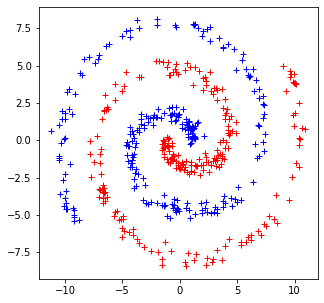

In [48]:
vis_data(X_test, y_test)

In [51]:
activation, depth, neurons, optimizer, lr, batch_size, criterion = "relu", 2, 20, torch.optim.Adam, 1e-3, 10, nn.BCEWithLogitsLoss

In [52]:
model = Model(activation=activation, n_neurons=[neurons]*depth, logits=False)
_criterion = criterion()
_optimizer = optimizer(model.parameters(), lr=lr)
train_error, _num_epochs = train(num_epochs, batch_size, _criterion, _optimizer, model, training_set)

Epoch [1/1000], Loss: 0.6939
Epoch [2/1000], Loss: 0.6811
Epoch [3/1000], Loss: 0.6756
Epoch [4/1000], Loss: 0.6703
Epoch [5/1000], Loss: 0.6638
Epoch [6/1000], Loss: 0.6555
Epoch [7/1000], Loss: 0.6376
Epoch [8/1000], Loss: 0.6245
Epoch [9/1000], Loss: 0.6162
Epoch [10/1000], Loss: 0.6110
Epoch [11/1000], Loss: 0.6068
Epoch [12/1000], Loss: 0.6019
Epoch [13/1000], Loss: 0.5970
Epoch [14/1000], Loss: 0.5900
Epoch [15/1000], Loss: 0.5820
Epoch [16/1000], Loss: 0.5748
Epoch [17/1000], Loss: 0.5652
Epoch [18/1000], Loss: 0.5559
Epoch [19/1000], Loss: 0.5457
Epoch [20/1000], Loss: 0.5358
Epoch [21/1000], Loss: 0.5297
Epoch [22/1000], Loss: 0.5244
Epoch [23/1000], Loss: 0.5180
Epoch [24/1000], Loss: 0.5134
Epoch [25/1000], Loss: 0.5102
Epoch [26/1000], Loss: 0.5083
Epoch [27/1000], Loss: 0.5073
Epoch [28/1000], Loss: 0.5064
Epoch [29/1000], Loss: 0.5059
Epoch [30/1000], Loss: 0.5056
Epoch [31/1000], Loss: 0.5051
Epoch [32/1000], Loss: 0.5049
Epoch [33/1000], Loss: 0.5046
Epoch [34/1000], Lo

In [53]:
model.eval() # set the model to test mode
with torch.no_grad():
    y_test_pred = model(X_test).view(-1)

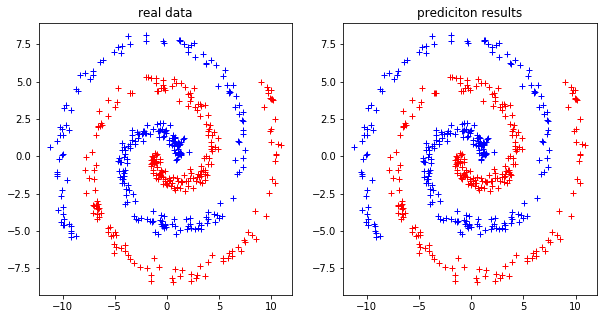

In [56]:
compare_pred(X_test, y_test, y_test_pred)

In [55]:
accuracy(y_test, y_test_pred)

Accuracy of the network on the 1000 validation data: 100.00 %


1.0